In [1]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

import glob
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def lorentzian(X,x0,c):
    return c**2/(np.pi*c*(c**2+(X-x0)**2))

def ODMRfit(X,a1,f1,w1,a2,f2,w2):
    return a1*lorentzian(X,f1,w1)+a2*lorentzian(X,f2,w2)

def pol(X,phi,theta,a):
    return a*(np.cos(X-phi)**2+(np.cos(theta)*np.sin(X-phi))**2)

def OrientODMR(X,Y,Z):
    X = X[1:,:]
    Y = Y[1:,:]
    Z = Z[1:,:]
    
    poptX, pcovX = curve_fit(ODMRfit,X[:,0],X[:,1],p0=(-4E8,X[np.argmin(X[:,1]),0],1E7,-4E8,2.87E9*2-X[np.argmin(X[:,1]),0],1E7),
                           maxfev=2500)
    plt.plot(X[:,0],X[:,1],'ro')
    plt.plot(X[:,0],ODMRfit(X[:,0],*poptX),'r-')

    poptY, pcovY = curve_fit(ODMRfit,Y[:,0],Y[:,1],p0=(-4E8,Y[np.argmin(Y[:,1]),0],1E7,-4E8,2.87E9*2-Y[np.argmin(Y[:,1]),0],1E7),
                           maxfev=2500)
    plt.plot(Y[:,0],Y[:,1],'go')
    plt.plot(Y[:,0],ODMRfit(Y[:,0],*poptY),'g-')

    poptZ, pcovZ = curve_fit(ODMRfit,Z[:,0],Z[:,1],p0=(-4E8,Z[np.argmin(Z[:,1]),0],1E7,-4E8,2.87E9*2-Z[np.argmin(Z[:,1]),0],1E7),
                           maxfev=2500)
    plt.plot(Z[:,0],Z[:,1],'bo')
    plt.plot(Z[:,0],ODMRfit(Z[:,0],*poptZ),'b-')

    g = 28E6 #NV gyromagnetic ratio in Hz/mT
    Bx = np.abs(poptX[4]-poptX[1])/(2*g)
    By = np.abs(poptY[4]-poptY[1])/(2*g)
    Bz = np.abs(poptZ[4]-poptZ[1])/(2*g)
    
    Sx = 1/(2*g)*np.sqrt(np.diag(pcovX)[1]+np.diag(pcovX)[4])
    Sy = 1/(2*g)*np.sqrt(np.diag(pcovY)[1]+np.diag(pcovY)[4])
    Sz = 1/(2*g)*np.sqrt(np.diag(pcovZ)[1]+np.diag(pcovZ)[4])

    print "X field: %.2f +/- %.2f mT \nY field: %.2f +/- %.2f mT \nZ field: %.2f +/- %.2f mT" % (Bx,Sx,By,Sy,Bz,Sz)

    Bz = Bz/0.755 #scale Bz to account for inhomogenous field strength under z rotation
    B = np.sqrt(Bx**2+By**2+Bz**2)
    SB = np.sqrt((2*Bx/B)**2*Sx**2 + (2*By/B)**2*Sy**2 + (2*Bz/B)**2*Sz**2)
    phi = np.arctan(By/Bx)*180/np.pi
    Sphi = np.sqrt( (-1/((1+(By/Bx)**2)*Bx**2))**2*Sx**2 + (By**2/(1+(By/Bx)**2))**2*Sy**2 )
    theta = np.arccos(Bz/B)*180/np.pi
    print "B: %.2f +/- %.2f\nPhi: %.2f +/- %.2f\nTheta: %.2f or %.2f" % (B,SB,phi,Sphi,theta,180-theta)

def OrientPol(T,mirror=False):
    
    T[:,1] = T[:,1]+np.linspace(0,T[0,1]-T[-1,1],num=T.shape[0])
    
    if mirror:
        T_half = T[T[:,0]<180]
        T_half_copy = T[T[:,0]<180]
        T_half_copy[:,0] = T_half_copy[:,0]+180
        T = np.append(T_half,T_half_copy,axis=0)
    
    T[:,0] = T[:,0]*2*np.pi/360
   
    opt1,cov1 = curve_fit(pol,T[:,0],T[:,1],p0=(np.pi/2,np.pi/4,np.max(T[:,1])))

    plt.polar(T[:,0],T[:,1],'ko')
    plt.polar(T[:,0],pol(T[:,0],*opt1),'r-')

    print "Phi: %2f +/- %2f" % (opt1[0]*180/np.pi,np.sqrt(np.diag(cov1))[0]*180/np.pi)
    print "Theta: %2f or +/- %2f" % (opt1[1]*180/np.pi,np.sqrt(np.diag(cov1))[1]*180/np.pi)
    print "Phi(naive): %2f" % (T[np.argmin(T[:,1]),0]*180/np.pi-90)

    print "Theta(naive): %2f" % (np.arccos(np.sqrt(np.min(T[:,1])/np.max(T[:,1])))*180/np.pi)

In [104]:

def EPR(EPRfiles,Pfiles):
    files = glob.glob(EPRfiles)
    pseq = np.loadtxt(Pfiles)
    d_sum = np.zeros((pseq.shape[0],))
    l = pseq.shape[0]
    for f in files:
        epr = np.loadtxt(f)
        diff = (epr[l:,0]-epr[l:,1])
        diff[np.isinf(diff)] = 0
        diff = np.nan_to_num(diff)
        diff.resize(((diff.shape[0]- (diff.shape[0] % l)),1))
        diff = np.reshape(diff,(pseq.shape[0],-1),order='F')
        d_sum += np.sum(diff,axis=1)
        
    return pseq,d_sum


def RabiFit(t,a,f,phi,T1,c):
    return a*np.exp(-t/T1)*np.cos(2*np.pi*f*(t+phi))+c
                            

def RabiFit2(t,a1,f,phi,T1,c,a2,a3):
    return np.exp(-t/T1)*(a1*np.cos(2*np.pi*f*(t+phi))+a2*np.cos(2*np.pi*(f+0.0022)*(t+phi))+a3*np.cos(2*np.pi*(f-0.0022)*(t+phi)))+c

X field: 6.89 +/- 0.02 mT 
Y field: 8.95 +/- 0.02 mT 
Z field: 1.02 +/- 0.03 mT
B: 11.38 +/- 0.03
Phi: 52.40 +/- 0.50
Theta: 83.19 or 96.81


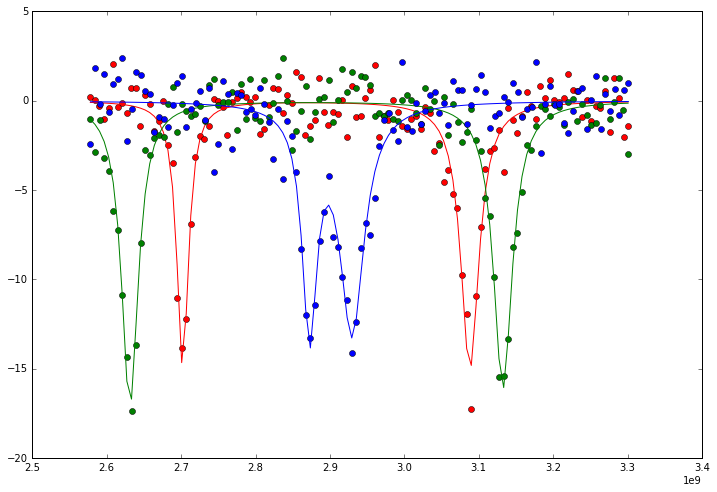

In [2]:
D1_X = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\6-8-16\Dot 3 x146 y81 5mW ODMR T0')
D1_Y = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\6-8-16\Dot 3 x146 y81 5mW ODMR T90')
D1_Z = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\6-8-16\Dot 3 x146 y81 5mW ODMR T0 x15_4')
OrientODMR(D1_X,D1_Y,D1_Z)

In [ ]:
T1 = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\6-8-16\Dot 3 x146 y81 5mW rotor')
T1[:,1] -= 5300B2AggDsBPMwYCwEwHcBeIuoBYD+A9yrUTymr/ywX0QKBwK0IZ0EgEPQCcJSIjERkARAD4DEA4wGsKquzCsCjZa8tAFQAfAGIrG4CQRNAOAsCgeA8gPvKph2UAB4E0B5AayLKAgAiug6gddnrBAA+AA4CWMpHskAgcCcy3gIEAgFfiCiBMTYXQBSAEgCnYRs9qIq1wjVvukmeQCCQAGJkQSAQgIh+JKKBRBQKoADARQBZjLHWAMAYawPgBkeJAoGAI8JZEAgEYIwFlf3bAcAEAOsBbAfwz7IqzwLYxkWcQCDgDhO7TgoEAsZYDIDmAEoBvElE0Yyx5gB+gi1+4RqAJ4mogKNMgUDACeEsCAQCgUAgqBUxDSEQCAQCgaBWhLMgEAgEAoGgVoSzIBAIBAKBoFaEsyAQCAQCgaBWhLMgEAgEAoGgVoSzIBAIBAKBoFaEsyAQCAQCgaBWhLMgEAgEAoGgVoSzIBAIBAKBoFaEsyAQCAQCgaBWhLMgEAgEAoGgVoSzIBAIBAKBoFaEsyAQCAQCgaBWhLMgEAgEAoGgVoSzIBAIBAKBoFaEsyAQCAQCgaBWhLMgEAgEAoGgVmS8BQgEAvfAGGMAFAA0FUxd4bUSth8QXgC8K7wmANYqZgZQAqC4zCq+LiYik7v+LoFA4HqEsyAQeChlnX8zAG0BtCv7t61Sqezk5+fXBcBtVqs10Gw2K00mkxKAr4+Pj0Uul5f6+PiQUqm0tmjRwqLRaGC1WmX+/v6sRYsW5OXlxfLz873kcjkCAwMBAFlZWfD29iaVSkVWq5UyMzOZyWSyWiwWS1FREfLy8ryNRqOX0Wj0NhgMPl5eXuTr62v08fHRy2SyYsZYLhFd1Wq1SaWlpekAMgBklv9LRAYe76FAIKgbjIh4axAIBDXAGFMA6AqgB4DuAQEB/b28vHoYjca2BoOhmUwmoxYtWhgDAgLQpk0brzvuuMO3ffv2Ps2aNUOHDh1w2223QaPRQKPRQK1WQyZzz+8Do9GI4uJiFBcXo7CwEMnJycjMzER+fj5SUlIMZ86cseTl5VkLCgq88vPz5d7e3qV+fn45vr6+6QaDIU6r1cYBuFRm14jI4hbhAoGgWoSzIBBwpmyEoBPKHAK1Wn2Hj49Pf6PR2MVkMvm3bdtW1759e9a9e3f5sGHDZCEhIQgODkbbtm2hVqtdri86OhqhoaEuuz8RITc3F5mZmUhNTcXly5exb98+U1pamiElJcW7sLDQT6FQ3PDx8blYUlJy0mQyxcPmRMQTUa7LhAkEAjvCWRAI3EiZY9AFwEA/P797VCrVcK1W29vPzw/BwcGW++67T9anTx95t27d0KNHD3Ts2BHe3t5cNbvaWbgVOp0OiYmJSEhIwOXLl+n8+fO6I0eO4Pr16z4+Pj5Fvr6+p/Pz8w8S0QkAJ4koh5tYgaCRIpwFgcBFVHUMFArFKL1e312tVltvv/126t27t3L8+PFeAwYMQKtWrXjL9TisViuSkpJw8uRJbN682ZyUlKRNSEhQyGSyIplMFldYWLhPOBACgXMQzoJA4CQYY14AbgcQGhgY+DetVnuvRqOx3nXXXdbBgwer7rrrLq/BgwcLx8CFlDsQBw8eRFxcXOnhw4d1cXFxCm9v7yJvb+9dxcXFOwFEE1EGb60CgSchnAWBwEHKnIPeAEaWOQfDWrZsaRkzZoz3mDFjFCNGjMBtt93GW2aD4T0N0VCsVivOnj2L2NhY7Ny5szgmJsaXMVbo5eW1q7i4eBdszkMmb50CgZQRzoJAUA8YY10BhDVv3nx8SUnJsMDAQOvYsWO9w8LCGo1zUBVPdxaqYrVaERcXhwMHDmDHjh3Fhw4d8vX29i4AsKukpGQHgD1EVMBbp0AgJYSzIBDUAmPMG8A9CoViore39zOMsYDx48cjLCxMERoaivbt2/OWKGggFosF586dw4EDBygiIqLk8OHDfkql8s/CwsLVRLSdiK7w1igQ8EY4CwJBFRhjagBj/P39nzaZTA+2a9eOnnrqKcWjjz4qGzhwILy8RJb0xoxWq0VUVBS2bt2q37ZtGyOiHJPJtMFoNG4FcIyIrLw1CgTuRjgLAgEAxlhbAOMDAwP/rtPpBg4YMMA4YcIEzRNPPME6derEWx5XGts0RH2wWq04fPgwfv75Z/P27dv1WVlZJJPJdhYXF2+AbbpCz1ujQOAOhLMgaLIwxvwBTAwMDHzJaDT2DQ0NtTz66KPKJ598Es2aNeMtTzI0ZWehKleuXMF3331Hu3fvLrlw4YLMz88voqio6DsAB0SWSUFjRjgLgiYFY8wXwAMBAQFTdTrd6N69e1s/+OADxcMPPwy5XM5bnsCDyMzMxIYNG2j+/PmGgoICI2NsrU6nWwHgDIkHq6CRIZwFQaOnLDnSULVa/VxpaelTvXv3Nr/wwgv+TzzxBJo3b85bnqAREB8fj9WrV5u///57o16vLzKZTEtLS0vXEtFV3toEAmcgnAVBo4Ux1tHPz+9FmUz27xYtWiiff/55xZQpU7ybegxCfRHTEHWHiPD7779j5cqVhk2bNkEmk10uKCj4CsAGItLy1icQOIpwFgSNirJESWMDAgL+W1paOuTBBx/0fuutt3zuuece2AYYBPVFOAuOYTKZsHHjRixbtkx35swZeHt7r9ZqtYuIKIG3NoGgvghnQdAoYIy1kMlkz/n6+k5r0aKF+qOPPlI+/fTTUKlUvKUJBEhJScGyZctKFy9ebC3bt+JzANuJqJS3NoGgLghnQeCxlMUi3K3RaN4pLS19+NFHH7W+8cYbykGDBolRBIEkMZlM2Lp1K+bPn1984cIFi8ViWWIymZaJvSoEUkc4CwKPgzEmBzCpWbNm7/r5+QU//fTTipkzZ3q1bNmSt7RGiZiGcA1nz57Fu+++azp48CD5+fntLywsnAsgRqykEEgR4SwIPAbGmMbHx+c/3t7e7w8YMMBrxowZ6rCwMJFR0cUIZ8G1FBUVYc2aNTRr1iy9VqtNKS4ung4gQmSKFEgJ4SwIJA9jLMjPz+8txtir48aNYx999JGyX79+vGUJBE7FYrFgy5Yt+Oijj0oyMjJyi4qKZgLYKOIaBFJAOAsCycIYa69Sqd43m83/HD16NFu4cKFf165decsSCFwKESEqKgqvvvqqPj09XavX6z+2Wq0rRGppAU/E+K1AcjDGemo0mp8UCsWl559//t9XrlyRR0ZGCkeBE9HR0bwlNCkYYxg7diwuXryo2Lt3b8vRo0fPVSgUmb6+vjMYYyIPuYALwlkQSAbGWO+AgIAdarX69KRJkyakpaXJFyxY4NuuXTve0gQCLgwePBi7d+9WHTlypNnQoUM/kMvlGUqlcq5wGgTuRkxDCLjDGOugVqu/IKJHZs6c6fPKK694i/wIAsHNJCcnY8aMGfqtW7dazWbzJ2azeTERGXjrEjR+hLMg4AZjrIVSqfwYwHPPP/+87OOPP/YJCAjgLUsgkDxnzpzBm2++qT1+/LhBp9P9l4hWE5GZty5B40U4CwK3wxhT+fr6vs0Ye3fKlCksPDxc3rZtW96yXAMRUFoKmEyA0Wj7t7rXjAFBQUDr1oBazVt1JcTSSely+PBhvPbaayUJCQlFWq32FQC/ijwNAlcgnAWB22CM+cpksud9fX1njRkzxnfu3LnKHj168JZVfywWIDUVuHy5siUmAkVFlR0BkwmQyQA/P8DX12blryseIwJu3ACysmyOQ+vWQJs2tn8rWoVjV/V6zPj8c6RnZCA4OBjh4eHo3Llznf8Mq9Vqz1GRn58PnU6H4OBgAMD169dRVFSE7t27Izo6Gj179kRJSQnKg0zz8/NhMBjQaJ08D4KIsG3bNrzzzjvaGzduXC0qKnqFiKJ56xI0LoSzIHA5ZWmZH1cqlUv69Omj/uabb5QDBgzgLat2rFYgLa2yI1D+OjkZaNEC6NatsnXtCjRvXtkp8PEB6pM0iggoLrY5DRXt+vVK5dL0dJjT0mAhQhyA4wCSgoLwztq1uO3++3ExMRFJSUl48MEHAQCnTp1CSkoKHn30UQDAyZMnkZ6ejvHjxwMArly5gvz8fNx1110AgPT0dBQXF6Nnz572cmFhIXr37m2vn5ubi7vvvhsAcOLECWRmZuJvf/tbteW4uDhotVoMHjy47O21imRaTsZqtWL9+vV4/fXX9aWlpaeKi4tfIKI/eesSNA6EsyBwKYyxXv7+/j8GBQXd/s0336hGjx7NW1L1FBQABw4AUVHAoUM25yAg4GaHoFs3ICQEUCpvukVycjJmzpyJ9PR0h37p3wqLxQJvb28AwN/+9jdERkaiGYC+ADoDaA1gmlqN1oxB37cv2MCBkA8eDNx9N9Cli23EghM6nQ56vR4tWrQAAPzxxx8oKCjAAw88AACIjY2F1WrFiBEjuGlsLJhMJixZssT60UcfGYnoe61W+wERFfPWJfBwiEiYMKcbAI1CoVgol8sNCxYssJSWlpKkMJmIYmKIZs4kGjyYSK0mGjuWaN48ohMniEpK6nW7K1euUEhICAGwW0hICF25cqVO106ePJlCQ0Np8uTJdOXKFcrJyaHffvvNXufy5cu0du1ae3nEiBGV2iq3kSNHEuXmEu3ZQ/TZZ0QTJhC1b08UGEg0ZgzRe+8RbdlClJJS57/twIED9XovHMFqtZLJZLKX9+7dSwcPHrSXz507R+np6S7X0Zi4fv06PfPMMzq5XF4IYBLKfhwKE+aIcRcgrHEZAAbgaaVSmfv000/rMjMzSRJYrUQXLhAtWkT08MNE/v5EAwYQvfsu0d69RHp9g24/efLkajvvyZMn13pdTU7G+fPna+0c693e9etEkZFEH39M9NBDREFBRLffTvThh0Rnztjenxpwh7NwK65du0bXrl2zlzdv3kx//vknR0WeQ0xMDHXv3r3E39//OIDbSQLPCWGeZ9wFCGs8BqCPRqM50bFjR+2hQ4eIO1lZROvWEf3zn0TBwUQdOhA99xzRxo1E2dlObSo0NLTmX/plWCt0yDqdjubMmeN0J6MuIxlERGSxEB0+TPT220Rdutjs7bdtxywWh94Dd1J1JGLVqlWUmJjIUZG0MZvNtGTJEotCodArlcqlAJqRBJ4ZwjzHuAsQ5vkGwF+pVC5Wq9W6RYsW8Z1yMJmINm+2Dbk3a0b0yCNES5YQXbxY66/nhlJTpz9p0iQisnVun376KZnN5krX1cXJqIny6YuRI0fapy8cwmq1jS58+KFttKFtW6L//Mc24lKhQ64v1U2vuIslS5bQjRs33Naep5CVlUXPPPOMXqlU5jPGpoipCWF1Ne4ChHm2AXhYLpcXTJo0SZeVlUXcuHaNaMYMW0c3fDjRunV0JT7ebZ1Vdb/0W7RoQWfOnKn1OkdHFlzKxYtEn39ONGgQUYsWdCAsjGjbNiKdrs63aPDIh5OZNWtWpZGIps6RI0eoe/fuJWq1+iSALiSBZ4kwaRt3AcI80wAEajSaTW3atNHu3r2buGA2E0VE2GIQmjcneu01orJ5bB6d1fz582n8+PH1+qUvtU71JlJS6MCrr5Ju8GDS+vjQ7tatacYDD9xSnySdoDK0Wi19/vnnvGVwx2w200cffWRWKBRaHx+f1wB4kQSeLcKkadwFCPM8KxtNyH/xxRcNxcXF5HYyMojCw20xCIMGEa1YQaTVVqrijs5q165d9Pvvvzf4Pk6bTnAR5Q5NEEDTALoK0HG5nK5//TVRDVNODZlecTfJycm0YsUK3jK4kZCQQHfeeWeJRqM5IUYZhNVk3AUI8xwrH01o1aqVNjIyktyKxUIUFUU0cSJRQADRCy8QnTpVY3VXdFZnz56lLVu2OHy9p1LV8fIGaCJACUFBRB07Es2fT5SfX+s1UhpZqI6Kwad//PEHHT9+nKMa92M2m2natGnlowyvilEGYVWNuwBhnmEAHlIoFHluH03Q64kWLCDq2pWoXz+iZcuICgtveZkzOiu9Xk/79u2zly0esEqgLtQ38LBfv341O15HjxJNmmTL4/DKK0SXLtnbkPT0Si2YzeZKwZFpaWmN5v/+VlQYZTguRhmEVTTuAoRJ28pHE1q2bKmvmCTI5VitROvXE3XsSCWjR9OHYWEUOmKEy2MBKq7kKCkpoXPnzjX4T5ESjrwvo0ePvrXjlZZG9P77RC1bEv3tb0T79tGVpCRJT6/UldjYWIqPj+ctw22YzWZ6++23zXK5XCdGGYSVG3cBwqRrAEYplcpct48mxMbaYhHuuosy1q9vcGbE+nRWc+fOJX0DEzRJGUdGXOrlYGi1RMuXE/XqRdS3ry2exGBw4V/k/iWan332GenqsTLEUykfZfD39z8CoB1J4JkkjGN/wFuAMOkZAG+5XD5bpVIZduzYQW7j0iWixx6zpSdes4bIYnH53HdkZCTFxcXVeJ5nrgBX4GgsR70dL6uVaPduorAwok6dbImwbpHnwpH3mvd0R15eHu3fv98tbfGgLJbBJJfLiwCEkQSeT8I49Qu8BQiTlgEI9vf3Pz506FCt21I15+QQvf46UYsWtv0MKvxqc0WgYsWRg5Ja9oDg3RG5Akecrwanez5wgKh/f9seHIcPV1vF0feadyCl2Wyms2fPuqUtnhw4cICaN2+uUyqV/wPgQxJ4Vglzc9/AW4Aw6RiAB+VyefHHH39sqppp0CUYDLZI+pYtbRkDq0nq5OzOIC4ujrZt21anurw7IlfgSKfslL0hLBailSttabefeoqoSnuOvtdSW6J58OBB2rt3L5e2Xc2NGzcoNDRUq1KpzgPoSBJ4ZglzY//AW4Aw/gbAR6VSLWrevLlu165d5HKsVqJNm4g6d7YFw124UGPVhv66N5vN9N1331VaGldXpNYROQuueR1KSog++cSWROu//yUqKCAix99rqTt0p0+fblQrKSwWC02fPr1UoVAUAXiUJPD8EuamfoK3AE83AD8AyAJwrsKxTwGcBXAawC4AbcqOdwSgA3CqzJZWuObhsmu+dbP+Tmq1+vz999+vzXby5krVcvy4bTi6f3+iCssSa6MhnZvVanV4a2Opd0QeTXo60b//TdS6NdHXX9Pfn3nGofda6lNFsbGx5JbvlZs5cuQItWrVSqtSqZYD8CN+z1+vsufs9rLyRwDSKjxjH6hQ94eyug/y0uvJxl2ApxuAYQDurOIsqCu8fhXAsrLXHSvWq3KfjWUf/E8B9HaT9gkKhaLkzTffNLv814/FYttvoFUr23C0C9vbuHGjU7YvlnpH5C5cukX16dNEo0aRsWtX+nebNg6911LPgFlOTk4O/fDDD7xlOI28vDwaMGCAQa1WJwDoSnyev28CWFvFWXirmnp9ys55A9jEQ6unG3cBjcFu4QRMB/B1hXpxNdTbBEAOYD6Abi7W66VUKj8PCgrSHj16lFxOZibR6NFEw4bZNnxyAUVFRS65r6d0RK7Epc4CkW1aavt2MnbpQufatKFnBw1qtO81l/ToLsRqtdJXX31lUSqVRQDGkHufu7cBiAIQWsVZmFZN3Z4AvgCgALDRnTobi3EX0BisOmcBwCwAKQDOAWhRoV5x2fDYAQDDKtQfDeAEgLku1qpRq9VRPXv2dM8ukTt3ErVpY9v+2EVbV1+9epU2bdrkknsL3IjJRLRwoS3gdeFCl44+SYGIiAg6duwYbxlO4eDBg6RSqQy+vr5vwU3bXgP4uWxUd0QVZyEZwBkA3wMIqFB/AYBjAIa7Q19jM1b2JgoaAGOsI4AIIupbzbl3ASiI6GPGmC8AFRHlM8YGAPgVtimHEjfp7KJWq6MmTJjQ7vvvv5f7+vq6rjGTCfjgA2DjRmDNGiA01Km3v3z5MoKDg6FUKp16X4EESEwE/vEPQKEAfvwR6NCBtyK3YDQa4efnx1uGwyQlJSEsLEyblZW1vaSk5F9EZHRVW4yxhwCMI6JXGGOhsE09jGeMBQHIISJijM0C0JaInnOVjqaEF28BTYD1ACYCABGZiCi/7PUpAEkAurtDBGNspEKhOD179uyOq1atcq2jkJgI3HsvcPEicPq00x0FALh48SK8vb2dfl/BzURHR7u3wa5dgZgYYPRoYOBAm7PZyH/UWK1WLFy4EJ784y0kJARnzpxRjRgx4hG1Wn2UMdbGhc3dC2A8Y+wKgA0ARjHGVhNRNv31Jn4H4G4Xamha8B7aaAwGoBMqxCKgQrAPbAGOP5W9bomyPOsAugBIRYVhMhdpYz4+Pq+oVCr9r7/+Si5n7VrbMPJXX90yY199KCgooIMHDzrtfoK64/KYhdo4fZqoTx9bZs9GuKqgJnJzcz12yaXFYqGpU6eWKhSKHAB3keufvxWnIdpUOP4mgPWubr+pmJiGaCCMsfWwBdi0gG0J5UcAHgLQA4AFwDUALxJRJmPsMdhWO5gAWAF8SEQ7XKjNV61WLw8KCnoyKipKGRIS4qqmgJIS4JVXgD/+sE093HmnU2+fmpoKHx8ftGnjyh8rAkliMAAzZwLr1gHffgs8/DBvRS7n3LlzyMvLQ6gLRuXcxZYtW/Dss8/qdDrdc1ardaOr2mGMjYAtqHE8Y2w1bHEMVgBXAbxARFmuarspIZyFRgpjrKVKpYq66667ekRERCj8/f1d19jp08DTT9umHhYvBlSqel2enJyMmTNnIj09HcHBwQgPD0fnzp2xfft2jBw5EhqNxkXCBR5FTAzw7LO26Yn//Q9oQp+LlJQUdPDA2I2zZ89i1KhRer1e/7Ver3+XiKy8NQkchPfQhjDnG4BOKpUq9fXXXze6fChz5UrbtMP69Q5dXlsug4SEBCeLFTgC12mIqhQWEj33HFGXLrbdSZsAFouFVqxY4VAWUilw/fp1uuOOO0o0Gs1miH0lPNa4CxDm5P9QoK9CochduHCh6zd3WLCAqEMHovh4h28hsiTyobS0lPLz8+3l/Px8OnLkiL2ck5NDu3fvJiKbs5CTk0P7KmTcLCwspDNnztjLZrOZTCaTG5SXsW0bUdu2RB991OiXWFYlOzvb4xwHrVZLY8eO1arV6hhUSFonzHNMrIZoRDDGRsjl8iOLFi0KfP311123VIAI+PhjYNkyIDYW6NnT4Vulp6dXezwjI8PhezZViP6aUszJycGqVavs5YyMDCxfvtxezs7ORlRUlL3s7e1daRmqUqlE9+62hTqhoaFQKBTo2LFjpbaMxr9Wxl2/fh3r1q2zl69du4YffvjBXs7MzMSBAwca+if+xfjxtumvvXuBJ54AtFrn3VviJCUl4cSJE7xl1AulUonffvtNOWLEiEFqtfp42RJHgSfB21sR5hwD8Jharda6fMc7i4XotdeI+vUjun69wbcbP368GFlwgJKSElq9erW9nJ2dTYsXL7aXTSYTabVaHtKqRa/XV8rIeOnSJVqzZo29nJ6e7liKboOB6F//sn0er151hlSPwmq1VtpyXepYrVaaPn26UaVSpQLoRBJ4dgqrYx/DW4CwhptMJvuPv7+/7uTJk+RSSkuJnn2WaOhQogpD2A1hw4YN1KVLlya//0J1GI1G+2u9Xk+fffaZvVxaWkpuycBJ7olZyMvLo7i4OHv51KlTVOelvlYr0f/+Z5uWOHTIRQqlSVFREX399de8ZdSbhQsXmhUKRR6AviSBZ6iwWxt3AcIa8J8HMIVCMSsoKEh38eJFcikGA9GECURjx9q2GW4A16uMSIj9F2wkJSVRaVlKbKvVSp999pkk1tpLIcDx0KFD9hgKIqr+fdm5kygoiGjFCjcqEzjK0qVLrXK5vATACJLA81TYLfob3gKEOfgfB3irVKoVPXv2LKna+Tqd4mKiMWOIJk60OQ0NoLS0lJYvX+4kYZ5NXFwcFRQU2MubN2/2qCFlnuzevZsOHz5sL9vft/h4om7diN56i8hstjuioaGhTcIRXbBgAeXl5fGWUWf27t1LarVaC+AxksBzVVjNJvIseCCMMR+1Wv1Lt27dRkVHR7s2h0J+PvDgg0CvXraEODJZnS6rmjvhk08+gUuTQnkA6enpkMlkaN26NQDg0KFD6N+/P1T1zEshuJlff/0V3bt3R+/evYG8PJifeAImiwX3XruGM1ev2uuFhIQgKioKnTt35idWUIlTp04hNDTUoNPp/mM2m3/krUdQA7y9FWH1MwC+Go1mx/Dhw7Uu/xWamUnUty/Rm2/Wa3ladbkTWrdu3eh/1VXFbDZXWp546NAht8UZOBMpTEPUl+VLl9KGkBCKB6hrEw2e3b9/P504cYK3jDpx9uxZCgwM1MpksudJAs9ZYTebWDrpQTDG/NRqdeTQoUNH7NmzRymXy13X2LVrwH33AY8/Dnz5JeBV94/KzJkzkZSUVOlYVlYWZs6c6WyVkoPor5G6w4cP48qVK/byvffei1atWvGQ1eSY+tJLWN6+Pb4EEAvb5i3lNJVluaGhoejWrRtvGXWib9++OHr0qDIgIGChr6/vf3jrEdyMcBY8BMaYXK1W77799tuHb9++XenSrWxTU22Owquv2nLyM1avy5tq7oRLly5h/fr19vJ9992HAQMGcFTkHDx1f4Lg4GB8D+ApAEdh27AFAJo3b46lS5fyE+YmGGMon6LMy8tDfHw8Z0W1061bN/zxxx9KpVL5pa+v72u89QgqI5wFD4Ax5qfRaHaOHDlyUEx6f0oCAAAgAElEQVRMjJ9Lt5cuKbElvHn1VeA1x76vwcHB1R5v165dQ5RJDr1ej3nz5tnL3bt3x+TJkzkqElQkPDwcISEhiAHwMIAfALzUujXmzZuHF154wV4vMTGx0ghQY8Tf3x+ZmZm8ZdySkJAQHDt2TB4YGDjHz89POAwSQgQ4SpyynSN3hIaGDt26davCYrHAZdMPViswcSIQGAj88EO9RxQuX76Mjh07Ij09HWPGjKk0FdFYAsuuXbuGVq1aQaFQgIhgsVggq2PQp6cSHR3tsaML5YG2GRkZGCKX45MTJyBbtAh45hl7ncLCQqSkpECtVle7oVljxGq1wqseU4vuwmQyQSaTISUlBffcc48uLy/vndLS0sY/DOQJ8A6aEFazAfBRq9W7+/fvbyxP0LN7927XBS1Nn040fDhRhWRA9WHz5s32PAGNNXfC1q1bJZUZ0R14YoBjjcTF2ZI3/fhjpcO1bWjW2LBYLPTpp59Kcn+Jb7/9lm7cuEFERImJiaTRaIw+Pj5TSQLP46ZuYmRBojDGfDQaza+DBw8OjYyMVLp06gEAVq0CPv0UOHoUaNnStW15ELt27YK/vz+GDh3KW4rAWSQkAGPG2OJxpk4FAEyZMqXS3hblTJo0CY8++igmTJjQ6EeQpMjly5cxZMgQXWFh4aulpaUreOtpykhvHEoAxhhTqVTrBgwYEBoREVGjo5CSkuKcBg8dAt55B4iIqJejYDabER4e7hwNEoGIKr2vDzzwgHAUGhs9ewLR0cBnnwFffQWg5qDczMxM3H777fD2dt2+bLzZsGEDTCYTt/aNRiOysrKqPdetWzf8/vvvSo1Gs5gx9oSbpQkqIJwFCaJUKv/XsmXL8b/99lutqx7OnDmD7OzshjWWnGzbtW/NGqB373pdKpPJMGPGjIa1LzEyMjJw4cIF3jIkRXR0NG8JzickBDh40OYszJtXa1Bur169wMrid5KTk7Fy5Uo3CnU9w4YNs/99PDh48GClHUyr0qNHD+zevVspl8vXMMZGulGaoAJiGkJiKBSKd1q3bv3xyZMnlS1atHBtY0VFwNChwAsv2FY/1IErV67gpZdegslkajRBYCtXrsTEiROh0Wh4S5EknhzgeEvS04H770f+gw/i7m3bkFRhVURdgnKzsrLQqlUrrp2tMzGZTHD5lKeDHDhwAA8//HCJTqe7j4jO8NbT1BDOgoTw9vaeEhgYuPzUqVPKDh061Ova2NhY3HfffXW/wGKxLZHs2BH4+us6rXxITk7G/fffj+TkZPuxxrDKITs7G0FBQbxlCHhx/TowejTyR47Eq/n5yMjIQLt27Wp0hCumMpfJZHj77bcRFhbGQbjz+fHHHxEWFubyZc5GoxFnz57FoEGD6nXdzz//TM8++2yBXq8fSESNe72r1OAdYSnMZgDClEql/vTp0+QI+/fvt69EqBNvvkl0//1EJlOdL5k8eXKlaHF4aPrc2NjYSjsYCgR04wZRjx5EixbVWq22VRMmk4l+++03Nwn2bBISEujatWsOXfvpp59aFApFJoBWJIFnd1Mx7gKEEQDcrVKpSg4dOkRu4dtvbQ/GOu5Ol5WVRcuWLaPQ0NBqnYWRI0e6WHDDMZvNvCV4LI1q6WRtJCcTBQcT/fRTjVVqc5itViudPHnSfXpdTFRUlGSXCb///vsmjUZzAYCGJPAMbwomAhw5wxjrrlAoojZs2KC69957G3w/s9mMDRs21FwhNhaYMcO28iEwsE73DAoKwvPPP++xmRktFgs+//zzcsdMIKieTp2AyEjg5ZdtwY/VUFsqc8ZYpfTeBw4cwLlz51yh1C306dMH+fn5Truf0WjETz/95JR7zZo1y2fixImd1Wr1TsaYNIMsGhu8vZWmbADaKZXKG7Nmzar7lo514NKlS9WfKCkh6tyZKDKyTvfJzMysVPakxDVWq5V0Oh1vGQJPZN8+olatiM6du+lUfabiLBYL5dVx9K4poNVqKS0tzWn3Ky0tpf79+xvUavUvALxIAs/0xmzcBTRVA6BWq9WXwsPD6xFo0EBef51oypQ6Vc3IyKBffvnlpuOekplxz549dPz4cd4yBJ7K+vVE7dsTpaRUOuyow2yxWGjevHmSzJpYF9atW0cXL17kLeMmdDodDRw4sESlUi0kCTzXG7NxF9AUDYCXWq3eMWXKFL0rHx5ZWVm0YsUKW+H3321pbnNyXNYeb6Q6v+rpNJmYharMn0/Uu/dNsT2OOswlJSWuUOkWrFYrWSz1HwAtd5JcSU5ODrVp00br5eX1D5LA872xmlg6yQGFQjGrbdu20+Lj4+Uu3WoagFarhcrbG+jfHwgPBx5/vMa6paWl2LlzJ8aPH+9STa6AiDB//ny8/fbbjWbNu1Ro1HkWbsVbbwEnTgB79gBO3MBt586d6NChA/r06eO0e7qLvLw8NG/evM71tVotVCqVCxXZEtQNGTLEaDAYhhPRMZc21kQRzoKbYYw91rJlyzVxcXHKNm3auKfR998HJSSAbd1aa7WioiLk5uZ6VM4Es9kscvYLXIfVCkyeDJSWAps2AU5K+2y1WqHVaj0yEdjWrVtx9913o3379jXWISK3O+3bt2/HM888k6fT6e4gogy3Nt4EEKsh3AhjrJ9CoViza9cu9zkKp04BP/yAk1OnIiIiotaq/v7+HuUoHD9+HHv37uUtQ9CY8fICVq4E8vKAN94A6vDjKjk5GVOmTMHIkSMxZcqUSknM/rqtl91RKC4urn0Fk8R47LHHanUUAGDOnDlu329i/PjxeO+99/zVavUexpjCrY03BXjPgzQVAxCkUCiyFy9e7L4IJ5OJqF8/olWriIiqDa7S6XT0v//9z14un48NDQ2VdACjwH002ZiFihQU2OIXli+vtZqjAZApVQIpPYUDBw5U+1zhFchptVpp6NChBpVKtRllI+fCnNSH8RbQFAyAr0ajOf7f//7XSO4kPJzogQeIqnxxqwYCGgwGIvKMpZFLliyhrKws3jI8HovFUmmJbWlpKa1fv95eNplMtKgsm+GBAwfIZDLR0qVLK9XfsWOHvWy1WqmwsNANyjly8SJRUBDR0aM1VnFGltPY2FiHggl5cOrUKSooKCAi23OkXllkXYRWq6WePXuWyOXy6SSB539jMe4CmoKpVKoVY8eO1br1AXD+PFHLlkTVpFTdsWMHVZdW2hPSOXvq0jN3Y7VaadWqVfb3y2w208cff2w/bzabacOGDfayxWKhxMTEStdX7PytVivlVFhJYzabK2UrNBqN9NVXX9nLOp2O5syZU+n8iRMnnPTXceTXX21LKmtwWJ2R5fTkyZMemZ9h5cqVdP36dd4yiMg2UhMQEKAD8CBJoA9oDMZdQGM3mUz2clBQkMGtv7rMZqJ77iFatqza01arlT755JObOl4ppnM2Go20rIa/o6mTmJhIpgp7e4SHh5PR+NfgVVJSkmScK4PBQPv27bOXc3NzaeHChfayVHTWifffJxo5kqiaX9HOdriLioo85r1ZuXKlpLTGxsaSn5+fFkBPkkBf4OnGXUBjNgAD1Wq17vLly+RWvvySaMQIojqMZFT8NSnFkQWr1UrZ2dnc2pcSv/zyS6X3YsuWLaTX613erjtiFtLT0+mbb76xl4uLi+3D25LDbCYaO5bonXduOuXsqbxjx45JOmbEYDBQamoqERElJydLylkgIvrmm28sarX6CgAFSaBP8GTjLqCxGoBmSqUyY9OmTe799iQmErVoQVSNg1JcXHzTXOj27dvtQ55SiVkwm80UFxfn1jalyE8//VTJmUtNTeUyl82js8rIyKBt27ZVKldNP86VnByiTp2Ifv75plOekuXUGRw4cMDh3SPdgdVqpYkTJ+rUavUqkkC/4MnGXUBjNABMrVZHPPLII7bIQXcyaZItsLEali9fTkVFRbVeLoUHXUJCAp0/f97t7fJm3759dOzYMXtZ7G3xF+np6fTHH3/Yy6mpqVRcXMxRERGdOGGLC7pwwS3NZWRk0LfffuuWthqCTqejr7/+mrcMO4WFhdSyZUs9gKdIAv2Dp5pIyuQCfHx8pnbs2PF/cXFxKoXCjct9ExKA++4DkpIAf/96X75//36MGjXKBcLqBpH7E7nwJDk5GWlpabjvvvsAACUlJVCpVE3qPXCU+Ph4GAwG9O/fHwBgMBggd2KGxTqzYgXwxRfAsWMOfefqixSSkBmNRpw4cQK17ZJbVFQEfze8H3XlyJEjuP/++7V6vb4fESXx1uOJiKRMToYxdrufn9+CyMhI9zoKgC2d85tvVnpoWSwWZGdn1+lyHx8fWK1WV6mrlR07duDo0aNc2nYXVqsVV69etZeVSiX69etnL6vVakk6CtHR0bwl3ESvXr3sjgIAREZG4vLly+4X8u9/AyNGAP/6V50SNgF1S9pUE+WOgtlsxuHDhx2S3FAyMjJumZRJSo4CAAwZMgRz5syRazSaSMaYa3PsN1Z4D200JgOgUiqVqStWrHB/lE98vG1ItMqqi/3791N8fLzb5QhuJjU1laKionjLqDdSDrCriTlz5rhvYzGDgWjQIKIKyc1qwplxQXv27HFErVs5duwY7dq1i7cMIrLFL4wePVqrUqm+IQn0F55m3AU0JtNoNOseeeQRPhPNkycTzZ7tlFsZjUZas2aNU+5VG3/++aekg6MaisViqXaJqsC95OfnV7vdulNJSrI56+fO1VpNiiuO6oLBYKB169Y5dG3F5by8ycvLoxYtWugAjCcJ9BmeZGIawkl4eXlNDggIeHTt2rXuz0mekGDbFe+VV+yHUlNTHb6dr68vhg0b5gxltVJcXIzg4GCXt+NO9u7di5SUFAC2/P8ffvihJKcWmhLNmjWrNN3jkqm2Ll2AuXNtm04ZDDVWS09Pr/Z4RkbD9j0KDw+H2Wxu0D1uxciRIx26ztfX18lKHCcwMBAREREKpVK5ljHWgbceT0I4C06AMdbVz8/v24iICKVarXa/gFmzbJvclM0TarVaHDp0qEG37NSpkxOE3QzRX/O699xzD7ydtIufVOjWrdst53M9DSnGLNQHxlilDdJOnTqFHTt2OL+hf/0L6NoVmDGjxio1Ocft2rVrUNMzZsxwaeCjn58f2rZt26B7LFmyBIWFhU5S5DhDhgzBjBkzFGq1ejtjrHE9gFwJ76ENTzcA3mq1+vS0adPMxIP4eFu+ehdliExPT6dVZRtROYOFCxd6ZCrbmvjjjz/ot99+4y3DpXhizEJ92LFjh/P2tcjOJmrXjmj//mpPuyOXyalTp5xyH6vVSp9//rnTptGMRqNkpuQsFgv16NFD7+fnJ/aPqKOJpZMNxM/Pb1rfvn0/OXr0qMrLi8NAzZQpQK9ewAcf4MaNG2jevHmdf2EkJydj5syZSE9PR3BwMMLDw6vdotqZy9KIPH95ZHx8PHr16sVbhsBJpKenQ6VSISAgwDk33LULmDoVOHsWCAy86XT59y4jIwPt2rWr8XvnKLt378bw4cPhjNVY3JakuoHk5GTccccdOq1WO5CI4nnrkTy8vRVPNgDdFAqF+9M5l5OQUGkFxIoVK+w7SN4KR37hOPqr4OrVq40mwZDRaKQtW7bwliFwEcXFxfTFF180/EYvv0z0zDMNvw8HXP3rX6/X05dffunSNurK119/bVGr1XEAvEkCfYqUjbsATzXYph/Ovvfee3ymH4iIpkwhmjXLoUsdico+cuQI7dy5s95t/fzzz5KKiK4vBw8ebNLLTxv7NERVKnaWDnecWi1Rz55EDq4gcBZLliyp9xLSOXPmuNy5d8eeJnXBYrFQ9+7dxXREHUxMQzgI9+mHixeBYcOApCQUof5JUEaOHFlt4NrIkSOxf//+Gq8j8vxphPqSnp6Odu3aNbm/u5zo6GiEhobylsGF3bt3Q6PRYOjQofW/+ORJYNw44MQJoAOfwHtHsoI2te+4mI6oG2I1hAMwxrrJZLLwDRs28HEUAGD2bOCNN3AlJwd79+6t9+WORmWXP0SKiopqrRcREYGcnJx665ICubm5+Pbbb+3l4ODgJvXwrEpTdRQAICwsrJKjoNfr637xXXfZVin9859AHZZrNiSzY01UzApqsVhqrGc0GmE0GgHArZ/1LVu21Lic1F107twZX3zxhVyj0fwkVkfUAu+hDU8zAN4qlerc7Nmz+U0/5OYS+fsT5ec7fIuGRmVHRkbShVo20ElOTnZYG2/MZjOZTCbeMgQSw2w20xdffFG/qQmz2Zbd8RYbQLljlcTs2bOptLS02nNr166l9PR0p7VVV3Q6HZWUlLi93apYLBa64447dL6+vu+TBPoZKRp3AZ5mvr6+0wYMGFDCY6tgO8uWUenjjzf4NlLYYVIqrFu3rtJ20IK/aGoxC3Wlzp3c2bO2QOSMjBqreGpmx8bE5cuXSaFQ6AD0Ign0NVIzMQ1RD8qnHzZt2sRv+gEAVq/Gl2o1TCZTg27TuXNnrF27Fvv378fatWsdXr6VkJAAAFi/fj0SExMbpIkXTzzxBEJCQnjLEHgQJ0+exJEjR25dsW9f4Pnngddeq7GKqzI7VgcRIS0tDUajEVeuXHH6/R3BZDJh69atXDV07doV8+fP99NoND+L6YibEc5CHWGMMY1Gs+rDDz/07dq1Kz8hly8DSUl499tvJZNGNSkpCUVFRXjyySfB9b2pBzqdDosXL7aXfXx8OKqRNk05ZqE2hg8fjiFDhgCwdcClpaU1V545EzhzBti+vdrTrsrsWBO7du3CiRMnuG93XY6vry969uzJWwZefPFFr65du3by9vaeyluL1BCrIeoIY+yxtm3brr127ZqCa8fy4YdAURGwcGGt1eqacMkZmM1myTx06goRQa/XQ6lU8pYiaARotVosX74cb731Vs2VDhwAnn0WOH++0jbygO37OmbMGCQlJdmPhYSEICoqymXfW0H1nDx5Evfee6/WaDR2IiLPjNJ2BbznQTzBAChVKlU277nb3OxsWt6iBdHJk7XWc0ewVDkHDx6k6OhoIrKtSXckD4O7SExMpEOHDvGW4XHw/tw3Kv79b6JXXqn2lDtiiAwGA+2vkIq6sLCQzp496/R2GsKRI0e4p4V++eWXDRqNZg1JoP+RinEX4Akml8vnTpgwoX6ZTVyAJTqa9L16Ed3ii8QzWOrw4cPcv+g1kZKS4tHJoXghnIX6s3jxYrpx48bNJ3Jzidq2JTp82P2iiCg1NbXStvBWq5X27NnDRUtNHD16lHJycrhqKCgooICAAB2AQSSBPkgKJqYhbgFjrJufn19cUlKSH/ftlJ9/3rar3bvv1lrN0YRL9aG4uBgajcYp93IlaWlpaN68uZhuELgVoloSG23aBISHA6dOARKJOxLczPLly2natGmJWq22FxHVnKSiiSACHGuBMcb8/f2/++STT2Q8HYVTp04h8fx5YMsWYPLkW9Z3dbBUXl4efvrpp1rrGAwGrF692intNYSjR4826YRKAj5U/MzFxMTg4sWLf5188kmgUyfgiy/cosVoNGLlypW3rHfq1ClkZWW5XlAdKSkpgcFg4Nb+1KlTWffu3dt5eXn9HzcREkKMLNQCY+zRjh07rr106ZKK58qDCxcuoOe5c/D64QcgKuqW9aUSLFUeXOluav1VJ6g3TTndszMwm83Izs5G27Zt/zqYkgIMGAAcPw64+DtpNpuRm5uL1q1b11pPq9UiKSkJffv2dameupKamooTJ05gwoQJ3DScPXsWQ4YMKdHr9Z2IKJebEAkgRhZqgDGmVCgU361YsYKrowAAvXv3htfatcDf/16n+p07d0ZUVBQmT56MkSNHYvLkyU5xFHJzc1Ef55KHo2CxWBAeHl4vnU2VS5cuVfrltnLlSuTn59vLixYtQl5eXo3lbdu2oaSkxF7W6XTifa8GmUxmdxS0Wi2Ki4tte0W89ZbN3ND+rRwFAFCpVJJxFACgffv2XB0FAOjXrx+mTJnio1KpFnAVIgV4B01I1eRy+WejRo3iuq/yhQsXyGKxEGVlETVrRlRczFMOLV68mBzJXHn16lVavXq1CxQJauPcuXNUWLZ9OZFtB8KsrCx7eefOnVRc4TOVn59fr//fK1euVAoYXbZsGeVXSEH+xRdfVLq/2cwvQ7pUyM7Opo0bN9oKBgNRSAjRrl1Ob8dqtdKsWbMcDjaOjIx06LveGMnPzye1Wq0HMJAk0DfxMu4CpGgAOigUCl1qairxZNOmTbYXCxcS/f3vXLU0FFeuQjAajfTrr7+67P6ewqpVqygpKclePnz4cKXOmjefffaZ/XNgtVopJiZGsitn3EZEBFH37kQu+H405Dt3/vx5SezZQGRzMmfPns1Vw/fff2/19/c/g7Kp+6ZoYhqiGtRq9eevvfaa7LbbbuOq48knn7S9+OknYNIkLhosFgsKCwsbfJ/yqRxrHXbfqy8mkwn9+vVz+n2lzubNm3Hu3Dl7ecqUKejSpYu9PGTIEKjV6ga3U93KGkd477337J8DIoLFYrHHlhQXF3NP9+tu9Ho9FiUl2VY4LVpkP96Q3Scrfr8aMn3ap08fqFQqh693Jt7e3vjvf//LVcM///lP1rJly64A/sZVCE94eytSMwC9FQqFoaCggHhRafivpIRIpSLS8knzsGPHDoqPj3fa/WJiYmjv3r1OuVdTG9aOioqimJgYt7frjjwLFoulUhKitLQ0e7KvxoxOpyO6dImoRQui9PQGJ1SbN2+eU0eTSkpKuHzmpMjGjRtJpVKlAPAmCfRV7jbuAqRmzZo12zN37lxuvVBpaSnNmjXrrwN79hDdey8vOZIlMTGR1qxZw1uGSzl9+jRt2bKFtwwumEymSruApqWlVZ/kqJFgffdduj5xoiR3n/z999+5tV2Vbdu2cWvbarVS//79ixljz5IE+ip3m1g6WQHG2JCWLVvuTU1NVcrlcm46iCos/ZsxAyACZs92qwaj0Qg/Pz+XtpGfn4/AwECXtuFJFBUVISIiApPrkEujqZGeno60tDTcc889ABrf8lhLYSG+69QJf3bujCWnT990vraEakajERaLpUkkHjt9+jT69esHXrv+Hjp0CA888ECOVqttT0T8kkBwQMQslMEYY2q1eumcOXMUPB2FMi1/FQ4eBNy8xt1isWDBAtevFDp06FClXBC3wmw24/jx4y5U5H4KCwtR7rD7+flh3LhxnBXdjLNiFhpCcHCw3VEAgF9++aVSvIan492sGV5cuhTTrl6t9qFcW0K17du3V1ry6ipOnDjhkpij+tC/f39ujgIADBs2DAMHDlTIZLL/cBPBC95DG1IxAOPatWunLS0tJR7odLqbh5y1Wlu8Qh2ikss3oQkNDXXZJjS8SUpKooSEBN4ynMrixYvJYDDwllErnrA3xNKlS0mv1/OW0TCsVtLffTe917JlrTELvL7rp0+fJt4rxMq5fv06t7ZPnz5Ncrm8GIA/SaDvcpdxFyAFA+Cl0WgSt27dSrwoLCykjIyMygf37SMaPPiW1zpzl0leS9mktvOdq4iMjGwyf6s7yc/Pt392LRaL5y7JPH6cSlu1osfHjat290l37igrZdatW1cpp4e7eeqpp3QKheIzkkD/5S7jLkAKBmDS7bffXiy5B8yHHxJNn37Las4KioqMjKTjx487qrZB7Nixo9p13dnZ2bRu3ToOipxHxdUtOh3XPF9NgszMTPrmm294y3CcKVOIZsyo9pQUAiANBkOl5F5NkeTkZFIoFFoArUkCfZg7rMnHLDDGfJVK5aI5c+aoeQRMEREyMjKqP3nwIDBixC3vkZ6eXu3xGu9bA+PGjcPAgQPrdY2zGDduXLXrutVqNcaPH89BkXO4cuUK1q5day8rFAqOahxDCjEL9aFNmzZ44YUX7OU///wTer2eo6J68tlnwNKlQGoqjEYj5s6daz/lrO96QyAi7N69223tSZFOnTohLCxMplQqZ/HW4i6avLMAYNKdd94pf/jhh7k0fvXqVZw/f/7mEwYDcOIEcO+9t7yHs3aZ5Bk4VA4RISIiwl6Wy+VOSSzkTtLT02E2mwEAXbp0wT/+8Q/Oipo2crkcV69e5S2j7rRvD7z0EvDBB/Dz88O0adMA2FY91PQdddaOsnVBLpfj73Xcp8bVrF+/Hrm5fPZ3WrZsma/Vap3CGGvDRYC74T20wdNgi1VI3bdvH0mO6GiiQYPqVLWh85hLliyR1BxvbGwszZkzh7cMh1m3bp3nB9s1UsxmM61evVpSn/dqKSoiatOGqMK0YEZGBh04cEBSMQu8AsLLKSoq4hog/OKLLxqUSuUCkkB/5mpr0nkWGGOPdevWbfXFixdVkluz/emnQElJnfe8T05OxsyZM5GRkYF27dohPDy8zrtMZmdnIygoqCFqnQ6R56yj1+v1uHz5sqR27BPUTHJyslu3aneYb78F1q0DoqMBxnD9+nVERERg9OjRDn/Xnc0XX3yB119/3eU5WaTKtWvX0KNHD53RaAwmogLeelwKb2+FlwFgGo0mgdduiGlpaVTr6otRo4giI90nSAJU3fimpKSEfvzxRz5i6kF8fHylbIONDU9YOukoUVFRdPHiRd4yqqe0lIy9e9O3L73EW4nkiY+P5zZaNGrUKIOvr++HJIF+zZXGf5KaH/c3b948mFe2vICAAIwdO7b6k0YjcPQoMGyYy9onIskFrs2fP79S0heVSoUHH3yQo6KaSUhIgE6nAwD07NkTISEhnBUJHGHEiBHSzSIqk0E2fz4e3bULMJkqnaqYzEsAZGVl4fr161zaXrx4sZ+3t/fbjLFGnUKzyToLzZo1m/3JJ5+oeQX1qVSqmnd1u3AB6NQJaNbMZe0XFBRI7iH5/vvv3xTA1apVK05qaicpKQk+Pj68ZbiFUDdnEHUnPj4+9ik4nU6HX375hbOiyniNG4eg7t1tUxIVuHTpEn7//XdOqm5mz549SEhI4Nb+iBEj0LZtWy5t9+7dG8B5pe4AACAASURBVCNGjPDy9vb+v6rnGGM/MMayGGPnqhx/lTEWzxiLY4x9XuH4e4yxy2XnxlY4PoAxdo4xdokxtrDCcV/G2Maya44wxjq46u/kPrTBwwAM8vf3N5hMJuJBUlJS7RV++olowgT3iOGMwWC4afqhOi5dukTr1693g6KaacwbGQlsOHOH1YYwa9asv/JznDlD1Lo1UWEhX1G1UFpayjVJEm+OHj1KCoUiF4APVe5rhgG4E8C5CsdCAewBICsrtyz7txeA0wBkADoBSATscYVHAdxd9noHgLCy1y8BWFr2+ikAG8kFfSY11WkIf3//WTNnzvTh8cswIyMDiYmJtVdKSgJqGNZuyF73gG2/+8LCwnpd40o2b96M7OzsW9br1q0bnnjiCTcoqp7s7OwaN/Jp7EhtusqV9OzZ0/46Li6O21D/u++++9coW79+QFgYMG9etXXr8v1xNTKZDAEBAbxl4LvvvkNRUZHb2x00aBB69erlB2BSxeNEdAhA1Y07XgLwORGZy+rklB1/BLbO3kxEVwFcBjCobGmmhojKN8ZZDeDRCtesKnu9GcD9zvurKtPknAXGWG8Aw/7zn/9w+dvbtWtXc6xCOYmJQNeuNx1OTk7GmDFjsG7dOkRHR2PdunUYM2ZMvRyG2NhYXLlypb6yXcbkyZNrzBNRFZlMBgD2HAbuoLyzCAoKwlNPPeW2dgX8yc3Ndesa/oqf6/LPup3wcFuipmqSL23fvl0ySaeysrLqtTmcs3n66adrnt51MXPnzlVpNJpwxtit+pbuAIYzxv5gjB1gjN1VdjwYQGqFeullx4IBpFU4nlZ2rNI1RGQBUMAYa97AP6VampyzoNFoPp42bZqvpLdzrcFZmDlz5k1fxKSkJMycObPOtx4xYgT69+/fYIkNpTw40BEOHTqE2NhYJ6qpnv379+PgwYMub0fqNOaYhdoIDQ1Fy5YtAdh2YnU1S5curXnUr0MH4LnngI8/vunUc889J5nMoIGBgbh27Rq39jUaDby9vbm0ff/99+O2224LBHCrlLMyAIFENBjAfwH87EQZLltv3qScBcZYkNFofOSVV15x+6fJYrHghx9+qFvlpKRqnQUppHp1BpmZmfj5Z8e/H6GhobjvvvucqKh6Ro0a1WQ7SkFlYmJiEBMT49I2XnvtNTSrLaj5vfeAX38F4uOrPW2xWLgMwVfE19cXo0aN4qoBAJfRDcYYXn75ZbW/v/+tfr2lAtgKAGVTCxbGWAvYRhIqBijeVnYsHUD7ao6j4jnGmDdsO2HmNfRvqY4m5Sz4+Pj83xNPPGFp3twlozS1QkR46KGHbl1Rrweys4HbbrvpVEPSOm/cuFEyTkXbtm3x7LPPOuVezp6v3bdvH1JTU29dsQnRlGIWamLkyJEYPny40+9rNBrrHkMUGAi8+y4wfXq1p3U6XYOccGdjqrLc050cPny40jJsd/H888+DMdaLMdarwmGGyr/4fwUwCgAYY90B+BJRLoDtAJ4qW+HQGUBXAMeI6DqAQsbYIGbLVPcPANvK7rUdQPnD9AkArgusclXkpNQMgLdarb7Ba1fFOnP+PFGPHtWeakha54KCAmcrrTdms9np99y2bRtdu3bNafe75UqVJkhjTsrkCBcvXqSYmBin3OuXX36hlJSUul+g1xN17EjkpPZdhcFgoHnz5vGWwYXp06ebVCrVMrL1O+sBZAAwAkgB8C/YpiHWAIgDcALACPqrn3oPtlUQ8QDGVjh+V1n9ywAWVTjuB+CnsuN/AOhELupDm0y6Z8bYQ126dNmUlJTk9uiXnJwc+9znLdm+3bamOjKy2tMNSevMm3nz5uHll1+G1OJFjEYjfH19PSa9tIAvRITU1FR06OC6Je1VKf/ep6en40mTCf/S6SA/dQqo4TNrMpng6+vrNn2Cv0hJSUH37t11RqOxFRFpeetxGq7yQqRmzZo1i1mwYEEdfUPnsnjx4rpX/vJLotdec1rbly5dokIJr892JidOnHDouoULF1JJSYmT1QiaAhaLheqbr8VgMNC5c+fqXL/qiCID6E9fX7r+9dc1XrN8+XLKysqql67GhtVq5ZYufuDAgToAz5ME+j5nWZOIWWCMdbFYLHdX3OPenbzyyit1r1zDSghHuXjxIrelRO4mJycHBoOh3te9/vrrTeY9cgQRs1Azubm5+PHHH+t1zYULF2oPZKxC1VVQBOANkwnW6dOB0tJqr5k6daoksp9aLBZucRSMMYwYMYJL27Nnz1Y0a9bsXdaIhiubhLOgUChe+b//+z8vqSwvqpUaVkI4ysMPP8xtKREA5OXlYfny5W5pKywsDHK5vE519+3bB6PR6GJF0iYtLQ35+X/li9myZQsuXbpkL69bt67WcnR0NLd8/FIhKCgIU6dOrdc1/fv3r9cURnWroKIApMtkwPff16ttd+Pt7Y0+ffpwa7+mKdrnnnsOrVu3rnan2C+//BJeXl7Iy/trUcGcOXPQrVs39OrVC3v27LEfP3XqFPr27Yvu3bvjjTfesB8fPnw4jEZjRwApLk/D7C54D2242gDI/fz8tJcvX65hwMh1/P7775SXl1e/i7p0IZLqLngOYLVa3b7fvMViqX1HTyI6cuSIm9RIh59//rnS8HdMTAxlZmbaywaDoV4796WmplJRUZG9vHLlykrBtrt375ZEYK27yM7OpgsXLlR7zmAwUEREhEP3nTx5cqWg5nL7YNw4ojZtiCr8H1QlLS2NVqxY4VC7jQWz2XzTMyg2NpZOnz5Nd9xxR6XjqampFBYWRp06daLc3FwiIrpw4QLdeeedVFpaSsnJyRQSEmL/ngwaNIiOHTtGRETjxo2jXbt2ERHR0qVL6e6777ZqNJpf4OI0zO4y7gJc/gcCfx8yZEgxceDo0aP12zbVZCLy9SWqw14Jt2LJkiX1d1QaEWfOnOEtwe1YrVbSarX2cmRkJB09epSbnuTk5ErOxFdffdWo42fMZjPt27ev2nO5ubn1W/VQgVpXQU2aRPTRR7Ve725nvTqsVis3x/Hq1avV7itz9erVm5yFxx9/nM6dO1fJWZgzZw59/vnn9joPPPAA/fHHH5SZmUm9evWyH9+wYQO9+OKLREQUFhZGu3fvJj8/Pz2A1gCySQL9YUOs0U9DBAQEvDt9+nQ1j7YHDRpUvwj7vDwgIACoEMXs6F4QU6dO5bqr5KlTpyoNWbubfv363XTs66+/RklJCQc1roPor9VMsbGxOHv2rL380EMPYdCgQQ1uw9GYhU6dOkGj0djLL774ItRq21fRarVi3rx5XNbCuwpvb+8aExI1b94c7du3r/bcrejcuTOioqIwefJkjBw5EpMnT0ZUVJRtiH3WLFgWLcLLEyfW+Izw8/NzqF1nYrFYsHr1ai5td+zYEc8888wt623fvv3/2Tvv8Ciq9Y9/Z7NppIdOQiCVltCUqpTQ4Ue5ShEMiIpdUVERr1evJUoRseCVqxcsCAGEiyIoLXQQSejEEAMhjTQCIcmm7WbL+/tj2b27ye5my8yZ3ZDP88wDOztzvmeTzcyZc973+6Jz586Ii4sz2l9YWGj0uwsJCUFhYSEKCwsRauCHExoaql8yKiwsRGxsLGbMmEHu7u6PQ0AbZlZImz7EdeE4rntAQEDEpEmTxO6KddTWAgaBdrpaEIbBTadOnfrfhcICYpdPbtWqFaJ4jL2wl8rKSvz000947LHH8PjjjzuNLS4fXL58GWlpafqaFUKYBvGJ4XdSIpHghRde0BdLKisrw+nTpzFhwgSxuscrV65cQW5uLq5evYrnn3/e4fbCw8OxcePGRvtzABwhQq+ffsKaO/vMXSO2bt2KWbNmOdwXe5BKpVi4cKEo2tZQV1eHpUuXIjk5mdd2n3vuOe+dO3c+p1QqXT5AqlnPLHh4eDwyfPhwaaOiLAKTm5tr8g+7SWpqAAMPAntqQWRnZztFFbru3bv/r2qeiPj7+2PqVK1Vu6sPFKqrq7HSoPJgz549mRS3Esry2vD3ERwcjEiDSqtyudxo1sTViImJQVxcnFVPtI7w9ttvY3FlJWYBiL6zz9w1QsxAQ2fg5MmTZr9T165dQ25uLvr06YPw8HAUFBSgf//+KC0tRUhICPLz8/XHFhQUICQkBCEhIUZur7r9APTvDRkyBBzHtQEQTALZMLNC/Ku5QHAcx3l4eCx49913mT9id+nSxb6LeG2t0WDBnloQ2dnZ8Pf3t12bJzIzM5lWhWyKDRs2oKKiQuxu2M3ly5f1FQV9fHzw2muvidwjYeA4DtHR0frXV69exW+//SZijxynY8eOENpavrCwEGUAPgawzGC/qWuEMwwWZDIZ9u7dK4o2x3GoqqrSv9atxQNAbGwsSkpKkJ2djZycHISGhuL8+fNo164dpk6dih9//BH19fXIyclBVlYWBg4ciA4dOiAgIACpqakgIvzwww+YNm0aAGDq1KlYv349OI7DyJEj3SUSyS2TnXIhmu1gAcCQ4ODgVmJUWOQ4zr5lgAaDBXtqQYwZM0bUNcrz58+LmqrZkHnz5umfWC9fvuxU3vnWkJ+fr5+h4ThOFJdJMXwW4uLiMHnyZP3rbdu2obS0lHk/7CExMdGoSuVvv/1mFEvCJ7prxOcABgAYeme/pWvE1atXBemLNfj7+9sdu+EoQ4YM0T9IPfzwwxg6dCiuXLmCsLCwRl4ZHMfpBxI9e/bErFmz0LNnT0yaNAlr1qzR/x1++eWXWLBgAWJiYhAdHa1fRluwYAFu3bqF6Oho5Obmunl4eLS/U+jJdRE7wlKozcfH59t33nmH/2IETeBQnYLffiOaOFH/0pFaEHc75lz1hKhPwSfHjh1zuloMztCfqqoql3HZbPgdEzJ92PAaMQ+g3wGKjIiweI3YsWNHs85KcUZiYmJkAMaSE9wb7d2a5cwCx3EeKpVq1iOPPMJ8JOdQgEyDmQWLUdANuHDhAu/BObZATrS+nJaWht27d5t8TzfrIWZFPEsMGTLE6cpiO0N/fH199S6bcrkcy5cvF7lHxiiVSv3fQMOZNY7jBJvtM7xGFI4ciU5BQfj9lVcsBkBPmzZN1KVKAFCpVKIsV6pUKqwTwchq+vTpvv7+/uJYCPOF2KMVITYAU/r16+d6Q+f164nmzbPr1NraWlIqlTx3yDo0Gg299957omjbS3JyslMYM9XX11NiYqLY3XBp1Gq12F2gL7/8km7dutXkccuXLycFDz4qZklOJoqM5MWrRUguXbpkt0mVoxQUFDDXLC4uJk9Pz1oArcgJ7pH2bKJ3QIgtICDg1zVr1tjghuQk/PvfRE8/LXYv7MIZLti2FvQRE5vMukTGGZYhLLF7925Rzadsgcl3dMIEos8/b/KwjRs3OmVJ9scff5zatWtnZJi0ePFi6t69O/Xp04cefPBBo2WUpUuXUlRUFHXv3p327dun33/27FmKi4uj6Ohoeumll/T7FQoFPfTQQxQVFUWDBw/mtcS9Je6//34ZgNnkBPdIe7ZmtwzBcZx/bW3t2FmzZjGNBCsvL0dqaqpjjTRYhrCWvLw8x3R5QOw0SSLCihUr7DrXUnaJEOzZswcpKSlMNZszEydONDKfImKzJKZQKFBWVmbTOUL7n+Tk5OANiQS3X3sNT82aZdHE7aGHHnLK8vaPPfYY9u3bZ7Rv3LhxSE9Px4ULFxAdHY1ly7S5H5cvX8bWrVuRkZGBPXv24LnnntP//p999ll88803uHLlCq5cuaJv85tvvkFAQACuXr2Kl19+Ga+//jqTz/XEE0/4BQYGOm66IRLNbrAA4MEBAwaoWrduzVRUJpNZjEC2CjsGC3K5HCdOnHBM1wHMxQawhuM4vPXWW3ade/r0aRQXF/PcI/NMnDgRgwcPZqbnKM4Qs2At1dXVWLVqFROtgwcPoqamxq5zS0tL8e233/LaH52J24rdu/GTUomIbdswduxYswMGqVQqSnaNISdOnGg0uLv//vsbuc+OGTNG/0AyePBgFBQUANC6Ls6ePRtSqRRdu3ZFdHQ0UlNTUVJSgqqqKgwYMAAA8Mgjj2DHjh0AgF9++QVBQUG4desWZsyYgYMHDwr9MQEA06dPR21t7UCO49oyEeSZZjdYCAoKenzhwoW2P547SJcuXYysP+3CjsGCl5cXEhISHNO1E41Gg7Ztxf/eO/okOW3aNHTs2JGn3pjmgw8+cCr/ieaKr68vMy+KSZMm2VQ90pB27drxbthkaOL2TwBPAlA1YeIGACkpKaitreW1L9bi7u5u5H1gDd9++y10rrz2WjG/+OKLaNOmDdzc3BAYGGhUYVIofH19MWHCBCWAvwkuJgDNarDAcZxPTU3NwIkTJ4rdFfto4ODo7EgkEv3IXSx2796N06dP89beqVOneGvLkH/84x9g7STKF2L4LPDFl19+yaspl0KhwPnz53lpi29HUUMTt2JovReWo+lltg4dOohWanzQoEE2ZWZ8+OGHcHd353WgxWrZCgAeeughn6CgoIeZCfJIsxosABgbERGhDggIYCr65Zdf8vOFq60FbLiA/Pzzz6IV4nGW1MMJEybwUixJR3V1NZRKpcPtyOVy/PTTT/rXYk/33q08+eST4PN6kJWVBb6XONevX8/L31NDE7ePAdwHYEQTcRJdunRBRESEw/pC8/3332P37t3YtGmTfp85y2VrrJjlcjmysrIgk8kEd9rUMXHiRFRXVw/lOM51ngrv0KwGC35+fg/Nnz+feQGAmTNn8nMz8PQELNyoGlag9PT0FCWwkIiMahSICd+ff8yYMbwEoWk0GtFnXfjClWIWGuLh4aH/2zx9+rTDVUd79epl99KDOcaPH89LO4mJiUb1NeoAfN6uHZbcuAFY8VAh1oMHEeFf//pXo32GD2B79+7FypUrsXPnTiPPiqlTp2LLli12WTG7u7vjiy++MFspVAiCgoLQo0ePegBjmInyhdjpGHxtANy8vb1lOTk5JtNWXII33iD68EOTb7W4ORrz+eefC5p+qFKpaOvWrTafV1NTI0BvWuCDkpISSk9Pt/k8uVxOP//8swA94p/s7GxKSEig+Ph4SkhIoOysLKJ77yXauNHo/ZEjR2rfN7h+fPfdd5SbmytKv2/evKn//5w5c6hjx47k4eFBnTt3pm+//ZaioqIoLCyM+vXrR/369aNnn31Wf/zSpUspMjKyUerkmTNnKDY2lqKioujFF1/U75fL5TRz5kyKioqiQYMGEet7xqpVqzT+/v4byQnum7ZsoneAtw8CDI2IiJBZ88viE16NkJYuJVqyxORbCQkJRgMF3ZaQkMCfvgthjQGOo9h6Y0lLSxPNaEZInN1nQWgqKyvp+vXrgutkZGRQcXEx/w0fP07UuTPlpKdbfOBwJe8PVyYrK4u8vb0rAUjICe6d1m7NZhnC09Nz+v333890HUipVOLjjz/mr0F/f0AmM/mWPRUohWD//v26wZmosEiN7dmzp03Hx8bGGhU/asF5OXbsmNUpc/7+/o5nOllBaGioUSlk3rj/fmDwYJyZM8diyXux42qqq6uNCnCxoqGng9BERkbCz89PCm3tL5ehOQ0WZj777LNMa0G4u7tjyZIl/DXo7w+YSSOypwKlEPj4+Ih2USEiHDp0iLluWVlZo6p0Om7cuOHS2QLW4MoxC+YYPny4xbVqtVqNzz//nGGPtKl1fAbrGrFiBcZevgxTCcINHzjMZQQtWLAA7du3R+/evfX7ysvLMW7cOHTr1g3jx49HZWWl/r1ly5YhOjoaPXr0wP79+/X7z507h969eyMmJgYvv/yyfn9KSgomTJiA6OhoDBkyRJiBkwn8/PyY6Bgya9YsD09PzweZCztAsxgscBwXxXFcG8H+0Cxr89eYhZmFhsFLgHaEmpiYyJ++Fdx3331M9QxhGbVsSOvWrTF9+nST79XV1eHee+9l3KMW+ED3t1tUVNTIA8PNzQ2PPfaYGN2CRqMxuunyQng4jsbEYJmJtxo+cFRXV5vMzjDlrLh8+XKMGTMGmZmZGDVqlEPOileuXEF0dDRzZ8WhQ4c2fRDPPPzww1IvL6+HmAs7gtjrIHxsHMe9Mnfu3Forlot4o7q6mm7cuMFvowcPEo0cafbt7OxseuCBB0wGJwlNy3rm3Utzj1nIzMyko0ePit0NPXV1dbRmzRre2825dImK3dxooANB0rm5uUY1G7p160YlJSVEpC2W1K1bNyIiWrZsGS1fvlx/3IQJE+jUqVNUXFxMPXr00O/fvHkzPfPMM0RENH78eDp16hQRaQOM27RpY/+HdXJUKhX5+fnVAoggJ7iHWrM1i5mFgICAeWPHjmWaMpmRkYEbN27w26iFmQVAW452woQJOHz4MDZu3MjU1/2rr76y2QefL4jIZpc3obhw4QL+85//YOPGjWJ3pQWeiImJwfDhwwFoTX/Edtr08vLCs88+y3u7XePi4LZiBZJat8aokSMtlry3ltLSUrRv3x6A1typtLQUgP3OiqGhoTh79ixTZ0UA2Lp1K2QWrr184+bmht69e7sB+D9mog7i8oMFjuO8ampqev7tb2wdNO+9917ExcXx26iFmAUdTz31FL+aVvLEE08wCSo0xZ9//omTJ0+Kot2Qvn374tFHH8Xs2bPF7gozmmPMgjmGDx/uNIZjQtB20SJERUXh4KOPWnzgICJ89tlnNrfv6LIsx3H6GApiGEgdHx/P3GH1mWee8QgKCprGVNQBXH6wAGBQdHS03BbLUKeliZkFMRG6Wp4l4uLieDOucQTdxcvDwwNSqRRyuVzkHrXAB/X19XpDosjISKZFxSxBRPjyyy/5bVQiAVavBv7+d4sPJhzHYf78+U021759e/0Ma0lJCdq1awfAMWfFKVOmQK1WM41Ratu2LVoxttofNWoU6urqBnMc5xL3YZfopCWkUunoMWPGMF2CuHLlCsrLy/lv2M/P7GBBo9GIUl1So9HgypUrzHWdDaVSiaVLlxrtO3r0KM6dOydSj9jR3LM9NmzYoF9i69SpU6NAYrHgOA6zZs3iv+GBA4Fx44APPrB4WMPKj0BjZ8WpU6fi+++/B6C1rTZ0SbTXWREAtm3bxtRZUQw6deqE4OBgAsDzFLVAiB004egWGBh4ibW7WnJyMikUCv4b1miIJBKi+vpGb5WXl9Pp06f512yCvLw8OnbsGHNdIqJr167RkSNHRNE2RXML8lSr1UaOkwcPHjQK9Dtw4AAdO3ZMH+CYnJxs9F1IS0ujvLw8Zv1lTXM02CLSBko//+CDVCGV0itTplgMcJTJZFRXV0dEpp0Vb9++TaNHj6aYmBgaO3YslZeX6891xFkxOjqarl69KsCnN8+xY8eYB7qOHTtWAeBlcoJ7aVMbRwzXhfiG4zgvd3f3yrKyMg8xcmUFISgIuHYNCA5GTk4O3n77bRQWFiIkJASJiYlMgxrFpqSkBAEBAbxX57MFIrJqHTYvLw9dunRh0CP7KSkpwY0bN9CnTx8AwIkTJ+Dm5oYhQ4bY1V5hYSE0Go0+kG3Xrl3o1KkT7rnnHt76LBQKhQLl5eXo0KGD2WPOnj2Lvn37ws2NqX1LI4gImZmZ6N69u8Nt5eTkYOzYsbh27RoWAxgGYFFkpNlAx4yMDBQWFmLMGLalDK5du4aOHTsyXRrQBbayjF3YvHkzXnjhhUNlZWWjmYnai9ijFUc2ACN79epVaeUgzjWIjCT666+WWhBOwqpVq6iysumv2M6dO6m0tJRBj6ynpqaGLly4oH+dn5/PdCbghx9+YP50aC3JyckuNSuyadMmXtoxtI33ACgToAl3sW282BQVFZGnp2cNXMD62aVjFqRS6ehRo0YxjUrZs2cPLyWMzRIZCdyxYLVkzcqC7du3M9MyhIj4T0u1k0WLFsGa4NkpU6agbdu2DHpkGcPKgTKZzOh1586d7aqYaG/Mwrx58xAVFaV//cUXX6Curs6utvhmzJgxVv8s8vPzkZWVJXCPLDNnzhxe2jG0ja8H8BKAzwHcLCjgpX1XR61WQ6FQMNPr2LEjgoODNQD6MBO1E5ceLPj6+v5t9OjRTPNd2rRpI2xmQFQUkJXlFLUgoqOjmWkZcuXKFaSlpYmi3RB7UsGOHTsmQE+aRqVSYenSpbpZN3To0AH9+vUTpS+mePzxx+Hl5QVAGzDKeuCgUCiQkpJi83kdO3Z0msGrOT799FPExsaid+/eSEhIQH19vUkr5oa28XsBbALw+B3HSHNWzGJ8p9PT05nXbcjLy8Mvv/zCVLNPnz4eAEYyFbUHsac27N0AeLu7uyuqqqqsn/NxBT79lOiFF1qqTIpIeXk5ff3113aff/jwYX6rkVrg7NmzopUVdoTbt2/T2rVrmWpmZma61NJDQ+RyOf3nP/9ptL+wsJDCw8P1QdezZs2i77//nl5//XVasWIFEREtX76clixZQtnZ2dS5c2eja4qXVErKwECi69dp4MCBlJqaSkREEydOpL179xKRNtiVNSqVimQy5oWEmbNlyxYKDg4+RE5wX7W0id4BuzsOjIqNjW1e8QpERLt2EU2Y0BKzICJqtZpqa5m6h9tNWloa1ZvInnE1UlJSjCLpnZXLly+Lqm8qLqawsJDCwsLo9u3bpFQqacqUKZScnGzWinnx4sXUt29fio+Pp4SEBBoxYgSdevxxKp461awVcwvCUVxcTJ6enrUA3MgJ7q3mNpddhpBIJPcPGjSIaZj8hg0bjNaABSE6Grh6FeHh4UhOTsY999yDESNG8GLNai3Xr19HUlKS4DoNISLR4iQMkUgkvGRgqFQqbN68mYce/Y9bt25h06ZN+texsbGCG2ax8FkICwvDrVu3eG9XoVBg69atvLWXlpYmShllHabiYjp16oRXX30VYWFhCAkJQUBAAMaMGYMbN26YtGKuq6vD4sWLcejQIWzcuBFRUVEoHDMGhampCG3VCjk5OZg7dy5WrFiBXbt2IScnh+lnbAhr++3aExzsjwAAIABJREFU2lpmNtMAdN4TGgA9mInagcsOFgICAkYNHjyYqa3gfffdB4lE4B9Z167A9euAUonw8HAcOnQIR44cYVoLolOnTpgxYwYTLUOUSiViY2OZ6+rIyMhARkYGb+1JpVIMGMBvyXofHx+9iU1zokOHDvpgyNraWt7WyNVqNa+VUmfNmiV6KqVMJjOK96ioqMAvv/yCvLw8FBUVoaamBklJSY3ibSzG33h6Aq+8Ak1GBiaOGYOkpCRcuHABhYWFGDt2LHJycvDHH3/g8uXLQn0sk9TV1dllO+0Icrkchw8fZqoZHR0tAeDUOccuO1ior6/vHR8fz1QzIiJCeBFPT6BTJyAvDwCsisTnGzc3N3h6ejLX9fDwQLdu3Zjr6lCr1bwHdRpmA9jLuXPnkJmZCQDw9vaGj4+Pw23aAuvaEN7e3rzlurdq1apRUB8fiDm7UFpaajSYOnDgACIiIhAcHAw3Nzc88MADOHnypO1WzHPnIluhwPjsbCM9XRZW7969mWf8eHt749VXX2WqGRwcbLYkvVA88MAD3j4+PvyNagXAJQcLHMe1J6JWTG7eYnBnKUKM6nfV1dWiXAgFX96xgtjYWMEMWW7cuKG3xbUVX19f0TJTxIDjOAwdOlT/Wjd9bi0ajQYrV67ku1tG/PDDD8jPzxdUwxxRUVFGtVLCwsJw6tQpyOVyEBEOHjyInj172m7F3LEjqry8MAlAwyFBUVERfHx8REkPdrQ4lStwzz33wNPTs2WwIAD3REREKFl+ib766it21ejupE8uX76cjZ4BmzZtQm1tLXPdDz/8ULQBQ2FhobDeGdAW3Jk5c6bVx5eVlekCeRETEyP88pcFxK4NkZycjIqKCquPl0gkeO655wTsEfDoo4/a5VkhBAMHDsSMGTPQr18/9OnTB0SEp556CkuWLEFycjK6deuGgwcP4o033gAA9OzZE7NmzULPnj0xadIkrFmzRn9DvnfYMDwKoOGVtVOnTvr/676XrCAilJSUMNW8efOmzYNUR+jfvz9kMlkUx3FsS1/agtgRlnZFZUok/3ziiSfY5Kbd4ebNm+zEVq0ievHFZleLwBJqtVo07fXr15NKpWKmZ83v9d///rcw9UfsQFcbwtm5m/5eiEif1sgn2dnZ1Ds8nK4DNMREFlZ9fT0tXbqUd11LaDQaWrNmDVPNgoICOn78OFPNtm3bVgOIJSe4x5raXHJmITAwcOTYsWOZmzEx484yRG5uLubOnYv4+HjMnTtX9KhkIRHzyfmRRx5hGrR25swZ/PrrrxaPeeaZZ+Dh4cGoR5ZhHbNgic2bN5ud/l+2bBlT9z1AW3mU5ROoIUFBQbwvVYaHh2PHwYP45b77sN7XF3PnzDHKwnJ3d8fixYt51WwKjuPw7LPPMtUMCQnB/fffz1Tz/vvvJzhxkKNLFpLy9fW9ffHixSBnKSXLOxkZKBo/HsM9PIwsnyMtFHzhRzYDPXqwzd5RqVTIy8tzmrLArCAyLlBFRFi3bh0WLFgg6sDJ2VGpVFCr1SYDcBv+TFlQUVGBqqoqfTGtZgMRMHIkMHs2YOFGfbcXu+OTVatW4Z133llbXV39lNh9MYXLXZU4jmuvVqt9WAY3rlu3jq3da0QEthUUoIhxbYhLly4J1rY5cnNzBcmvt4avvvoKcrlcFG3dTa2mpkb/etKkSU45UBA7ZsEQqVSqHygoFAooFAr907UYgXCBgYEWBwqVlZWYOXMmevTogV69eiElJcWkDbOOZcuWITo6Gj169MD+/fv1+83ZMAsGxwH/+hfwzjuAib/P27dv6ytYJiUl4ciRI0hKStKnWQoB67TNK1euMPVbuOeee+Du7j6MmaCtiL0OYusGYFKfPn2YeoDK5XKWckREdNnPj4aZsHuOj49n3pfmSllZmdhdoN27d9OlS5fE7oZFnDVm4fvvv6dPP/2UiouLxe4KlZeXm4yZmD9/Pn377bdERKRUKqmiosKkDTMRUXp6OvXt25eUSiXl5ORQZGSkvk1zNsxFRUX0448/CvfBXnqJ6MknG+3+7LPPmFvSb9myRZB2zfHXX3/RtWvXmOlVVlaSVCpVAJCSE9xrG26id8DWzc3N7Z+vvvqq6/vbNsHu7t1pSUttiGbPRx995DLW0i2YZ9++ffTnn38a7ausrKSIiIhGx5qzYV62bBktX75cf9yECRPo1KlTVFxcbNGG+datW7x+FiPKy4k6dCC6M1AxZOTIkSYHCy0PNPYTEhIig5MGOTrfnGcTBAQEDOjbty8z50aNRsM8pS8rKwv3PP88xrQyrr4dGRmJxMREQTSPHj0qSLuW2L9/vyheEmVlZaiqqmKua4pFixbpraXFLoPsKigUikZBjjdv3hSpN1rGjRuHXr16Ge3LyclBmzZt8Nhjj6F///546qmnUFtba9aGubCw0GhJIyQkBIWFhSgsLERoaKh+f2hoqFFV2tatWwv3wQIDgeXLgRdeABpcB82ZXRmmWbZgG7179yYAPcXuhylcbrCgUqliWRrUpKenY8eOHcz0AOCPP/5Au7/9DfFeXkh4+GHEx8cLXhtCDCOmgIAAwUyQLHHkyBGnMIECYPT5MzIyUF5eLmJvTONMMQuA9u+jIVu3bnWa36kOlUqFc+fO4fnnn8e5c+fg4+OD5cuX22bDbCWCZoHMmwdIJMAPPxjtfuyxxxoFJgv5QFNfX49z584J0rY5WNs+h4WF+XAcJ56NrQVcarDAcRxXW1vbkaUlcFxcHB544AFmegAwb948IDQUbj4+2Pjuu/qCL0JGGY8aNUqwts0xaNAg5poAMH36dAQEBIiiDWhvvqZqH0yZMgVBQUEi9Mi1GDlyZCNDpOeff94pgkP37Nmj/39oaCg6d+6Me++9F4D2e3fu3DnbbZjN7Ddk1apVgn0mSCTA6tXAm28CBsGYN27cQHJyMhISEpg80Li7u7MNNIfW+p7lg1TPnj3dAgIC+jMTtAGXSp3kOK6Tv79/VmVlJdNqk6Lx0EPA//0f8MgjYvekBR5Rq9VN+jocOHAAY8aMYdQj50ehUCA1NRXDhlkOFpfL5ZBKpaLMWAHA2bNn0bt3b30l0BEjRmDt2rWIiYnBe++9p3dHDQ4OxpIlS7BixQqUl5dj+fLluHz5MhISEpCSkqIv4HT16lVwHIfBgwdj9erVGDBgAP7v//4PL774IiZMmMD2wy1YAAQFAR9/zFb3LuLkyZOYMmVKZllZWXex+9IQ8YfithETERHByHNZiy61jRV//fXX/9L5hg4FTp4UXJP1MgsArF27lrlmVVUVdu/ezVy3IdYYQHl5eTndtLqYFBcXo0uXLk0eV1BQgF27djHokWnupL/pX69evRoJCQno27cvLl68iDfffNMuG+Yvv/wSCxYsQExMDKKjo9kPFABg6VJg/Xrgr7/Ya98lxMTEoKamJoxzxoIYYkdY2rIBeGrcuHF1NoeYOoBhdDILduzY8T/r4dRUorg4wTXPnz8vuEZDrl+/zlyzrKyMioqKmOvq+Ne//uWSlsTOmjrZgjE6S2ZBWbWKaPx4ojvf45SUFOE1Dbh+/TplZmYy1dy9ezdTPS8vLzmAtuQE91zDzaVmFjw9PXsOGTLEi6XmkiVLWMph2rRp/3vy7NMHyM4GZDJBNfv27Sto+6YwjO5mRXBwMDp27MhcV8esWbNsDmarr6/Hxo0bBeqRc6NQKJCUlCR2N2ymrq4Oq1evZq578uRJ4e2uX3gByMsD7tiVs85C8fHxYW6kFhwczFQvNDS0HoDTBTm61GDB19e3rxg3NtHw8AD690fxjh13TY0IoSAniM2xp7yvh4dHk+v0QiNWbQiO4+wOvNVoNFi2bFmTx/Tv3x9Tp04FAN6cFb29vfHEE0/Y1W9HSEhIMGmDzSseHij5+99x4+GHMW74cGzevJnp9SgoKAi9e/dmpgewD8Tu37+/BEAMU1FrEHtqw5YtICCgMD093fZ5HTsx58omFDdu3KCrV68a9+Hpp+mzoCAj0xPDKnCOsn79el7asRalUsl8aYeI6IMPPhCtsuXJkydF0b3bacp59ZNPPqGEhASaMmUKERGvzorNlezsbIqMjKQdAL0hwPWoBaLExESNh4fHSnKCe67h5jIzCxzHuVdVVbVjWXBo/fr1zLQAbVGahulf32ZkoEeD3Hs+a0Tcd999vLRjLVKplI23fQNef/11UVLr6uvrUVdXx0tbhYWF+KFBrjsLWPosEBGWL1/Oy0yQpafsgoIC7N6922gG4JdffsH8+fMBAPPnz9cH/u7cuROzZ8+GVCpF165dER0djdTUVJSUlKCqqgoDBgwAoK1eahgsLEbNk7Nnzwo6i/b222/j2rVreAXAawA6QPiaNQ3Zv38/6uvZxblnZWUhLS2NmV5YWBjn4+NzLzNBK3GZwQKALkFBQQrBp9kMeOmll5gWp4mJiUHDAlmH1GoMBtCqwbFFRUW8aIpR7ZHl71CHYYQ6Szw8PHjzsAgJCcGsWbN4acsUOTk5+Pnnn/Wv09LS8N///lf/+tKlS9i+fbv+tRA3JY7j8PLLL/P6d2fK02LRokVYuXKlkQ7fzor//e9/md7UAKC2ttZo+YRvdJ8vG8C3AN6/s5+v65E1hISEQKlUMtNr06YNfH19menFxcVBrVZHMRO0ElcaLHTu2rUre29gkQns2hWpAMY22O+qlqqCB2CZQCwrYCFupl5eXry1XVpainXr1ulfd+jQAZMmTdK/jouLw4wZM/QxC71798b06dP17586dcrIhMgRDD+P7jPyRUNL8d9++w3t27dH3759Lf4cHR2wPPPMM/Dw8HCoDVsZNmwYAgMDBWvf0AzqQwBTAcSB7fWoV69e8PHxYaYXGBjItOx2165dIZfL2zATtBJXGix0DA0NZdZfjUbD/CZjaro3MTERJ1u3xlSDfXxZqq5du5ZpbQa1Wo3PPvuMmZ5Oc9u2bUw1dbpLly4VrP1Tp05h3759Np9XVVWlv0EGBwfj0Ucf1b/n7e1t06zPkCFDMHHiRP3rrVu3IiMjw+Y+AcDKlSt5W65pSMOZnd9//x07d+5EREQE5syZg0OHDmHevHno0KED786KzY3ExET9bGQlgA8ArPH2RuL771s8rwXrCQwMhEajkXIcx25EZA1iB01YuwF4bcaMGUob4kQc4tatW7R582ZWckREdOjQIZP7848epQovLxo9ciQlJCTwFkwkpufA3YDeL8OJWL16NdXV2WZVYovPglhBpPZy5MgRfYDj4sWL9cG3pgIcFQqFPsBPF+A4aNAgSklJIY1GQxMnTqQ9e/YYtZ+VlUXV1dUMPxHRgQMHBA3Mzs7OpoSEBIqPj6dH5syhm1260GEegpZ17Y604jq3fft2h/VsYdu2bUz1goKCagBEkRPce3Wb6B2wdvPy8lr94Ycf2vWDbxbExhK1RNW3YILKykqH3m8Ke0yZamtraenSpRaPkcvlNg9c7KW+vt5kFo7hYKGsrIxGjx5NMTExNHbsWCovL9cft3TpUoqMjKTu3bvTvn379PvPnDlDsbGxFBUVRS+++GKj9tPT0ykjI0OAT2SeU6dONZkJwifqn3+mM+HhREr7n+V0gzBYmfXF2kju0qVLTPW6desmAzCMnODeq9tE74C1W3Bw8K8bN2606wffLHjzTaI33hC7Fw5x8+ZNpnoqlYpYptrq+PPPP5k+Ye/atcvsDenPP/9s9LTrLGzatIkKCwuZ6SkUCmZadxUaDdHIkUT//rfdTSQkJBgNFHRbQkICjx11HSZOnFgJ4CFygnuvbnOZmAWO40JYuu+xjO4FgJSUFMtRzFOnAjt38qaXnp6O5ORk3tqzhs2bNzPVu3XrlijpaxkZGUzTNCdPnozu3U3XnenVq5c4dQQasGHDhkaZAXPmzGEaGMc62PCugeOAVauA996z223WMIvEENbXYWeha9eungDEs5s1gcsMFuRyeSeWFxbWxWg4jrMcBT5gAFBWBly7xoteZGQkc4+FhQsXMtVr3749hg8fzlQTAGbMmMFcU0dGRgbOnz+Po0eP8tYmHz4L8fHxcHNzg0KhwDWevsP2cP36deYFujIzM5nf9Hby+GBhDb8VF6Nu9Ghg+XK7zjcXGGrumn/mzBmm36Ps7GykpqYy0/Px8fF0d3dn74lvAZcZLCgUigCWMwtPP/00My0AGDhwoOVIdIkEmDwZ4GkQ4+XlhVatGro3tODq5OTkoE2bNqIMkiwRGhoKNzc3nD171qznRUFBAUaNGoVevXohLi5OX1+BLxtmQHvRz87OFuhTmsbX15d59VrWWRndu3eH5p13gK+/BgoKbD7fMMtCh6Wsr7CwMPj7+9vVV3to27Yt01mwyMhI+Pj4OJfXgtjrINZsAPzc3d2Vrlixj1d++YUoPl7sXthFQUEB03V8lUpFv//+OzM9Iu2a+M6dO5lquiKJiYkmo/WLi4v1gWtVVVUUExNDGRkZLTbMrsTrrxM9/bRdpxpmWfCZ9eWK7Nu3j1q3bn2anOD+q9tE74BVnQRiOnToUGXfj90+WJdQtqoMak0NkZ8f0e3bJt+2JfVo5cqV9nbVLtauXcu0zkZ5ebn+ZsEKmUxG165dY6qpo7KyktasWaN/rdFonCawUS6X08GDB/WvlVZGzU+bNo2Sk5OpW7duVFJSQkTaAUW3bt2IiGjZsmVGGQ4TJkygU6dOUXFxMfXo0UO/f/PmzfTMM8/w8VFaaIpbt4hatybKyhK7Jy5NWloaBQQEXCcnuP/qNldZhujg6enJtK98OdNZS1BQUNMHtWoFjBgB/PZbo7dycnIwduxYJCUl4ciRI0hKSsLYsWPNVoRjvczyxBNPMLXODgwM1Hv2s8LPz6+RXTdLbUODJY7jEBQUpBtsO4SjMQu3bt1CVNT/ZlSlUmmT5+Tm5uLChQsYPHgw7zbMlZWVuHjxokOfyVaOHz+O27dvM9OrqanBbyauE0KyZcsWoHVr4MUXgXffFVyPdcD0pk2bmGl17NgRtbW1TuXi6CqDhcCwsDB2ZuAAnnzySZZyGDx4sHUHPvwwsGFDo926Ai+GWCrw4ufnZ3MfW3BeOI6Dt7e30b5BgwYxHaCZIyQkBGFhYY32Hzp0CJmZmY32V1dXY8aMGfj888/h6+vb6DM4+pn8/PyY3rgBoHPnzrwM3KylVatW6NKlCzM9AOjTp4/2Py+/DOzfD6SnC6rXr18/QdtvyD333MNMKyAgAEql0pNzhj/gO7jKYMGvdevWrtJXYfnb34DTpxsFETlz6pFSqUR+fj5TTcNgNxZcuHABJ0+eZKoJaJ/Am3pKrqurc6iCqq42hC0oFAp89913Fo8ZNmwYWrdubbRPpVJhxowZmDdvHqZNmwZAm9XCpw2zRCJBfHy8zZ/JEbp27droswoJx3GIjY1lpgcAPXr00P7H3x9YvBgQuBKluXRhoejWrRszLalUCnd3dzUA7yYPZoSr3ID9AgICmp675InKykpBK7c1JCsrC3/99Zd1B3t7AzNnNppdsCX16MyZMzhw4IDN/bSX8vJypAv8lNEQloVmACAiIgJ9+/Zlqgloqww2dRHz9vbG2LENS5EJi1QqNSpKZQp3d3e0aWM80/r444+jZ8+eeOmll/T7pk6diu+//x6Atmy8bhAxdepUbNmyBfX19cjJyUFWVhYGDhyIDh06ICAgAKmpqSAi/PDDD/pzWmDE888DKSnaB5sW7MLLy0sJwHmmgMUOmrBmA/Da9OnTmdWFSE1NpYsXL7KSo/z8fNvqNJw8SRQTo3VOu4Mtdqn19fUtbnYtWI09ds+2kJubS/X19XTixAmSSCTUp08f6tu3L/Xr14/27NkjiA1zdXU17d+/X9DP1ZAtW7Yw1du0aRPToOJNmzYZZzytWUM0bpzZ420JyDZFUlIS0wyrDRs2MNMicr76EKJ3wKpOAu+9+eabdv7ImyEaDVG3bkQNUgNbUo/uLqzNKjAkJyeHbLVNt3awoNFo6IMPPrD5BnXp0iU6d+6cTec4ikajobNnzzLVZG09npmZyfRmmpWVZfydVCiIwsOJjhxpdKyttSCs0hOYK1euMB18hYWFyQD0Iye4B5OrDBa8vb2/YJ3q5/QsW0b05JNi98IqWP+RHT16lCoqKpjpXbt2jbZu3cpMj0jrW7Fu3Tq7zhVyVqllxqoFI9avJ7rvPqNZUKKWWhDW0KdPnwo4UTEpl4hZ8PDwCGQZvV9QUAC1Ws1M79dff9XNoFjPvHnAf/8L1NbarLds2TKbz3GE1NRUplH5/v7+TN0pu3TpgqlTpzLTA7QxKo8//rhd5+pqJPD1HTdsp6X+QgtGJCQAN28CDdJvnTkg21m4c89zmpgFlxgscBzXluXN5tChQ0z949u3b2/7zTQkBBg0CNixw2a9RYsW2XyOIyQkJDDV69u3r1lLYSFwc3OzbNUtEI7+TZw8eRKHDh1q8rimfBY+++wzVFdXO9QXQDtoZsmZM2dw9epVZnpZWVlM6wsUFhbyUtfDWq5du9Y4I8jNDXj99UY1I2ytBWGKixcv4tKlSzb3015+//13plbhKpVKipbBgm1IJBIfnSkLCx555BGmNxu7zYMefRQwk56Wk5ODuXPnIj4+HnPnzjUyZ7JYsKoFp6esrIyXm/OwYcMwatQoh9t59dVX4evr63A7HTp0cLgNWwgPD0dAQAAzvfbt2xuZRQlNcHBwo3oLQtKuXTuEh4c3fmPuXK3nwrlz+l221oIwRVhYGNN6DdHR0UzTXzt16sTBiQYLoq+DWLO1bt36/KFDh+xb+GnO1NURBQcT5eUZ7eYjeIhP/vrrL6Z6O3bsYKqXmJjIVG/nzp1UWlrKa5tlZWU2HS+Xy6m6uprXPrTQjFm1imjmTKNdLQHZlnnuuefkAF4mJ7gHk6vELGg0Gl8+nlysJTc3l5kW4EA5bC8vYNYs4IcfjHY35ea4dOlS+/Ts5OzZs0z1DC2AWfDGG28w1ZsyZQratm3La5u2TrHu2rUL5eXlvPahhWbMU08Bhw8DBss+4eHh2LhxIw4dOoSNGzeanpW4iwkMDPSAE80suMRgQaVSebEMnLJmHZdPHJp+ffpp4KuvAOX/3LCbCh569dVX7dezg4cffpipXv/+/ZnqWVPrwNmZMmWK2boWpta9Z8yYIciUOkv/fQDYuHFjix6PbDBhRQ8A8PUFnnsOWLmSN63y8nL7H7TswGRMhoDcvHmTA+A0F5cmBwscx33DcdwNjuMuGezrw3HcHxzHnec4LpXjuHsN3vs7x3FXOY7L4DhunMH+yRzHXeQ47j82d1Ii0Ugk7MY19kaZ24tDBY/69gWio7WZEXdoKnhIjGC8FvhBoVA0mjXiG3P20QqFwnqnUTth6b8PaOtntOjxh8UaNwsXaq9TPGU8+Pj4oHfv3ry0ZQ1t27ZlGgMSHBwMjuPc+GiL47gJHMf9xXHcFY7jltzZF85xXArHcQc4jmsyeMeaO/B3AMY32PcRgHeIqB+AdwCsvCPeE8AsAD0ATASwxqAQxlwA/QCU3DnOFiQsBwsux6JFwKefAnfSL/kIHuIToW8whqjVaqZPGwUFBfjmm2+Y6d2+fRsFDeqC8E1RURFqDVJydbUhLl26JHhKKkv/fUAbtNaix0ivTRvgkUe01yorOHbsGMLDwxEYGIjw8HAcO3bM6H0PDw+mxbL8/f3BMtDez88Pbm5uDs8scBwnAfAvaO/jvQDM5jiuB4DnoL1ffwjt/dkiTd6BiegEgIaLkxoAupFIIADdvPdUAFuISEVEuQCuAhio6zMADwCtANhaQVLi5sbLAMsqXCZmQcfkyUB5OXBniiw8PBzJyclISEhAfHw8EhISkJycrF8TZB2zcM4gClpoiIjpBSQkJASPPfYYM72OHTtixIgRgmpMnDjR5KBgwIABJqtHttCC1bz6KvDtt9rrlQWOHTuG0aNHIzc3F5WVlcjNzcXo0aMbDRiaM25ubpBIJHzc+AYCuEpEeUSkBLAFwDQAKgC+d7b6phqx93F9EYCPOY7Lh3aW4e939ocAuG5wXOGdfQCwFsAJAGoisim5WaVSebCcWWAds9CxY0fHGpBIgJdeMhqxWwoeas4xC1KplOnUJMdxaK6zXkSE7du346OPPmKmaXbNu0Wveeh17gxMmAA884zFw+bPnw+VSmW0T6VSYf78+UavWca4lJaWYt++fcz0bt26BY7j+IhZMHVf7gTtbMOXABYASGqqEXs78iyAl4hoB8dxMwB8C8BiWTsiOgDgXkvHmEMikegt4nTBVrqpUSFeGwZ6sdAzxO72Hn0UePddHNm8GejYUfD+trwW5/VPP/0ENzc3fRVFofW++OIL3Lx5EwMHDmTyGYcMGcL0Zzp48OBmrSeTyZjqaTSapo/v0QN4+22M3LAB8PAwefzNmzdhioqKCv3xI0aMwMCBA5l9vsGDB6NXr17M9Pz9/QHtjLwgEFEhgJG2nNDkBqALgEsGrysavF9x5983ACwx2L8XwCBH8zv9/f2LWOfquySvvUa0aJHYvWhERkYGM63a2lrau3cvM7309HT68ccfmemlpaXRn3/+yUxPLpcbVXNsbthU7ZUHVqxYwVTv9wbF5pyG+HgiC1U4u3btarJ2RNeuXRl2Ulz+8Y9/kIeHxypy8P4JYDCAvQavje7T1m7Wzp9yMB7hFHIcNwIAOI4bDW1sAgDshDZ4woPjuHAAUQAc9jflOE7D0n45Ly+PmRbAQ8yCjoULgfXrAZlMv8uUk2Nzjllwd3dn6urWo0cPzJw5k5lebGwsevXqJaiG4d+ap6cnxo0b12i/UBw+fFhwDUN++eUXpnovvPACU72hQ4cy1bOaZ54B/v1vs2+vX7++UUqyVCrF+vXrhe6ZWYqKipjGTNTV1YGI+CjgchpAFMdxXTiO8wAwG9p7tU1Ykzq5CcBJADEcx+VzHPcYgCcBrOI47jyADwA8BQBEdBnAVgDAc7gbAAAgAElEQVSXAewG8BzdGco4glqtdmNZ2OngwYPMtAAeYhZ0hIUBY8ZoA4igHSiMHTsWSUlJOHLkCJKSkjB27Fg8+OCD/OhZCeuYhbi4OGZ6HMcxLZLFglWrVhllQ+j4448/kJycLKg265/lM02snfMNywJnYmC1sdff/gZkZgKXL5t8e/jw4Th48CC6du2KwMBAdO3aFQcPHsTw4cP1x1RUVOCLL77go9tW4efnx9Q4KigoCBqNRtX0kZa5M+B4AcB+AOnQJiFk2NOQ028BAQG5Fy9etGsq567jjz+0NeRVqpYysIxgWX6biIj138Lhw4eZ6rXAHyyX5IiIvv/+e+sP/sc/iBYutFtLo9GQUqm0+3xn57333iOO494nJ7gHkw3LEKLCcZyG5cyCSzN4MNChA7B9u9OUgWXpswAAO+yoxOkI77//PlM9ISolKhQKyOVyq4+vrKzkvQ9iwPpvYcWKFUz17gTJMcMwW6FJnnoKSEoCamrs0uI4rlm4p5qjvLwcRI7PzPOFSwwWJBKJoq6ujpmey/ksNOStt4DERISaWbu/ffs2v3pNcP78eaZ6LH0WAOCf//wnU73p06fz3uaOHTvMfi90UdqGHD9+HFeuXOG1D2lpacjPz+e1TUsQEfOy2AsXLmSqN2TIEKZ6NhEWBtx3H7Bli9g9sYorV64wvZaVlZWpALC78TWBSwwWNBqNvKKigpke6yAr3mIWdEycCHh54eOhQ006Of7444/86jXBnDlzmOr169ePqV5ziFl46KGHbAoMnTx5MmJiYnjvR5s2bXhv0xwcx+Gpp55ipgc075iF2tpaFBcX23bSs89aDHS0xKVLl5gGqLZu3Zpp8LSnp6cSQBUzwSZwicGCRCIpMxVwJRQsHfkA4N577bKfMA/HAe++i/Zff43kffsaOTmyttRt7qhUKrCcLSQiHD9+3OF2FAoFsrKymjxOl/dtjvT0dIf7AgBxcXHN+mbKmlu3buH06dNM9Wxechw3DigrA+zoZ2xsLCZPnmzzefbSunVrpnbPFRUVarQMFmyDiGTV1dVid8O1mDQJ8PRE+MWLopeBzciwPfDWEbZv38705v3NN9+YNZERAo7joFAoHG7n3Llz4KOaa15eHlzx7zM/P59JOqiOQ4cO4dSpU8z0ACAwMJCZVlhYGOLj4207yc1NWznXjtmFvLw8zJ8/3ygtvDlxJ57GaQYLokdYWrP5+fl9s3r1aluDSe2mqKiI6urqmOnt2bOHFAoF/w3v3EnUuzeRWm20+4MPPmAawb9582ZmWkRa4yKVSsVMj3U2RHPkm2++YR7Z/u233zL93SmVymYdvW83N24QBQQQ3b5t9SnZ2dkUGRlplOUVGRlJ2dnZgnVz9+7dVF5eLlj7DenRo0cVgDHkBPdgcpVsCLlcfjszM5OZXlpaGtMgwJCQEGGehCdPBqRSoMG63uuvv272FFMmTo4ye/Zsh9uwhdjYWLAsPOZKMQsKhUIwHxEiwu7du+06d9y4ccwj2x977DGmvzupVNqso/fz8/Ptm/Fq1067HLF1q9WnvP32241KtV+7dg1vv/227fpWEh0dzXqZTA3AaabsXGKwoFQqK1q1asVsvnDcuHFMA1ni4uLg6enJf8McB7zzDvD++/ry1YDW5dDURdKciVNzm94TApmBayYrfvnlF1y/fr3pAw0oKyuzuWxxUzELOjiOQ5s2bewa+IaGhtp8jqshyAOBBXbv3s1UMzU1FXanuM+eDdgQeC1GWnhUVBQvy3bWUl1dzcGJliFcYrAAoLqqqsrWstYtAMCUKdpBgxVRw0KN1mUyGVMLbY1GwzzjY+3atcxvBmPGjEFQUJBN53Tq1EnQMtMDBw606Wm9vr4eNXbm2TtCfn4+c6+IxMREpnpt2rRhOnMyY8YM+5+8J04Ezp8HSkqsOjwkJMTkfpYPeUIjk8mkaBks2ExVZWWlw7aX1mJXCpADFBcXIyUlRZjGOQ745z+NZhfS09Px3//+t9GhQo3WVSqVVVH3fCGRSJiWqQa0Zb9ZL0f4+PjA19e3yeMUCgW+vWMBbg+mfBaaora21iof/wMHDqCgoMCOXjlGeno689Lib731FlO9gQMHMtVzCG9v7bKpieuSKRITE42qAwPatHAhB2SbN28WrG1TyOXylsGCHVRlZGQwuxLX1tbi7NmzrOTg5+dn8xOiTdwpZ4yffgKgLX5kqj6EUKP14OBgjB492qE2bKVHjx5M9cQkMzMTKpX5sbRUKmWaYgZo/QTGjx/f5HGTJk0SJZV34sSJ8PPzY6rJenDCGodNuh56yOqliPDwcEyZMqVRWriQ2V4s/VuICEql0h1OFLPAsZ46tQeO4yYOGjRo86lTpwLE7ovLsm8f8OKLwJ9/Au7uJg/RxSwYLkVERkYK/kfYXMjJyRHl55Seng4iQmxsrCDtHzlyxK7ZhRb+h1KphFQqZTb7VF9fjwMHDmDSpElM9AAgKSkJCQkJ9jdQXw907AhcuAB07tzk4RqNptkOwOrq6uDn56dSqVSmL9Yi4Co/6ZtlZWVi98G1GTdO+wf4zTcATAdbhYeHIzk5WZDROmvL59OnT+PPP/9kqnny5EnU19cz1QSAXr16NRooEBE+/PBD5nEUpsjOzsamTZuM9n3yySc21aLgkxMnTjD/PX366adQKtmFXSmVykbT9ELj0EABADw8tLOg27ZZdXhzHSgAwM2bN+Hp6ek0swoAXMNnAUCngICAWhtSVB0mKyuLpRxt375deJEzZ4g6diSqqqJ3332X9+azs7MpISGBRo4cSQkJCUY5zzt27GCa0y6TyejmzZvM9JwBjUZDZWVl+tf19fUi9saYhn2Ry+Ui9UScKpotXhxWsm8f0cCBTR6m0WiY/kzVajUlJSUx0/vjjz8oMDAwi5zg/qvbXGVoViqTyTwtrcvyzcmTJ5lpAWhUw0EQ7rkHGDEC+OQT3osfNZV2OW3aNKYBgH5+fkzrDDgDarUaGzdu1L92N7PcJAa6vuhS6wRJFbYSMZZUXMmLwx6Kior48aYZNQrIydFuFsjJyTH6rgsNEWHQoEHM9IqLi+Hm5mZbXrTAuMRggYhUXl5e1aWlpcw0582bx0wLAPr06cNG6MMPgc8/B8ezPbEYJinOSE5ODvOqpTqkUinUajWqqvgNoLbWZ6EpDhw4gK+//pq39lyFiooKpksQAJinDmdlZfFiQQ6pFHjwwSYNmiIiIjB37lzH9azEzc2NzQPdHYqLi6FUKtnlm1uBSwwWAMDLy+sWy3TGZktEBDB3Luj993m9gFmTdvnHH3/wpmcNBw8exKVLl5hqtmnTBmLG1yxatAh+fn6oq6vjpdgUn8THx+O5554TLVhSo9Fg3bp1zHW3b9/OPEYiLi6Oqd7w4cP5q5770ENWla3mOE4Qx1ln4PLlyxqZTJYtdj8McZnBgkQiKRbSnashBQUFTM1izp8/73jqkbW89RYKk5KQ9MknvDVpTdola5fD++67T5Ayypbw8/PDPffcw1RToVA0KuTk5eXF29S3Izf38vJy/UCyoQU360EVEeH//u//mGoCwIIFC+Dj48NUs2fPnkz1eGX4cK0509WrZg+pr69n6ji7c+dOVFRU8N6uOXJzc+UAnOrp2GUGCyqVquDy5cvM9K5fv44bN24w0wsNDUVAAKPM0LZtEfraa3j03DnemkxMTGw0TdfQJMWavHs+8fLygpeXF1NNMfj1118bXcg4jsP999+vf8330oS1nDt3zuzv4OTJk0yfBN3c3Ph7+m3BiAsXLvDXmJub1tFx/36zh3z00UdMlz7j4uLg7+/Pe7vmkMlkSgDsno6twGUGCzKZ7GpNTQ2zPLAhQ4YwTT1q27Yt01rpePll4MQJgCfnSCHTLh2BiOz3q3eA1atXM1unnj59epO1FTZs2IDa2lq72rc1xsBwADB69Gi0bt3a5HFTpkxh9v2orq4WJY00KyvLomGWEKxfv57pd16j0fBv5z56NGCh4Nlbb73FtD5EeHg401TNwsJCDi0zC/ZBREXXr18XJzG7OeLjg6p//AP08stGRaYcITw8HBs3bsShQ4ewcePGRjcChULBPLgtPT0dv1hRF4NvHn30UUErDCoUCtgy0/bcc8/pfftLS0sFC8JUKpX4/fffbb4x8/pkaoL//Oc/0GiY1aLTc/r0aaYVUAHtshFLTYlEgmk6l1i+GD0aOHwYsDDoac71IW7cuOGBlsGC3RTl5+czjRJiuewBgGkqEABs9/JCWV0dwMjz3NPTk3mJ3l69euGBBx5gqgkA/v7+gqbLpaWlWVUXwhReXl7Iz8/Xv27qybepmIWkpCT9bIK7uzvmzp1r82cvKSlBXV2dTefYwiuvvML8pg0Ac+bMYZ422aVLF6Z6gtChAxAaCpiw3a+vr4dCobBq6ZMvHKmtYitKpRK1tbUeANil/1mBS9g9AwDHcQPbt29/uKSkhFlB8a1bt2LWrFms5HD16lWbywc7zIkTwMMPAxkZAOMgrLsBUX6nNnL8+HGoVCrEx8cD0PbZz88PHTp0AADcvn0bEokEgYGBAIBdu3ahU6dO+kBOpVLpVJ4OLbDl5MmTGDp0KP8NL1oEtG0LvPlmIz21Wo1hw4YhJycHb7/9NoqKitCpUyckJiYKsrSVl5fHbBB2/fp1dO/evbKmpiaQiaCVuNLMQrZMJnNjObhhOVAAIM5N5f77gaFDgZUrbT7VVdKW1Go10yqihqSkpPC2Vq5QKLBnzx5e2jJk2LBh+oGCDkMr5i1btqDEoHTw5MmTjTI++BwoEBGvy0Z79+5tlCnCikOHDjHX/Oqrr+yOTbEXwbKcxowBDhxotHvo0KEYNmwYgKaXPvmC5WxNdnY2vLy8nMqQCXCtwUKZRqNR37p1S+x+NCtKSkqAjz4CvvgCuG7999PetKW6ujrs3LnT0W7bhEQiwa5du5hq6rBnSt4cMpkMvXr14qUtS0RHR6Nr16761z179kT37t31r4WcVuc4Dp07d+ZtgNWpUye7l2schfWSGwDMnj1bH5vCigkTJgjT8PDhQGoqwHjwIzapqalQq9Vs18CtwGUGC0RErVq1ys/MzGSmWVRUxDR9UqlUYv369cz0AODnn38GwsKA558Hliyx+jx705a8vb2ZOqEB2hvQU089xVRTCNq2bYuwsDDmuqxNlPr378/bgKR37968tGMPw4cPZ66pWypqFvj5AX37apdKDWDtz7F27Vqm2SV//fWXsrKykr+8dp5wmcECAGg0mswzZ84w01MoFEynr93d3RtNBwvNs88+q/3PkiXA8eOAlTUxHElbYvF07Gx8/PHHdgXw1dfX46uvvhKgR85PVVUVvvvuO7vOLSgocIqKmywRI0V4//79wv6cx4wxSqEkokYVTIVm8uTJTINjc3Nz6wAwcuizHpcaLMhksjNFRUXMkpbDw8PRt29fVnIAIMqTIwBtcOOyZcBLLwFWpJjZm7YkZpzD0aNHmXv063jppZfg7e1t83nu7u6YOXOmAD2yHrFqOfj5+WHKlCl2nbt3716ee2M9p06dwlkTUfxCs3z5cuYDBh8fH2GzPRrELXAch4ULFwqnZwLWRl6ZmZkcnHCw4DLZEADAcdzM8ePHr9u7dy87K627AH3EvkajDXZ85hng0UctnqOLWTBcioiMjLRoxGTPOXxy+fJltGvX7q6rRukoR44cEa2egyty+/Zt+Pn5Mc8QIaLmV91SqQTatAGuXdP+28xRqVTw8vJSq9VqXyJyKl8hl5pZAHAlIyODqWAKTw6H1nLmzBnmBZf0n1Ei0QY6vvkmUFlp8Rx7HBvFrkzZs2dP0QcKp0+fRlpaWpPHJSYmimIiZApnGChkZmZiixXFhVi7JZoiODhYlFTSZjdQAAB3d2DYMK1BE7RphaYQasYyOzubaUB2bm4uvLy8yp1toABAOxp1lQ2Aj0QiUalUKmLFb7/9RhqNhpleXV0dyWQyZnomWbCAaNEi3psdOXIkAWi0xcfH867lrKhUKsrPz7fquBaMaepnkp2dTRs2bGDUG9OUl5eLoltUVMRcc/v27aRUKoUX+uADotdeIyKitWvXNno7OzubIiMjja4pkZGRlJ2d7bC0XC6n6upqh9uxll9//ZVat279BznB/bbh5lIzC0RU4+3tXWnoPic0kyZNYjpi9/Lygp+fHzM9kyxbBmzYAKSn89qss9izrlixgqmeIW5ubujcubPJ95RKpT5YTAy3QXOIFbPQEN3PxFzcSXh4OObOncuyS0YolUrmLqw6WKcjA0C3bt3YpIf27QtcvAgAeOKJJxq9LeSMpaenJ9OKoVeuXIFCobjETNAGXGqwAABeXl7ZzEo530UYLbe0bQv885/Aiy/yVjcCMF2ZMiIiQhB7VkuwDpAyx+bNm42WGr766iumZXBdlePHj+P333/XvxYjC8AU7u7ueOGFF0TRfvrpp5lrMstq6tNHP1gwBcuCUkJz+PBhRXV1ddPrlCLgcoMFuVx+yZo1Xz45fGe9jBXbtm0D6wHR7du3jXc8+yxw8yawfTtvGg3jHB5++GEcOHCAeWVK1qY15hg0aJDRjW7hwoUICgoSsUemcYaYBUNGjRqF++67T/966dKld12a5F1FSAigUuHy0aNm3hZmxpKIsGzZMofasJXs7Ox6AOzMhGxB7HUQWzcATw8bNkxu00KQgxw+fJilHNXX15NarWaqaZIjR4jCwogYrtmxQi6XU15entjdILlcLto6d3OgpKRE7C4QEdGuXbuYxjbpqKuro7NnzzLXXbNmDdvPGx9PW/7+d5NvCRWzoNFoqK6uzqE2bNVr1aqVHEA7coJ7bcPN5WYWAJy5fv26gqUg6ycrd3d3prXTzTJihDaVcvlywSRKS0uF85a3gFQqxYkGznBisH//flRUVOCzzz4TuytmcZaYBUPKy8uhVquRkpKCgoICsbuD9u3bi5KNcOPGDbv8OxzlwQcfZPt5+/bFQwEBJt+yJzPLGjiOg5eXl0Nt2EJ2djYkEkkNETlVtUkdLuWzAAAcx3lKpdKqyspKd2eZThaC+vp6uLu7M/2D3LlzJ6ZMmWKsWVCgDTBKSQEEsGnOyclBQUGBvjDM3YpMJoO/v3Pahzijz8K6deswZ84cpsFnLYjI+vXAvn0AQ/dGjUbD9KFt3bp1WLx48eHy8vJRzERtwAkeX22DiBQ+Pj55586xs85WqVSCVPuzxObNm80G7ghFly5dGueph4YCr70GvPyy3e1ayoEODw+/6wYKCoUCFxsEbBkOFBQKphNnTeJsAwVAGxXfcKCQmprKvB/2WHi7OmI8YJ4kAl24wFTzgw8+YKp3/vx5pUwmYxsgZwMuN1gAALVancKy/KtUKmVu5jN//nyEhoYy1ezTp49pM5lFi4ArV4Bff7W5TXurU7Kirq4OX375JVPNzMxMs4GMKpUKn3/+OdP+uAo7duxATU2N2fcrKyuZD7RWr14tWnDld999J4o26+wlAKhq0wZcTg4gZ+dVxMosTsfZs2drNRoNu+JHtiJ20IQ9G4CnZ8+eXWN96EgLDrN3L1FkJJGNAT8JCQkmjZgSEhKMjtu5cyefvbUJ0U2wnBzWAb7myMzMFLsLTkVubq4ouqIZhvXuTXTmjDjaAuPswY3kogGOAHDm1KlT4vu6CkxpaSnzHPIjR47ApKX2+PFA797Axx/b1J61OdCsi7UYwsIES6FQ2GWc8/XXX6O+vl6AHrkG5eXl+v/HxMRYdY5Go8F2HlN+nZUuXbqIoiuaYVgTfgt8wjroOjs7GwDqyEmDGwEXXYYA8Of169e9a2trmQnevn2bedzC+fPnmU/XDxw40Hx+8iefAJ99BuTlWd2etTnQ9957r9VtCgER4aiZPG4+qKurQ79+/Ww+78EHHxSlzoAhYsUsqNVqbNiwwebzJBIJunXrJkCPtBAR1q5dK1j7TaFWq0WrnlpSUsJcc9euXdr/MBwssP79nj17Fp6enuwC8ezAJQcLRKRo1apV4QWGAS9BQUGN3AeFZvz48YiKimKq2apVKwSYSVFC167aEtavvGJ1e6ZcGyMjI82ue5JI678cxwk6ixMYGGjW5tkSbdu21WenpKSkGD1pN1d0rpZubm548cUX7WojNjaWzy4ZQUSYPHmyYO03xZEjR8AywFvHjRs3jJwzWaGfdWQ4WHj11VeZ6OhITU1VymSyI0xFbcQlBwt3OM6yZjzHcVZPgzYHzFbvW7wYuHAB2L/fqnZsyYGWyWRYvXq1I912iFGj+M1YUqlU+OKLL3hrLzIyEqWl7GcpWfosnD59Gnv37uWtvYqKCnz33Xe8tQdoZy7EXDYbPXo0Bg0axFy3ffv2mD59OnNd/axj166AmaqTrs6JEydq1Wq18wY3wgV9FnRwHPfEjBkzPtu2bVuzTrQuKSkBx3Fo3749M02VSoWVK1fi73//u+kDfv1Vm0556RLg4cG7NpPiNBYoKytD69atHW6HiFBZWYnAwEAeemVMfX099uzZg2nTpvHedkOE9lmQy+WCmt9UVFTw8jtQKpW4cOECBgwYwEOvWrCZmhpt3ZqaGkBA/5m8vDym8SBqtRqtWrVS1tfXhxDRTWbCNuLKMwtHk5OTJSwHO+Xl5UhKSmKmp6NhRTWhkUqleOONN8wfMHkyEBUFCJDiJ/ZAAQD27NmDsrIyh9vhOE6QgQIAeHh4ICIiQpC2GyJ0zMIXX3wh6Bo8X7+D/Px8UWt3CB1XY4kLFy5YTFsVCqPYAR8fQCoFBA4+PHjwoKDtN+TChQvw8vIqceaBAuDag4UshUKhvBNFyoSgoCCMHTuWmR4AdOjQAUOHDmWqCaBp58jPPgNWrAAEqOyWm5uLyspK3tu1lrlz5zo0s/Dhhx+aX8bhkbi4OP3///jjD+zbt09wTT64cuUK0g3Kny9evJhJEGdaWppDWRKRkZHMY4gMkclk8PX1FUW7tLRUlAJsEyZMMN7RsSMv1xxLRnGPP/64w+3bwuHDh0mj0Vi3rismYuduOrIFBgbuWLduXZM5rC3YR5N57W+8QTRvnsVDsrOzKSEhgUaOHEkJCQlWFXcpKiqikydP2tJVQdBoNKRUKm0+T6wiYIaFfdL+n73zDo+q2v7+96SQzGRCaKEkEErolotgAUUlCipS7SXx6k+9Xu+16yvYEDR0ELkq0puCSpEiICUh9F4ChICENEJ6T6bX9f4xZJwJKTOTM2efmZzP86wn2afsvSaT2WfN3qukpJBOx0+9NT7yLNjH5v/111+kVrNJk+LOe5OTk0MGg8ED2ki4zLBhRHv3NqkLTxWecpeYmJhqAM+QCJ6pDYk3ryygsrJy+86dOwVfGyOB/TyMRiMSEhIEHROwfgOsrKys/4LPPwf27QOOHq3ztLvZGzt16oQhQ4Y0RXVeKC0txbJly5y61mAw2P4vWBUBs18NMhgMKCn5e1WTRbGuGlJTU7FlyxZbu0+fPszKhNe8N65kety/fz/zwm5CzzlioM7X3KkTUFDQpH4nTZp009ZuRkYGJk2ahOTk5Cb17SomkwlHjhwJBsBmf8kFvNpYALA/MTFRUL8FjUaDefPmCTYeYK1CKUTioNqMHj264f1ehQKYPRt4+22gjrDDhj6UDdHQEqGQhIeH480333Tq2lWrVvHi58AXAwcOdEgX/uuvv0KlUtnaV65ccfoB5IzPgn3iqKKiIvz444+29i233MLEi74hDh48iFOnTjl17UsvvcQuERGsD5QZM2YwGdtgMGD16tWCj1taWoqFCxfefIIHY6GhRHHXXMghwwc3/BUKSMTJmGywXtpoigDgZDJZxdWrV51Z7eENd5amfRaLhej++4kWL77p1LBhw+pM9RwTE1Nvd2JbIqyBWYpbD2CxWOi3336zbVsYDAaKj4+3nTcajQ7bQCaTic6ePWtra7Vamj9/vq1dXV3t0PYFzGYz5efns1bDBqv/P71eT4WFhUzGrvM1z5lD9MEHTerX2RT0QjBr1iyLQqFYSiJ4njYmXr2yQEQUFBS0T8g4cEAcHvtCYTabHZaQb4LjgO++AyZNAsrLHU45m73RHndXIzzN+vXrcfXqVYdjer2eSd6DpsJxHJ577jnbtkVgYCA+//xzh2t0dgV79u3b55C5LygoCG+88YatHRoaivfee8/DWnuO3Nzcm46dPHlSVO8tq5WNFi1aCBq2bU+dr5mHlQVXE8V5ku3btytVKhV/iUU8iFcbCwBQWVm5g4XfQoN7+R5i0aJFgo/p7+9fZwIlBwYMAJ56Cpg82eGwOx9KZ2tJCM0LL7yAXr16ORzbt2+f6MpJu4u9v0NAQABiYmIc2iNHjnS4ViaTCaqfJzl79iyKioocjg0ePBj/+Mc/GGn0N/v2satYrBOwwqM9VVVV9Zf+johosrFQX6K4K1euNKlfVzGZTDh+/LgMwEFBB3YX1ksbTRUA0aGhoVp7T3AhmDdvnqDjEVmjBIR+nU5TVkYUHk6UkuJwuCYaIiYmxqloiPqWCJ999llPau8SWhcrb0p4D3/99RdrFWwYDAY6fPgws/FnzpzJZPvjt99+o9LS0rpPXr5M1KuXR8YVOgLrxIkT1LJly2wSwXPUGWGuQJNfAMDJ5fJyqXytZ7FYLI0bKt9/TzR8uNWPwU3q8lno2rUr0xLW9uh0Onr33XelUDofpLq6mmbOnMlaDYmGqKwkUihYa8ELM2bMsCgUisUkgueoM+L12xBERAEBATv//PPPZhFbZLFYBC9bDViLGDUavvnmm9aEKTVV4tygriXCffv2YcyYMW73ySeZmZn46KOPmFeCFBKhfYJYERoairvuukuQhFqNUe8yfHOnZUtr5JVdZI+3sm7dOqVKpdrOWg+nYW2t8CEAxg4ePLjKKXOOR1JTU4Uekk6dOkV//vmn4ONaLBbnEtrs3k3UsycRTwmBausgpkgUi8VCly9fZq2Gx+EjKZNYsVgstIkWUBgAACAASURBVHnzZtZqOFBcXExLly5lNn5OTg6z6KNDhw41flGHDkQ8RqpoNBr65ZdfeOvPGcrKyigwMFAPQEYieIY6I16/snCDxNOnTwcL7XSYkpJSY6wIxqBBgxyczYSC4zjnEtM88gjQpw/AY7XFGnJzc5nU5tDr9di4cWOd586dOyf4/4DQeLo2BEssFkudDrxmsxnr1q1joJE1v8frr7/OZGzA6mQcHh7OZGyNRtP4RX5+wI0y5nzBd8XZxti5cydCQ0MPE5HXLCF5bdXJ2rRu3frAwoULH3j++edZq+LTnD59GoMGDWq4dsSVK8B99wGXLgHt27s9VlZWFiZNmoS8vDxERkYiPj6+8cgMD6BSqVBZWemQ5EjC97ly5Qr69OnDWg2J2nTuDBw7BnTpwloTtxk3bpzqjz/+eJ+IlrPWxVl8ZWUBlZWVa9avXy98WTRG2BfiERKz2YzS0tKGL+rTB/jnP4EvvnB7HHdTRXsChULRqKFARJg/f75PrjL4ms+C0WjEtGnTGr1OaEPh2LFjOHHihKBjeiV+fkATPmf2GWJjY2MFn1MMBgP27NkTCMB7/BUA3/BZuDFBd5LL5TqhvdRPnDhBZWVlgo5JRLRu3TrBx3SJigrr3mJyslu3N5RlzWKx0Hfffcezwo6YTCaaO3euS/dUVFR4SBu2+KLPgishyCUlJbRy5UrPKXODiooKpqHR6enp9OuvvzIZOzExkdLT0527uGtXoqwst8apK9qqS5cugvpo7N69m8LCwv4iETw3XRGfWVkgogJ/f//cxMREQcft1KkTkzrvzz77rOBjukSrVsCUKcAHH7j1LaCh5Ewcx+HFF19sooIN4+/v75Cl0Bns62jUTvLjzfiCzwIR4dixY7Z2oyXY7WjXrp0gtS1atWrlkl58061bN2Y1PPr164cePXo4d3ETfBbqyhB7/fp1QTPEbt68Wa9Wq38WbECe8BljAQC0Wu1PO3bsEDSlXpcuXdDFi/fO3OXbb79tPMPb668DxcXAdtdX2xpLFd22bVuX+3QGsjNsmlK8a9euXQ6FmyTYUl5e3qRw15r/BXLD8G2M7du3MwmHro2/vz+zkOCIiAjnDaUmGAusM8QSEX7//XeTyWRqIIe+OPEpY8FkMm3ZuHGjyRMfaDFy7do1HDlyhMnYb775JoKCghq+KCAAmDMH+PhjwGh0qX9nU0Xv3r2b15j06dOnO1RQdJeXX34ZCoWCB43Y480+CzU5E9q2bYs777yzyf0lJyfjjz/+aHI/9nTq1IlpVUsiwpkzZ5iN7/LntwnGgjv1avjk/Pnz0Gg0WgCXBBmQR3zKWACQolKptCkpKYIOajabsXjxYkHHBKyrGu3atRN8XACQyWTOfRMYOdLqtbxkiUv915e/vXY0xG233YaqqiqX+m6Izz77DC1atOCtPwDYtGkTLly4wGufEo1z7Ngx3msrDBw4kPcEYYMGDeK1P1cpLi5mtrKh0+lcr3nTBGOBdRGp9evXm4loA3nhN1qfCZ2sISQkZHFsbOxrS5YsEdRULyoqYladjSWnT59u/Bvb+fPW/AtpaUBYmDCKuYBer0dAQIBHv90REdP9aAn+0Wq1bhfUMhqNOH/+PC+rHc2O/v2BjRutP92gJiQ7Pz8fERERgoZk9+nTR5mWljaOiNhVCHMTX1tZgEajWblz506t0EYQS0OBZXra0tLSxpft//EPYNQoYPp0j+lhMBjcDjtbu3Zt4+GgTaTGUCgqKsKKFSs8OlZz5ttvvxWsIuyBAwdw7tw5t+7Nzs52cIhlhVd+WWxiUqbu3btjzZo1SEpKwpo1awQzFC5duoTc3FwzvKXKZG1Yh2PwLQA4hUJRcOrUqTqCVjyLXq8XfEwiosWLF1NhYSGTsZ0mL4+oTRu3Q56cISEhwWN984m3Va30ptBJ0VZlFSHXrl0TJCS0Pg4ePOje+3XbbUTnz7s9rkqlojNnzrh9v7vExcWZZDLZfBLBc9Id8bmVBSIivV6/7Lvvvmu6l5qLLFq0CEqlUuhh8a9//Yv5Fgg19g0lIgJ45x3g0089psPw4cOdvlav19frGe1pgoODbb8vW7bMp8IshSY7OxsrV660tVlt9WRmZjp13fnz50Xzbb5Lly546aWXmI2v1+vde7+auLJQUlLSpEgnd7BYLNi5c6deq9WubPxqceJzPgsAwHFcr5CQkJTKysqggIAA1uo0C7799lu89tpraNmyZf0XqdVA797A5s3A3Xd7TJcLFy6gR48eDUYj7N27F7169UJUVJTH9HCGmi0k6f/UeWrmLI7jROML8scff+C+++5rNKR38+bNeOKJJwTSykcZMABYsQIYOJC1Jk5z+PBhjBo1Kqe6urobeelD1+dWFgCAiK4GBgZm7t27l7UqgsIqjBIA3nvvvYYNBQAICbEmapowocFETfbpWOPi4lxOx9qpUyekpaU1eM3DDz/M3FAArEZCjaGQn5/PJKrG2/jhhx9QVlYGgN1KQm3Gjh3rVO4PMRgKJSUlOH78OGs13Ke8HGjThrUWLrFixQqdRqNZ7K2GAgDf81moEY7j3nnmmWfUN+8ceRaj0UgXLlwQelgiItqzZ4/492yNRqJ+/Yi2bavzdF3pWKOjo3lJx6rT6ejo0aNN7kcoiouLRfF+svZZUKlUlJaWxlQHV6j998rOzqa8vDw2ytTBlStXmKYmX7ZsGRUVFbl3s8VCFBREpNG4dfvChQvdG7cJ6PV6CgoK0gOIIhE8G90Vn1xZAAAiWrd169YAoVMxBwQE3JROVChGjBjB/JvW3r17bd/66iQgAJg1C5g4EagjiqOudKwZGRlup2Pds2cPLDf2N3Nzc+tNyiJGMjIycPr0adZqMOfq1avOlUcXCX5+fg55C9LT0z2WcdQdevfuzTQSIzY2Fu3drUZbVQW0aAE4EbJa1wrluHHj3Bu3CezcuRMymewSEeUIPjifsLZWPCmtWrU6smbNmvpNPgneKS8vp9zc3IYvsliIHniAaNmym04NGzaszgJSMTExbumTmppKlZWVbt0rNubNm0dVVVWs1fA4ZWVl9L///Y+1Gj5HZWUlqdWCL7byy5UrRNHRjV7myRVKVxk9erQKwL9IBM/Epoj3mOtuUFlZuWDp0qXChycwhIgw3YP5DBqjdevWjX975zhrGujJk61Oj3bwnY41OjoaO3fudOtesfHee+/ZvLgNBoNDYSRvZ8uWLdDrrWVd2rRpg3fffZexRk2jsLAQBw4cwNq1a1mrYmPnzp22vzELKisrcf369aZ1UlQEOBH5xfcKpbtUVlZiz549AQA2CjqwB/BpYwHA1uPHjwcUFBQIPvCePXsEK05iD8dx+OijjwQftzaVlZUNv/677wbuuw+YP9/hMN/pWIkIDzzwAABg8eLFoijY4y5+fn62bSaO4xyScSmVSo+FYHqiNsSlS5dQUVFha/fu3Zv3NNssUSqVuPPOOzFkyBDWqth4/vnn0bp1a2bjX7hwoenvsZPGAuuCUTUsX74cwcHBR4ioovGrxY1PGwtEpA4MDNz4xRdfCP6EuOeeexovtOQhWI1bW4eTJ082fNG0acC33wIlJbZDztaEcJbg4GDbqsS4ceO8au+7IQIDA3H//ffb2kaj0cG/oaCgANeuXWOhWp2kpqYiJ+fvLduKigqHCof9+/dn7m/DJ7169UJISIjzZZc9CJE4HPAfeOCBpueDKS52ylhgXTAKsP7dlyxZoqqurp4r2KCehPU+iKcFwIA2bdqojUZjXdtJPovJZGKSpcxl3nnHKjxisVho1qxZjV7jyxQVFZF9FtMTJ07Q4cOHBRs/MTGRjh8/bmunpqYy9cAXgrS0NNqwYUOd5/Lz82nVqlUCa2RlypQpvvP//uWXVmkEMfgsHD9+nBQKRSEAPxLBs7CpwlwBIaRVq1YXNm/eXN976lFYpvb9448/mI1tj6ahMKfiYqK2bYnS0wUb02Kx0OTJk31nAnUCo9FI1dXVtvbBgwcpMTHR1t63bx8lJSXZ2qmpqXTp0qV623v37qX9+/fb2gkJCXTw4EFbW6vVNqu/L5E1NNdsNtd7vsHPgQdpSCchOHnyJH/ht//+N9GCBU5dmpmZSS+++CINGDCAYmNjBXdufOSRR7T+/v4TSATPQD7EJzM41objuNjBgwcvPHbsmLA5PgHMnDkTEyZM8Jnlb3eYNWsWPv744/r/BlOnAhcvAr/91qRxiJzP5ufKtc0F+79JYWEhOI5Dhw4dsH//fvTt29fWlnBEqVS6lD64uf3vaTQaBAcH8zMHPvkkEBsLPPWUU5er1WpcvHgR99xzT9PHdoHS0lJERkbqDQZDJBE1EEvuPTSXJ9jG5ORkv8ay+nmCTz75hLmhwNognDhxYsN/gw8+AA4dAk6datI4s2bNgk6nc+ramsmaiJCamtqkcX0F+wdYx44dHQyD2m0JKxcvXsThw4dduufkyZP4888/PaSRlZycHGzdutWjYziLXC7nbw4sKgJcyNEQEhIiuKEAACtWrLAEBwdv9RVDAfDR2hB1IZfL57722mtvf//99+y9/wTEYrFg2rRpgocM1UWD36iWLLGuLOzdC3CcreZ8Xl4eIiMjnao57843NiLCxo0b8dRTTzE36iSaD55eXVAqlQgMDHQoWiY05eXlKC8vR8+ePfnrtFcvYMcOa40ZkWKxWBAREaEuKip6iIga8fL2HpqNscBxXLeQkJDLRUVFwSEhIYKObbFYcOjQITz44IOCjluD2WyGv78/k7HtOXz4MPR6PR5++OGbT5pMwK23At9+i6y+fTFixAiHOOno6Og6oyJqKtf5UtidhLjJzMxETk4Ohg0b1uS+VCpVgwXPvJljx46hd+/e/GavbNkSuH4dCAtr9NKZM2fik08+4W9sJ9mwYQNee+21DKVS2Yt86AHbbL5KEVF2QEDAiR9//FHwsf38/JhuBYjBUACAoUOHIiYmpu6TAQHAjBnAxIn48vPPnU6osmHDhobTS7vI3LlzIXSKcLHjiTwL3kxQUBDuvfdeXvo6cOAAr9tg69atc8i/wZIhQ4bwayhUVwNms9VgcIL33nuPv7FdYOHChSqlUjndlwwFoBmtLAAAx3Ejo6KiNmZnZ8ubk4NRDTt37sTIkSNZq1E/RMDQoZhZXo5P//rrptMxMTFISkryqApiWYURE/v37+flW7Q3YzQaYTAYIPSqpKukpaWhN+MlerPZ7JBAjDcOHQI+/hgQccXM7Oxs9OvXT63T6doTkYa1PnzSbFYWbrC7vLxc6Utpcl2hjYjKus6YMcNW4MkGxwGzZ+P1nBzUtdNak1BFr9cjOzvbI3rZGwpHjx6FVqv1yDjeRHM3FABg69atKC8v9+gYfDhgszYUAODnn392SMDFG2fPAgMHNnpZRkYGDAYD/+M7wbx58wz+/v6rfc1QAJqZsUBEFo1GM+3rr79mss5cUlKCRYsWsRgaAJh4BdfHhx9+WLdD4X33QTZ0KKbUMmzsUz6fPHlSEGfEzp07g0WqcAnx8fTTT6NLly4eHePq1auoqqpy+b6CggIcPXrUAxq5x8svv4yuXbvy33FyMnDHHY1edurUKYfsoEJRWVmJJUuWQK1WzxF8cAFoVtsQAMBxnDwoKKjo+PHjigEDBgg+vtFoZPKPbE9paSnatWvHVIcGuXIF5iFD8NbDDyOtrAwRERFORUN4ErVajaCgIAQEBDDTgRXNdRti+vTp+Pjjj5l/Xhvj6tWriIyMhFwuZ62KZ/nHP4Dly4E772StSZ1MnTrVPGfOnC1VVVVPs9bFEzSrlQUAICKNxWKZPW3aNCbLRGKYeDZt2uR0PgJPc/36dfz888+OB/v0gf/zz2NRZCSSkpKwZs0aRERE4MCBA2yUhHVVSCxx6xLC8MknnzD7vO7Zs8fpa3v16iUKQ2H9+vWeq2qp1wNXr1ojpkSIRqPB3LlzDdXV1ZNZ6+Ipmp2xAABGo/H77du3e2zfuzHy8/ObXqq1CbzxxhtM46/t6dKlC5555pmbT0yeDPz8M3AjKqKoqIjpykK3bt3wlF3WuOa0ItdcVhVKSkocSkqzzLuhUChu9umxw2KxYP369QJq1Dh33HGH54rYXbwI9OwJNDBv/fTTTx73K6mP2bNnExEdIyKfzfDWLI0FIqrkOG7RV199xeTrdatWrZCens5iaFFSp+HSoYM1s+OnnwIAoqKiEBUVJbBmdUNEmDp1aoOTuYT3ERoaiieffJK1GgCAe++9t0FjxWQyYaATzn5C0qtXL891fvZso/4Ko0ePZuLEbTQa8d133+mqq6s/F3xwAWmWxgIAaLXaOb/88otfUVGR4GPL5fL68w0IyI4dO3D27FnWatjYvHkzLly4YGvr33oLPyUmIn/TJsTFxSEmJgZxcXHIyspiqKU1LfKkSZNsk7mvrzL4cp6FvXv32gz34OBgyGQyxho5otfr8dNPP910vEWLFvxmRmwCycnJQgzSaCSEK4ZCVlYWb3PKr7/+CovFkkpE4o3p5APWlaxYikKhWD5hwgQDMYRlZT6LxUIGA9OX74DFYiGTyWRrGwwGSvn8czoZHMy01Gxj7Nmzhw4dOsRaDY/BW8VAEZKXlyf66pg5OTm235cuXSqqz6zRaKRt27Z5fqDBg4kOHKjzVGFhoUvlz/ksX202m6lr164qAI+QCJ5pnhTmCjB98UB3uVyuraysJBakpKTQpk2bmIwtdoxGIxERxb3wAp0HaJzdBxsAxcbGMtawfmp0lxAflZWVtHz5ctZquE1+fj5rFYTHZCIKCSGqqqrz9ObNm0mlUjndXWxsrMNc0pQ55aeffiKFQpGOG5GFvizNdhsCAIgoy9/ff+cXX3xhZjH+rbfeijFjxrAY2gGlUoktW7awVgOA1XidPn06fvzxR1RUVCC3oAATAMwCYB+0mJ+fz0jDhrFYLJg9e3aNMSohMuRyOZ599lnWarhFTk4OEhMTWasBwPo5VSqVwgyWlgZ07Fhvmufx48e7lFkzLy+vzuOuzilEhFmzZqlUKtUn1Aw+8M3aWAAApVI5edWqVUaVSsVkfDHE7YeGhqJ///6s1QBg9Qf46KOP8O6776J169aIjIzEbgBZAN6yu64mm6PY8PPzw2effWZLdVtQUACNxruTuXm7z8Ly5ctt0UeBgYFeV7hp6dKlKCwsRFRUlGgMnaNHj+LixYvCDOZkMiZniYyMrPO4q3NKYmIicnJyKgFs5kEt8cN6aUMM0rJly61fffUVs7Xj69ev0+XLl1kNLwrMZnOdxzMzMykqKor6AVQMUFsR+iw0RHZ2NiUlJbFWo0l4o8+CRqOx/S52n4TGqMtHob7Pi0/y0UdE06bddHjhwoVUXl7ucnd8+CyYzWaKjo5WAXiORPAME0Ka/coCAFRXV380a9YsY2lpKZPxO3bsiIqKCiZj1+bw4cNMxq2v2mP37t3x3nvv4R/PP4/DkZH4tVevOktVi5WuXbs6RL6sXLmS1yqZQuBteRbOnz+Pffv22dreWDTOZDLZEhzVlRjq2LFjTLYkiMVq+5EjQB2p6l955RW0bt3a5e66d++OhIQExMbGIiYmBrGxsS7PKRs2bEBRUVEBgA0uK+ClNLt0z/WhUCiWP/7443Hr169vwVoXlhw5cgR33HGHKDLC3URZGdCvH5CUJNpMbo2h0+ng5+eHFi1agIhgMBg8l8immWA0GrF69Wq8/vrrrFXhjd9++w1DhgzxTI2FJjBt2jRMnDhRuO3ToiKgb1/rzxbimJqNRiO6d++uzsvLe4KIEljrIxTSysIN1Gr159u2bTN7pFqakxAR8yqH9913n2CGgl6vd+31tm2LX0eOBL3/vrWctRcSHByMFjcmPb1ejwULFjDWqHHE6LNgNBphMpkAWP1+xOAozCfPP/+804ZCZWWlh7X5m08//VRYP6vt24FHH3UwFI4dO+a5tNJOsHz5clIqlRcBiMPbVCAkY+EGRFTIcdz3n332GbOntVKpxMqVK1kN70BlZaXHKy5u2bLF5fSsgyZMAOXloXD5clElanKH4OBgfPjhh7b2pUuXRJfCV6ysXr3a9pDkOA4dOnRgrFHTycjIQGZmpsv3HT58GFevXvWARjcjeArsP/4Axo51OKTVapmtxmk0Gnz88ceG6urqd6iZLctL2xB2cBwXFhwcnHfixImQ22+/nbU6TNFoNNizZw/Gjx/PWpWbKFy1Cto33kBvoxGmG8eio6O9ypehPiwWi21CPnHiBMLDw9GjRw/GWrFn+/bt6NChA+666y7WqniM48ePY9CgQaIoNmfPlStXcOnSJTzxxBPCDqzRWEMmr10D3PBN8ATTp083z5w5M6G6unoka12ERjIWahEYGPjx0KFDp+zbt0+Em/bej16vR05OTpPyyMfFxeGFtWsxA8ARu+OxsbFYs2ZNk3UUC9XV1VAqlbZQr/Pnz6NHjx4IDQ1lrJnnOXPmDAoKCjB69GjWqngVFy9exK08+/Po9XoEBATA39+f134bZds24NtvrT5KsJaJdyWfAt9UVFQgKipKq1Kp7iCiK8wUYYS0DVELk8n0/alTp7THjh1jpgMR4ccff2Q2fm1yc3N56ys5ObnJS4h5eXn4CMAWAO3tjos1UZO7tGzZ0iEmPCAgANXV1bb20aNHBcnhIITPQmZmpkOp8gEDBjQLQ2HZsmW8fr5ycnLAd86YoKAg4Q0F4KYtCGf9e/is+2DPJ598YgCwsTkaCgCkPAt1Ccdxr955551KlvHZhYWFzMauzebNm6m4uJi1GjZq0rXOBmiVXaz0iy++yFo1QUlOTqYquxS4S5YsIbVazfs4fOVZsP88FRQU0IIFC2xtk8nk9fkQ3EGsr9lisdDcuXPZ6Wc2E3XoQJSe7tJtfNZ9sCc3N5eCgoK0ACJJBM8oFsJcATEKgICQkJBr3pxDXkzodDras2cPb/3VTAghAF0D6AGAOnfuTOfOneNtDG+koqLCoRDX119/7ZDQJzk5WbDJX6fT0e+//25rV1ZW0jfffCPI2GLnzJkzDkmjPIHFYqHt27c3qY+qemoxCMLx40S33OLybXzWfbDnmWee0cjl8rkkgucTK5G2IeqAiExqtfqfEydO1NSVKEhIDh06xHR8eywWCwoLC12+r7y8HH369OFNj5qkKuNjY7H81luxNiwMBxMT8Y9//MOmZ3OkVatWDsvFkyZNsjnLERGuXbtmO2c2m/H111/b2iaTCfHx8Q7tFStWOLQXLVpkaxuNRkydOtXWNhgMmD59uq3t7+/vsHceFhbmEPnRnCkrK0NwcLBHx+A4DuHh4TVfftyiZT21GAThxhZEZWUlli9f7vRtfNV9sOfgwYPYsWOHVqPRTHG7E1+AtbUiZgkNDd08ceJEPTHk6NGjLlVU8yQmk4mWLFnCWg1HLBaikSOJZs2yHdq8eXOzX2VwB/tVB4vFQrm5uURk3YawWCyi2oryNrwlPfP27dvp0qVLrNWwriocO0Ymk4lZRUkiawXZDh06aAE8SyJ4JrEU5gqIWQBEBAUFaUTx4fEy9Ho9LVu2TJjBMjKI2rYlys4WZrxmhjfWhhATRqORpk6dymx8tVpNq1atcupaplsPNaSnW/0V3DCw+PZZ+Pbbb82hoaHH0QxKUDcmUuhkIwQGBn581113TT5y5EgIyxzzFRUVCAsLEz4pSj0UFhZCLpfXu1RpsVhQWlqK9u3b13med+LjgbNngc2OBeAuXbqEnJwcPPbYY8LoISEhQgoLC9GxY0fWajjH/Pm4duwYVF9+iVtuucXl27OysjBp0iTk5+cjIiIC8fHxbuVfKSwsRM+ePbVqtXoQEV12uQMfQzIWGoHjuECFQnH1p59+6ip4UhI7zp8/j/LycoeiRCwpLS3FqVOnMHKkSHKT6PXAbbcB8+YBtULuKisr0apVK0aKSTRHrl27huPHj+O5555jrUqjZGZm4vjx43jxxRdZq2IlJgbnxo1D3zff9LhvR0OMGjVKt2/fvkUajeYDZkqICMlYcAKO42LCw8O3Z2dny0VZYEkkEBGmT5+Ozz77jE2lv8RE4F//AlJTgTreJ7PZjAMHDuChhx4SXjcvZv/+/V5XeZI1Wq0WgYGBwtZRcIKMjAycOHHCwTAwmUzgOI5NLoXaXLkCPPCANWsjQ0PhyJEjGD58eKVOp4siIiUzRUSEONa0RQ4R7dNqtfs++ugjI2tdAPF5+58+fRoGgwEcx2HChAnsSgIPHw4MHgxMm1bnaX9/fwQGBkIykCU8walTp5CRkQEAkMlkojMUAGta9GeeeQbA3+WmmWRnrIdLX38Nev31mwwFTyVaqguTyYT/+7//U+t0uv9IhoIdrJ0mvEUAdJbJZOqrV68SS8xmM3311VdMdahNeno6Xb58mbUaVvLzidq3Jzp7ttFLMzIyRJsUR8L7uHTpktdEPWg0Gpo+fTprNRyprKTfQkKIbkTh1OCpREv1MX/+fHPLli1PQHJqdBBpZcFJiCjXbDbHv/rqq2oidt9M/fz8MGnSJGbj18W2bdsQERHBWg0rnToBc+cCr7wCGAwNXlpcXIy0tDRh9JLwOYjIIRV2v379ROOA3BgymQxDhgzBgQMHWKvyN6tW4bnRowG7FOeANV9IzYpNDRkZGR6ZB/Py8jBx4kRjdXX1q8Ryohch3vGfLRIMBsPc5OTkvPj4eKb/RCyjMuri/ffft0VFbNy4ETqdTpBx612ajIsDunatdzuihsGDB9uSRWm1WlRVVXlaZa9EiNoQ3ojRaESLFi1Yq+ES9v/jw4YNw4MPPshQm7+pqqgAvv8eeO+9m855ItFSXRARXn75ZQ3Hcd8QUSqvnfsAkrHgAkRkUqlUT8+aNUuXk5PDWh2sW7fOISufkOj1eiiVN2/nDRkyBGaz2ePjZ2VlYcSIEVi7di3279+PtWvXYsSIEVaDgeOARYuAhQuB5GSn+tPpdPjzzz89Rkj2CgAAIABJREFUrLWEt1NUVITLl61RdC1atMC9997LWCPnISKsWLECdX1hLi0tZaCRlZSUFBz//ntrGerBg286H1lrpaEGvlczV69eTSdPnszX6XRf8dqxr8B6H8QbJTg4ePL999+vYr3fbTAYSK9nk2By06ZNdP36dSZjEzmZqW31aqLbbydy42+Unp4u+TNI3MSZM2eooqKCtRq8s3XrVsrKymKnwIgRRD/9VOcpIXwWrl+/TjKZTAtgAIngGSNGkVYW3ECn001LTk6+PmfOHKbbEYGBgcyWQZ944gl07ty5wWvmzp3rsRLKTi1NvvQSEBXV6HZEXeTk5PBaOljCOzGZTNi4caOtPXDgQK/L2XHkyBGYTKYGrxk7diy6desmjEI3MBpvBJddugRcuAA8+2yd19XUgomNjUVMTAxiY2ORkJDgVqKluiAixMXFaYhoHhGd46VTX4S1teKtAuA2mUymvXbtGrHGYDDQ0qVLPT6OTqej1NRUp683Go0e08XpHPB5eUTh4U5FR9RHeXk5HTlypIkaey/NOd2z2WwWT6SPmyQmJrp0/dkmfFZcYdq0adYqqf/5D9GXXwoyZl2sXLnSEhoaehVACxLBs0WsIq0suAkRpRDRzLi4OKbREYB1hWHUqFEeHyc1NRUKhcLp6+3jzMvKynjVJT4+HtHR0Q7HoqOjHSonAgAiIpyOjqiPsLAwr3Nkk3CfHTt24MKFCwCs0Ud9+/ZlrFHTePjhh126vri4GFqt1kPa/M1nn30Gf6US+PVX4M03PT5eXeTm5uLtt9/WKZXKZ4jIvQmimSBlcGwCHMcFhIaGpsyePbvPm2++Ka4QBZGxZMkSvPTSS5DJZLz16XQOeCJgzBhg0CDgq6b7Lm3fvh1dunSxlcSW8H6IyBZlpNVqef0/ZcHcuXPx/vvvizIxlP3fGvPmWWu6rFnDRI8hQ4Zoz58/P1+r1X4muAJehmQsNBGO424LCgo6lZaWFhQVFcVaHezbtw/du3fnbf9Rr9cjKSlJPDUg3CU/H7jjDmuhqSZ6sBMRDAYDgoKCAFjTSIslA56E6+Tk5CAxMRGvvvoqa1V4gw+Dh4jwxx9/YNy4cTxpZQ3DJSJrjRuzGejZE1i3Drj7bt7GcJZVq1bRu+++m6FUKm+RVhUaR9qGaCJElAJgxosvvqgWQxrm++67j9clc6VSiVtvvZW3/gBryKfBzS0Bt4mIAJYuBV58ESgvb1JXHMfZDAUAmD17tvCvR0B8Mc/CoUOHbE5/UVFRPmEoVFRU2H7nY2WE4zh07doVfH6hfPDBB/8uhrd9O9ChAxNDITs7G++88460/eACkrHAA3q9ftqFCxf+mj59esMuxwLQokULXuOP27Vrhy5duvDWH2DNxcBkRWvsWGD8eOC116xbEzzx6aef2gy069evIzExkbe+JTwDEXlNtkVnICL8/PPPvNeNGTBgAC9J4Go+77a+zGZg8mRgwoQm9+0qRqMRw4YN0xmNxq9Jin5wGt/5tDCEiExKpXL8tGnTdHv27GGtjg13Jw+DwYCFCxd6QCMrUVFRtm/mtvApoZg1C8jJAX74wSPdd+7cGT179rS1GwtZ8wZ8oeLkxo0bkZKSYms/8MADPmUscByHd99912OvSalUYuXKlW7dazQaMX36dMeDy5cDYWHAE0/woJ1rfPrpp4by8vITer1+tuCDezGSzwKPcBw3qm3btuuvXLkib9u2LWt1kJWVhaioKJf304kI5eXlEOI1rFy5EiNGjGg0ZwOvpKcDQ4YAu3cDAwd6dKiDBw+CiESTVre5kJ2djfT0dAwfPpy1Kh7DZDJh2bJleFOgSILS0lK0a9fOrXsdnBqrqoA+fYCdO61+RAKya9cuPPXUU+UajaYvEZUIOriXIxkLPKNQKL6/9957X929e7dcbDUcJOz47Tdg0iSrJ3ZoqGDDrlq1Cg8++CBvCWWEYP/+/aJfXSAiFBQU2LbgSktLIZPJEBISwlgzz0FEKC0tRXh4OGtV6qRex9//9/+sBsPSpTedqolwysvLQ2RkZP0RTm6Ql5eHPn366NVq9aNEJKIKWl4C60QPviYAWigUiksTJkwwkUhQKpW0atWqRq/7+uuvmZbYTUhI8FjZ2Tr517+IXniBMjMyKDY2loYNG0axsbEe18E+jfSSJUtIq9V6dLymItakTCbT3x+xoqIi2rRpE0NthCM/P5/p+JcvX6Z169Y1et3s2bNJrVY7HkxLI2rblqiw8KbrPZnW2WQy0T333KMKDg6eSiJ4TnijMFfAFwVAD5lMpjp16hSJhcI6Ppy1sZ98WaDX66moqEi4AdVq0vfuTZ+Eh3s073xDlJaW2gw0vV5PmzdvFmRcb6XG0DKbzRQfH9/s6nfk5+eL4n/E7blizBiiWbPqPOV0VlY3+PLLLw2hoaEnAPiTCJ4R3ii+4+EjIogoU6vV/t/YsWM1Yil73KFDhzqPG43GGgOHea6AFi1aoH379gCspXQ9nkVOLscXvXvjw5IS9Lc7nJGRgUmTJnl27Bu0bdvW5pQWEBCA3r17286VlpZi7969gughRojIoYLpvHnzUF1dDcCaWfGLL74QXbl2T9OpUyeMHz+etRq2uaK2gzIR1V+iPiHBWgeijjLUgOdKUW/btg1z5szRKpXKJ4jI8yVxfRTJWPAQRLRBqVSue/LJJ3U1D2MxcPr0aYfQvsWLF6OyspKhRnWjVquxa9cul+7JyspCXFwcYmJiEBcXZy1X3QinVCpMALABgL3nQlMnKHfw8/ND//5/my1hYWGwT/SVlpaGbdu2Ca6XUHkWysvLYW9cr1ixAgUFBbb2hx9+iLCwMEF0EROHDh0SbTjuwYMHcfToUVt7+/btSE9Pv/lCkwn44ANr6nW7HCX2eKIUdUlJCf75z3/qtFrtc0Qk/Ifal2C9tOHLAkAml8sz582bJxr/BSIijUbDWgXecXe/s2bpcyFA2wDy43Hpk28sFgtVVVXZ2ufOnXPYp9doNB7ZSvKUz8Lhw4fpwoULtvbu3bspNzfXI2N5Mz6x1bJgAdFDDxE18Fr49lkwGo00dOhQtVwun0cieB54uzBXwNcFQHe5XF6VkJBAYkGn01F5ebnXTEJGo5Hi4+MbvMbd/c6aCSoAoESA5gjss8An58+fp507d9rahw8fdqg4WF1dLaih+NdffzlUbNy5cycdPXrU1i4tLSW9Xi+YPt7Erl27qKCggLUaTmGxWCg7O7t+fcvLidq3Jzp/vtG+MjMzKTY2lmJiYprsbPz888/rFQrFQQABJIJngbeLFDopABzHDVMoFH+eOnVKJoYKdtu2bcOAAQNw8uRJ9OrVC7fffjtrlZpMTExMncvlMTExSEpKavDemnAt5bVrWHz+PPw/+wzhn3ziIU2FxT587ezZs9BqtbjvvvsA1MrTX0f7wIED4DgODzzwAABr3REAtvP79u0Dx3G2sMqkpCT4+/vbckrk5ORAJpOJNrRPzGRmZqJHjx6s1XCKCxcuwGAwID8/H4MGDbp5O+H99wGdDli0SDCdli9fbnnnnXeKtFrtLURU0fgdEo3C2lppLhIQEPBWRESExn4ZWQx4y+qCPStXrrzpWwxvntR//WX9FrR/P48aeydms5lMJpNoQyd9jZMnT7JWgX8uXyZq146ouFiwIQ8fPkxyuVwJoC+JYO73FZEcHAXCaDQuqK6u/u3pp5/W2Ht4C4Ver8e5czenQa/xJi8rKxNaJbeJjY1FmzZtHI7Fx8cjOjra4Vh0dDTi4+Nd67xPH2u53OeeAzIymqqqV+Pn58c8Qqa5oNPpIJbIKWcwmUwNOl2eOHECsFiAt98GPv0UEGh1KTs7G48//rhWo9E8S0R/CTJoM0EyFgREpVK9efz48UsTJkwQvMpZWlraTQ9Ye/bu3cskAsAdAgMDbYWbUlNTcezYMXTv3h0JCQmIjY1FTEwMYmNjkZCQ4F72txEjgC+/BMaMsWaaa+aIPXujt2I2m1FYWAgACA4O9qrU1BUVFejatWu956urq2GYMcO6/fDuuwDci1ZyBY1Gg4ceekij1+vjiWgnr51LSD4LQsNxXLhMJru8ZMmSNnFxcc0rSNwDEBFyc3N5r4wJwPqtKD3dWko3IID//iWaNYcOHUKbNm1wyy23sFaFf44etRaJOn0a6NIFWVlZGDFiBDLsVuuio6PdN+hrQUR46qmntAkJCTtUKtWzJD3YeEdaWRAYIirRarUP/fvf/9aeOXPGo2Pp9Xps3brV5fuSkpLgLZ81juMcDIWNGzeCt22e+fOtpXT/3//jpz8vRag8C82BiooK22fr/vvv9ypDQalUYpEzTorl5cALLwDLlsESGYmNGzdi0qRJDoYCwG/ys88//9yUmJiYqVKpXpIMBc8gGQsMIKILGo3mpUcffVSTk5PjsXF0Oh0GulFVsU2bNrZMed7Grbfeyl9nAQHA+vXArl2CenJL+C6//vqr8GXZeSIkJAQvvfRSwxcRAa++Cjz5JDBmDPz8/NC3b1+PZWcEgM2bN+Pbb79VKZXKR4ionvSREk1FMhYYQUSb1Gr1rCFDhug8lUExLCzMreX5AQMGeG2mvL59+9qc8k6dOoWLFy+63VdWVhbi3nkHsWFhKP/wQxT/7398qelVSD4L7mOxWByyUP73v/+1+dt4CzXpm/38/Bqv4vn990BeHjBrlu3Qrbfe6pHsjABw5MgRxMXFaXQ63SMkZWj0LKzDMZqzAOAUCsXiu+++W81X5UGj0Ujz58/npS8ioh9++IEqKip4609IjEYj5eTkuHVv7WxytwBU7O9PhYsW8aylhC9z+vRpElNBOVeprKykH374wbmLT58mCg8nSk+/6VRmZiZ169aN14JtycnJpFAoNAAeJRHM574uzBVo7gLALzQ09I+RI0eq+UjVa7FYeH246/V6r8zFUBfff/896XQ6p66tK2/DQIAqg4KI7LIkNgekPAuucebMGaal3plQVUUUHU3UQOnqzMxMeuaZZ3jJzpiTk0NhYWFaPz+/l0gE83hzEGkbgjFEZFEqlc8cPHjwYlxcXJOLTnEch1atWvGknbUSZE0uhtLSUt76ZcFLL73k9BJwXXusZwF8ccstwEsvAZLTn0QdEJHDtoM3YjabsWfPHudvIALeeAMYPhx49tl6L+vevTvWr1+PpKQkrFmzxu0oiLKyMjzwwAManU73pdls/tmtTiRcRjIWRAAR6dVq9Yjt27dfmzx5slveT9OmTYPJZOJbNQf27t2L4uJij47hScLCwmyGz8WLF7Fhw4Z6r61vj7WiXz9g3TrrpHj8uEf0FBuSz0LDpKam2iovchyHUaNG2cqOeyMqlQqdO3d2/oZly6ylp7/91ulbUlJSsGnTJpd1U6vVePDBB9UlJSVLdTrdHJc7kHAbKc+CiOA4rkNISEjytGnTOrz33nsuzTYWi8WrJygWEJHNeNBqtZDJZLZzjcaF79wJvPIKsHMnslq3xqRJk5CXl4fIyEjEx8fzEjsu4R0UFBQgPDwcAV6ei8P+8+A0Fy8CMTHAoUOAi3VvXJ2zjEYjHn74Ye3Zs2d3qNXq54jI4pqyEk2C9T6IJI4CIDo4OLhqw4YN1Bh6vZ7Z3ujGjRvp+vXrTMb2BL/88gtlZ2c7HGu0At7vv5MxPJwe69KFV8ctsSH5LDhSVVVFc+fOZa0Gr6Snp9Pq1atdu0mlIurXj8jV+2rhjB+RxWKh2NhYbWho6H4AgSSCubq5CXMFJKnjTQHukMvlqsYm6cWLF1NJSUmD13gKnU5HSqWSydieRqvV0qZNm5y69od776XrAPVsagErESMZC9Zy2nxFLPkEBgPR2LFEr7zS5K52797daMTI66+/rlcoFCkAQkgEc3RzFGndWoQQUbJGoxk7atQobUJCQr3XvfHGG2jXrp2Amv1NUFAQFAoFAKvjo8XiOyuCQUFBcLaU+MYWLTAFQCKAbnbHvaXOhjNIPgvAnj17YDAIXtLFo5SXl+O4O343ZjPw8svWQlFLljRZj0ceeQR33nlnvecnT55sXLt2bbFKpYohInWTB5RwC8lYEClElKTRaJ4cN26c7sSJE7bjer1edE6G+fn5OHz4MGs1eIPjOPTr18/WPnPmTL1psyMjI7EcwCwAhwDcfuN4U5PNSLDlyJEj2Ldvn639wgsvoGXLlgw14p+ioiL06dPHtZuIgP/8BygstGY3DQzkVafr1687tKdOnWr85ptvCrVa7V1E5N3hWN4O66UNSRoWAKMUCoWmZplu165dbicakuCHhIQEKi4uJiLH5E3PAFQEUGxEhOSz4GVYLBa6du2arW0wGBhq4zksFgsZjUZ3byb68EOie+4hqq7mV7EbbN26lYqKioiI6P333zfK5fJcABEkgrm4uYu0siByiGiHSqV6ftiwYdpDhw7h0Ucf9UyFRZ7IzMzEL7/8wloNjzJgwADb7927d8f27dsRGxuL0pgYLB0+HKv1enQ/eZKhhhKukp+fj0uXLtnagTx/YxYL69atQ3Z2tns3x8cDiYnAn38CoaG86lXD2LFj0b59e3zzzTfmxYsXl2k0msEkpXEWB6ytFUmcEwDjQ0JCtN6QOtZXv5XVx7x580ij0fx94Px5os6diXhMuy3BL2azmb766qvml2nRXebNI+rVi6iw0ONDzZ492xgSElIAIIpEMPdKcuMZxFoBSVx4s4CxoaGh6uPHj5M3YDQaadeuXazVEJSqqiqaM2cOUXY2Ud++RB9/TCQ9kETBqlWrKC8vj7UagjN//nyn05zXydKlRF27Etlt0zRGTdjxsGHDXErt/NZbbxnlcnk+gC4kgjlXErvnD2sFJHHxDQNGyeVy7Z49e8gb8BbDxiOUllLaHXfQ+qFDifR61tq4jbf6LJw/f54uXbpkazus/jQjVCqV+zf/+itRRARRWprTt9QuwgYnc49MmTLFcMNHIZJEMNdK4iiSz4KXQUQ7NBrNE+PHj9ceOHCAtTqNcs8999h+91QpbtHSti16HTmCsWFhwOjRgFKJ48eP46Tkz+AR8vPzkZqaamsrFAp069bN1rbP0OnLWCwW2M8NjZaVro9t24D33gN27QJ69XL6tkmTJjlkPgWAjIwMTJo0qc7riQhffPGFce7cuQUajeYuIrq5MIsEcyRjwQshol0ajWbM448/rt6yZQtrdZxmx44dogv79DgyGYK2bAG6dweGDcNdUVHo2bOn7XRiYiKuXLnCUMHGEWuehbKyMpw5c8bW1mq1aN26ta3do0ePZmMg2KNWq903EGpISgJefdVqMNx2m0u31lWEDag794jZbMa4ceMM8+fPv6ZSqe4mIu+uwuXDSMaCl0JEezUazYMvvPBC9YwZM7wiI1JsbCzat28PADVbKs2DgABg0SJg3Dj4338/2tjFkg8dOhQdO3a0tX/77Tekp6ez0FL0lJWVYdu2bba2wWBwqLAaHR3dbPNbmEwmlJSUAABCQ0MbTHLUKIcOAc89B2zYANx9t8u311eErfZ7o9Pp8OSTT2r37dt3Tq1W30lERW7pKyEMrPdBJGmaAOgll8sLJk+ebLBYLOQtnDp1irZt28ZaDeH55Reidu2Iliyxxq3XwmKxOESTLFu2zCH+n4X3PiufhZKSEvruu+9sbaVSaYvBl3AkKSmJLl++3PSOVq4kCg8naoJPlDM+C5WVlXT33XerQ0NDtwMIIhHMpZI08qxhrYAkPLyJQEeFQpH22muv6UwmE0mInMuXiW65hSgujqie+hr1eZMvWLDAlhCKiGjTpk2kVqs9qq6njAWj0UgHDx60tZVKJc2ePdvW9ibjlwW8hiibTEQffUTUsyeRnVOouzRUhK2goIC6du2qCQkJWQbAn0Qwh0rixHOGtQKS8PRGAmEhISGnH330UU2TwqQYYDKZ6Ouvv/bZh0OdD3612lqEp18/otTUm6531ps8PT2d9HaRFrNmzXLwfv/pp58czns6IsD+PbRYLLRhwwbbMbPZTFOmTLG1TSYTHThwwKP6+DJz5szhp7hVZSXR448TPfQQUVlZ0/trgKtXr1KnTp3Ucrn8KwAciWDulMTJZwxrBSTh8c0EgkNDQ7cPGTJEVVlZSd6ELxsKDT74V6ywbkvYlfmNjY11uL5G3KlkmZOT47B1MXfuXAfjYerUqQ7fUL/++uub2vbpgWu34+Pjbzpvv7qVkpLis+8tC3jfhkpPtxqs//2vtZKkBzl48CCFhoZqAwMD/00imC8lcfH5wloBSXh+QwF/hUKxrGvXrprc3FzyRjZt2kQpKSms1eAFpx78Fy4Q9elD9NprRBoNDRs2rM57YmJimLwGb82z4GtcuXKF1q5dy1+HSUlEHToQLVjAX5/1sGfPHpLL5RoA40kE86QkrosUDdFEOI7rzHFcEsdxqRzHpXAc986N47M5jrvMcdw5juN+5ziu5Y3jXTmO03Acd/aG/GjX12iO485zHOd23VciMqtUqn8VFRXNGTBggObcuXNNf5EC88QTTzhUffRmnAoju+024NQpQKMBBg/GoHry7jdXT//mTM1EDQC9e/fGiy++yE/HixcDzz8P/PIL8N//OnVLVlYW4uLiEBMTg7i4OGRlZTl135IlSyzjx49XajSaR4nI7VhvjuOCOI47wXFc8o25dvKN409zHHeR4zgzx3ED7a736Fzb7GBtrXi7AOgIYMCN3xUArgDoC2A4AL8bx2cCmHHj964ALtTT12+whrN+DaB/U3XjOO65kJAQ9fr16712Hbi6upq++eYb1mq4jUtbChYL0aJFZGrTht7p0MHlDHgSvseCBQv4jQAxGoneftuaivzqVadvcycro8FgoCeeeEJ/Iytjb+JnvpXf+OkP4DiAuwH0AdALQBKAgXbXCjbXNgdhroCvCYAtAB6udWw8gJ9v/N4VQEo9964DEAxgLoBePOkzMDg4uOztt982eGvRHG/Vm8jN1LdnzpAhKoqSoqNpzNChLuXWl/B+PFaIrbycaPhwosceszo1uoCrfjSlpaU0ZMgQlUKh2A8gjPifZ+UATgO4y+7YvjqMBcHmWl8XaRuCRziO6wZgAIATtU69CmCnXbvbjWWxfRzHDbU7vhTAYQBmIrrKh05EdFan0/VftWrVpTFjxmhVKhUf3QqKn9/f/6br1693SOkrdrp3746EhATExsYiJiYGsbGxSEhIQPfu3eu/aeBABF64gJhHHsEfGRlYM3o0utulLRaa/fv3Mxu7uZGVlYX169fz3/FffwH33APcfjuwfTsQFubS7a5kZUxOTsYtt9yiuXDhwlKVSvUwEVW5pXMdcBznx3FcMoBCAAlEdKqRWwSba30e1taKrwisWxCnAYyrdfxzAL/btQMBtL7x+0AAOQAUAugXFBoaurZbt26a9PR08mbsveu9edXBKY4eJbrtNqJHHyXKyGCiguTg6FlKS0s9t5pgNBLNmUOm1q1p8eDBLleBrMHZlYUtW7aQTCbT+vn5vUSenc9awrrt0N/uWO2VBSZzra8KcwV8QQAEANgF4L1ax18BcAQNZCir/Q/uYT25wMDA90NDQ7X79+8nb0en09GMGTNYq+F5DAaiWbOI2rYlmjHD4yFuEsKyevVqUtaTnKtJnD1LNHAgae69l2KioprkA9PYdprFYqGvvvrKIJfLywDcTcLMZ5MAfGjXbnAuFXKu9UVhroAvCICfAMyrdewxAKkA2tY63g5/Oz72AHAdQCuB9R0ul8urf/zxR5/6Wl5UVEQ+ncEyM9O633zrrURHjtgdrjvbo4Q4KS8vp5MnT3puAI2GaOJEa9rmlSsp9sUXecnbUV9WRrVaTYMHD9YpFIpUABHkuXmrHW74PwCQATgI4HG78/sADKp1PdO51peEuQLeLgDuA2AGcA5AMoCzAEYCuArg2o32WQA/3rj+SQAXbxw7bf/PLrDePUNCQrIfeughnUe+1TAgJSWFDh06xFoNz2KxEK1bRxQRQfTvf1N2crLrDpQuIm1D8Et6ejrl5eV5pvO9e60pm597jqiwkIjIo3k7UlNTKTo6WqVQKNYDCCbPzlm33Zg3zwG4AODzG8fH3zAEtAAKAOwkEc21viLMFZCE4ZsPhCgUil+ioqLU58+fJ1/j559/5icdrhipqCD6z3+oXCaj53jK9lgfkrHQNEwmE02fPp2XTJb1riKVlxO9+ipRly5Ef/zhcA+fGUFrsFgsNGvWLItMJlMHBAS8Dil1s88LcwUkYS8cx8XJZDLVlClTzL6Umjc3N9e3tyWI6L933EHnAdoJ0K0iyPYoYcVisTikwebDgbFOv4EePajwhx+IOnWy5k+oqnLuviasPlVXV9Mzzzyjkcvl1wDcQiKYwyTxvEihkxKwWCxrtFrtoDlz5mSPGzdOW1lZyVolXoiMjIS/vz8Aa+jXkiW+l6ytqn9/DAKwG0ACgA2wrtVK2R7Z8ttvvyE7O9vWDgwMbHKfkyZNQkZGhq0dCeCbzEyYPvsM2LgR+P57oGXLm+5zK3y3Hs6dO4f+/ftrdu7c+btGo+lHRN4TxyzRNFhbK5KIRwAEKxSKZR07dlQfO3aMfJm//vqLqqurWavRZOy/NcoA+gCgIn9/Uj32GBFPW0vSNkTj5OXl0a5duzw6Ro3vQQBA/wGoGKDJAD3y4IMeHZfIulLyv//9zxwUFKThOO4FEsF8JYmwIq0sSNggIp1SqXy9sLDwn8OGDdPMnj3bbLFYWKvlEVq0aOHwzc9bsf/WODgmBsWxsdBcuICQESOARx8Fnn4auHCBtZo+if1no0WLFhgyZIhHx+vWsSP+A6vn9FMAhgH4CkB4584eHbeiogKjR4/WfPHFF1f1ev3tFovlV48OKCFOWFsrkohTAHQPDQ1Neeihh9QFBQXk63z33XdUUlLCWg1+UauJvvmGqGNHoiefJDp3jrVGPoNWq6Xp06cLM1h1NdGcOWRs3572yuV0j4A1Q7Zt20atW7cctBU+AAATbUlEQVTWKhSKRWggX4wkvi/MFZBEvAIgUC6Xz5bJZLoff/zR4kvOjw2h1Wrpj1oe5V6NWk00b55kNDSRn376iYqLi4UbsKyMaMoUonbtrKGQ587Vm+uAb9RqNb311ls6mUxWAWAsiWA+koStcETEbllDwivgOO7OkJCQDffff3/7lStXyjt27MhaJY9CREhNTcWtt94KANDpdAgICEBAQABjzZqIRgMsXgzTjBlIDg7GyvBwVPfti/ipUxt0dtu/fz+GDRsmnJ4ioaKiAjqdDp06dQIAVFdXo2UdDoS8U1gIzJsHLF8OjB8PTJwI9O7t+XFvkJCQgJdfflmjVqt3V1dX/4uIygQbXEK0SD4LEo1CRKfVanXfgwcPLujZs6fu+++/J182MjmOsxkKAFBcXIzff/+doUY8IZcja/x4DFAosPb6dXx49iw+/eUX/HbXXcg5ebLBW7OyshAXF4eYmBjExcUhKytLIKWFxf7/+uLFizCbzba2xw2F7GzgrbeA/v0BnQ5ITrYaDAIZChqNBm+//bZ+7NixVQUFBbFVVVVPSoaChA3WSxuSeJcAuDMkJCR75MiRzcKXoS6SkpK8NkKgdoKe+wFaAZCqRQuiMWOINm0i0usd7uE7Tl+snDlzhrZu3Sr8wJcvE738MlGbNkSffEJUVCS4ComJiRQZGalu2bLlJtRKUS+JJESSz4IkbgiAILlcPluhUGj+97//NRtfhvr49ddf6fLly6zVcIr6Uv+OvP9+ohUriO6/31pT4P33baGXTckAKOa6FXl5ebRo0SI2gxcWEi1YQPTgg9a/d3y8NQujwNT4JgQHB1cBGE8imF8kEacwV0AS7xUAd8rl8pzHHntMff36dWrO2BtMCxYsoNLSUoba1I9TD/6rV4k+/5yoc2eigQPprYgIau1GbQGxrUjodDqaNm0ak7GJyLpisHAhUUwMUVgYUWws0datlHX5MhODKikpSVpNkMRpYa6AJN4tAIJkMtk0uVyumTJlilFfawm7OWIymWxppi0WC82ZM8ch9S9LXHqAm0xEu3fTDx06UAVA6wAaC1BLJ1cW3F2R4HM1Yvr06WzrgxQXEy1eTPTww1YD4YUXiDZvtlaGJDYGVW5uLj3yyCMamUxWCmAciWAekUT8wlwBSXxDAESHhoYeiIiIUO/Zs4ck/kZz48FAJHB8fj24Gn6XmZlJd3TrRm8ClABQNUBng4Ko4q23iJKSiOp5GLtT7bCpD88ffviBCm9UWyQiXoo3uUxpKdHSpUQjRhC1bGkNe/z9d5uBYI8nijzVh16vp5kzZ5rkcrlGJpPNAiAnEcwdkniHMFdAEt8SAGNCQkIKR40apb527RpJ3Iz9A6ykpIRuRJcQEZHZbGbzgGsEewPjleefp/w1a4g+/ZTo7ruJFAqi4cOJZs4kOnXKuiJB7j0IG7vHYDA4GF+rV6+mq1evevbFN4bZTHTlitVAePRRq4Hw9NNE69cTqVQN3urJ8tH2JCYmUnh4uDY0NPQAgF4kgrlCEu8S5gpI4nsCQBYUFBQfHBysnTp1qlGn05GEc1y/fp2WL19uaxcUFFBycjJDjZyoDVFRQbRlC9E77xD170/UujXRE09QyZQpNKJLF5dWCRp7eG7evJnS0tJ4fHUuYrEQZWcTbdhANHEi0UMPEYWFkSEyko5FRdFX/fvTq88+6/RKiKdXFq5fv05jx45Vh4SEFAEYB6mUtCRuCnMFJPFdAdCjZcuWiZGRkaodO3aQhOtUVVVRSkqKrZ2SkkLr16+3tcvLyz2eVdDlMNG8PKKffyZ65RUydupEZTIZHWzXjv7o35+KZ84kOnTI6uxnsVBhYSHl5OTYbn3ooYcEW5Z3ioICom3biL78kmjkSGvkQocORKNHE331FdGff1L2yZNub514ymdBr9fTl19+aQwKCtLJZLJpAGQkgjlBEu8VKYOjhMfhOG6UTCZbec8998i/++67kNtuu421Sj5DdnY2cnNzMXToUADA6dOnUVBQgDFjxgAA0tLSoNFoMGDAAACAXq8Hx3Fo0aKFR/TR6/UwGo1QKBQAgEupqVBevox7LBYgLQ2HDh+GPicHwwsLAbMZl7p0QYsePdBz0CCgd2/khYRg1Pvv47xd0qfo6GiXSipnZWVh0qRJyMvLQ2RkJOLj4+u/12wGysuB4mKgpMT6Mz0dOH0aOHUKUKuBO+8E7rrLKnfeCURGAhxn6yIuLg5r1669qevY2FisWbPGaX3z8/MRERHRsL6NQETYuHEjPvjgA3V1dfVJpVL5LyLKaPxOCYmGkYwFCUHgOC4oMDDwrYCAgCmjR4/2nzlzprxHjx6s1fJ5KisroVarERkZCQBITk5GeXk5Hn74YQDAsWPHUFlZiZEjR7rdrqqqwmOPPQYAOHPmDLRarc14KS8vh5+fH1q1anWzcmVlQFra33L1KpCWBktaGqqJkBMUBGXr1rj97rsR2r49EBwMyGT1/5TJUFBRgf9+9BEy8/LQCkA4gFvatcP7sbFobTT+bRDU/KyoAFq1AsLDgfbtrT+7dfvbQOjRw8EwqIuYmBjs37+/zuNJSUmuvF1NIjExEa+++qq2srLyulKpfIeI9gg2uITPIxkLEoLCcVzLoKCgiQA+eP311/0mT54cFB4ezlqt/9/e3cfGUad3AP8+s7vetXdnHUO4eO00JK1DcB0RhwTUKnIKDRSinkjx4RwhTQio4iUSxxHUqoBCEfwBgpPa9DguHBGRmgpCdEjQKtY1iX3EuuhSaEIc3Lw4NkQBh7xwZtc73t3Z3Zmnf3gDJr1bYpJ41t7vR/ppx+N9eXalXX01z29+Q0WM+7UhXBc4eXIkQAwMjCx9nE5f0O3RAwcwdPYsggDiAM4COAOgdu5c3PnAA18HgnO3V14JXOQ1Py72yMLF2rdvHx599FGru7s7aVnWjwH8UlUn57XlyTte90E4ynMAmBaJRF4Nh8Opxx57LDs0NKRUmibS0tbjdXbBaF4tPnX06FFdunTpcCgUShiG8TCAgJbAd5tjcg5eSIo8oaqnk8nkg8PDw3M3bdrUPn369PSGDRtc27a9Lo3OM5GuOHmu3XK+urq6C36OsV40a9asWdi5cydWrlyJm2++GStXrhzTHIux+uyzz7BmzZpMc3PzcGdn5/OZTKbOcZyfq2rusrwgEdiGoBIhIvOqq6s3BAKBhQ899FDVU089JaFQyOuyaIL55JNPcOutt6K//+s5fWOZIHmxj7+cBgYG8OKLL2ZfffVV1zCMjel0+jlVHfS0KCofXh/a4OAYPQAsikajXVOmTEk9//zz+UQioeStidSGUB37CpWjjeeKihfqyJEj2tramg6FQqlwOPwzANO1BL6rHOU1eGSBSpKIzItGo89ms9nb1qxZYzz77LMBToT0xrhPcPRQqZzZAIycufLMM8+kduzY4arqv9q2/c+q+sW4FkFUwDkLVJJUtTuRSCzLZDJzt2zZ8ubVV1+dWbt2rX3ixAmvSys75RIUgEsz5+FiqCp2796NxsbGzKJFi75sb2//p0wmE8tkMk8xKJCXeGSBJgQRiVVWVv6D4zgPtba26tNPP13Z2NjodVk0yXg1Z8F1XWzfvh3r16+3+vv7k5ZlPQ1gi6pyxi+VBIYFmlBEpCYYDP7IMIx1TU1Nxtq1ayOrVq2C/yLPlac/rJzaEMClXVHx2wwODmLz5s3uCy+8YNu2fTKZTD4J4G1VdS7LCxJ9RwwLNCGJSBDAXdFo9IlAIDDrkUceqXjwwQf9tbW1Xpc26ZRbWBgPe/fuxXPPPZfp7OyUioqK9qGhoZ8A+K3yB5lKFMMCTXgi0mya5mO2bS9fvHixu379+qqWlhbItyzTSzSe0uk03nrrLbz00kvJ48ePZ7LZ7L/k8/nXVPWs17URfRuGBZo0RKRaRFabpvn3V1xxRc3q1avDjz/+uESjUa9LozLW39+Pl19+Obtx40YEg8G9iUTiRQC/YquBJhKGBZp0ZOSQwl9Eo9F/zGazN91xxx3O/fffX7VkyRLObfgO2IYYu3g8jldeeQXbtm2zent7AeC1dDr9sqp+7HVtRN8FwwJNaiIyzTCMu03TfDifz8+87777cO+99wYXLFjANsUFYli4MLZtY/v27Xj99detXbt2BUKhUFcikdgIoF1VM17XR3QxGBaobIjINcFgcHUgEPi7cDgcaWtrC61bt87n9TK+NHG5ros9e/Zg8+bNma1bt0pFRcXRRCLxU4yc0fCl1/URXSoMC1R2Cm2KPwuHw/c7jnP3nDlz3HvuucdctWqVxGIxr8ujEqeqOHjwIDZt2pTbsmWLo6qnU6nUL/L5/L+rKlcNo0mJYYHKmogEANwWjUYfyGQyt8yePTu3YsWKyLJly4ympia2KsA2BABks1m899572LBhQ+7999/PZjKZ4Xw+/2Ymk9kM4CBPeaTJjmGBqEBEKgAsDofDP3Bdd7lpmsG2trbAnXfeWbF48WIEAgGvS/REuYaFwcFBbN26Fe3t7VZnZ2cgGAz2J5PJNxzHeQfAIQYEKicMC0S/R6FVMTcQCPxNOBxekU6nG5YuXZpdvnx5+Pbbb0dNTY3XJdIlpqro7e3FO++8o2+//Xby4MGDwVAotDeRSPwbgO2qetrrGom8wrBAdAFEJAbgr2tqalZalvXnU6dOddra2vy33HJLRUtLC6ZMmeJ1iTRGqorjx49j586d6OjoGO7o6MDw8LDj9/vftSxrG4AOVU17XSdRKWBYIBqjQrtioc/nu7m6uvqOZDLZPG3atNxdd91VsWTJkkBLSwuqq6u9LvOSmUxtiFHhINXR0aGWZTmhUKgrHo//J4D3ABxje4Ho/2NYILpIhfBwg9/vXxKNRr+fTCbnxWKxXGtra8WiRYsCCxYswMyZMyfsZMmJGhZyuRy6u7vR1dWFDz74INXR0aHJZNINhUK/icfj72IkHPQyHBB9O4YFokuscJGrc+HhL1Op1DwRqWxubk63tLSEr7/+ev+NN944oQNEqcnlcujp6cGePXuwY8cOu6+vL9PX1xeurKw8LSL/k0gk/gvArwEcZTggGjuGBaJxUJjzsMDn891gmuYS27bnGoYRuu666zLXXntt+KabbvLPnz8fDQ0NqKys9LrckjY4OIje3l709PSgq6sr09nZ6Zw5cyZYVVV1CsAHiURiN4B9AA6oquVxuUSTAsMCkUfOBQjDMG6orq5e7LrubMuypkUikVxDQ0Nu4cKFwaampuDs2bMxZ84czJgxAz6fb9zr9KINkU6n0dfXhyNHjmD37t06ODiY6unpyff39wez2ayYpnlCVT+Kx+NdYDAguuwYFohKiIj4AVwN4BoA15imOc/n883P5XIzbNuO1tfXp0zT9M+fP18aGhpCdXV1Ultbi/r6esRiMVx11VWXPFBc6rBg2zY+//zzr8b+/fvhOI574sSJdH9/f/7w4cPB4eFhfyQSOeXz+Y5ZltWdzWZ7APQWxhm2EojGF8MC0QQhIlUAGgoj5vf76yORyJ8A+GNVnZrNZqdms9mqysrKbG1trT1jxgypq6vzW5YVaGxsDNTU1CASiUBVEYvFUF1djUgkAtM0YZomqqqq4PP5YBjGV8Pn80FV4bouXNeF4zhwXRf5fB6WZSGZTCKZTH5ju6+vD6FQCMPDw248Hs99+OGHCsA+ffq0nD17tiKVSgWqqqoSwWDwrIgM2Lb9qWVZ/QBOAhjASCA4oap5zz5sIvoGhgWiSaRwZsY0ADEAdQC+B8AEEAmFQjXBYPAKEbnKMIxKEYm6rmvmcrmo67oVjuMEVVUcxzEACEZ+HwwAKiJqGIYCcFUVPp/PCQQCab/fn1LVrM/nGxSRIdd1h3K5XMK27S9yuVwCQBJAAsApjISBzwH8TlXd8f90iOi7YlggIiKiogyvCyAiIqLSxrBARERERTEsEBERUVEMC0RERFQUwwIREREVxbBARERERTEsEBERUVEMC0RERFQUwwIREREVxbBARERERTEsEBERUVEMC0RERFQUwwIREREVxbBARERERTEsEBERUVEMC0RERFQUwwJRmRGR6SLSKSL/KyIficgjhf1bRWR/YXwiIvtHPeYJETkmIodF5K9G7f++iHSLyC+8eC9END78XhdAROMuD2Cdqh4QkQiAfSKyU1XvPncHEfkJgHhhuxHAcgCNAKYD2CUis1VVAfwtgPkAnhGRP1XVQ+P9Zojo8uORBaIyo6qnVPVAYdsCcBhA/Xl3Ww7gjcL2MgBbVTWvqscBHANwY+F/AqACQBWA3GUunYg8wrBAVMZEZCaAZgD/PWpfC4BTqvpxYVc9gE9HPWwAX4eL1wD8BoCjqscud71E5A22IYjKVKEF8UsAjxaOMJyzAsCbF/IcqroLwMLLUB4RlRCGBaIyJCJ+jASFLar67qj9PgCtAK4fdfcBAH806u/phX1EVCbYhiAqT68DOKSqG87bfyuAw6p6ctS+/wBwt4hUiMgsAA0A3h+nOomoBPDIAlGZEZFFAFYC+EhEPgSgAJ5U1V8B+CHOa0Go6iER2QbgEEYmMa4tnAlBRGVC+J0nIiKiYtiGICIioqIYFoiIiKgohgUiIiIqimGBiIiIimJYICIioqIYFoiIiKgohgUiIiIqimGBiIiIivo/Wi6r1cvB8hUAAAAASUVORK5CYII=
OrientPol(T1,False)

Phi: 111.693686 +/- 1.096019
Theta: 37.720231 or +/- 0.696460
Phi(naive): 112.247000
Theta(naive): 44.502948


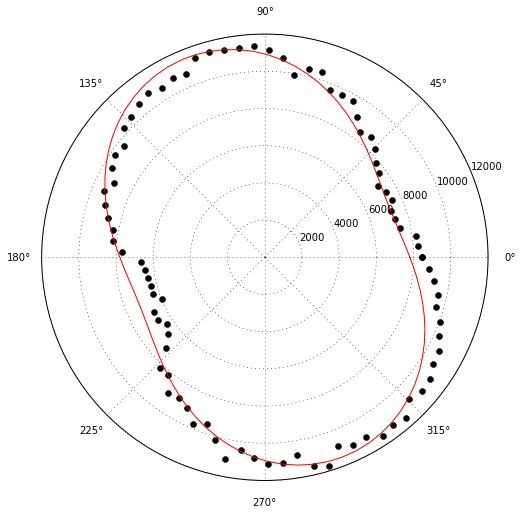

In [4]:
T1 = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\6-9-16\Dot 3 2mW rotor scan')
T1[:,1] -= 1829
OrientPol(T1,False)

Phi: 102.470043 +/- 0.669080
Theta: 46.417110 or +/- 0.529280
Phi(naive): -73.820000
Theta(naive): 52.222816


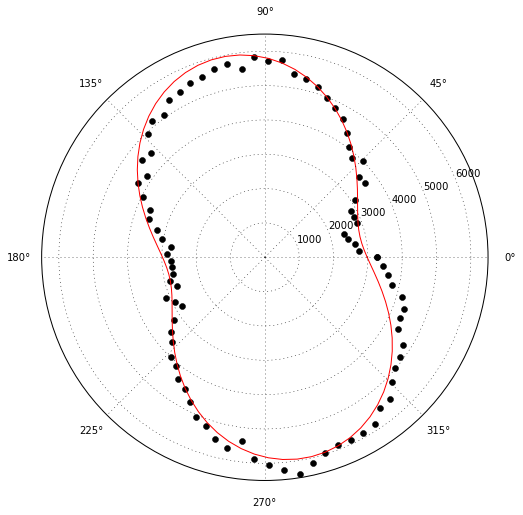

In [3]:
T1 = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\6-9-16\Dot 3 0.5mW rotor scan')
T1[:,1] -= 617
OrientPol(T1,False)

In [ ]:
T1 = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\6-9-16\Dot 3 0.2mW rotor scan')
T1[:,1] -= 450
OrientPol(T1,False)

In [3]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh import palettes
output_notebook()
TOOLS = "box_zoom,box_select,crosshair,hover,resize,reset"

Loading BokehJS ...

In [ ]:
files = glob.glob(r'C:\Users\Ouyang Group\Documents\Data\6-8-16\Dot 3 x146 y81 5mW ODMR sweep *V.txt')
output_file("6-8-16 Dot 3 ODMR 1.html")
bsweep = pd.concat((pd.read_table(f) for f in files),axis=1).values
bsweep = np.nan_to_num(bsweep)
diffs = bsweep[:,1::2]
Bs = np.linspace(0,0.526,len(files))*(11/0.5)
p = figure(x_range=[Bs[0],Bs[-1]], y_range=[bsweep[4,0],bsweep[-2,0]],tools=TOOLS)
p.image(image=[diffs],x=Bs[0], y=bsweep[4,0], dw=[Bs[-1]], dh=[bsweep[-2,0]-bsweep[4,0]], palette='RdPu9')
p.line(Bs,2.864E9+28E6*Bs,line_dash=(6,6),line_color='black')
p.line(Bs,2.864E9-28E6*Bs,line_dash=(6,6),line_color='black')
show(p)

In [5]:
files = glob.glob(r'C:\Users\Ouyang Group\Documents\Data\6-8-16\Dot 3 x146 y81 5mW ODMR sweep 2 *V.txt')
output_file("6-8-16 Dot 3 ODMR 2.html")
bsweep = pd.concat((pd.read_table(f) for f in files),axis=1).values
bsweep = np.nan_to_num(bsweep)
diffs = bsweep[:,1::2]
Bs = np.linspace(0,2,len(files))*(11/0.5)
p = figure(x_range=[Bs[0],Bs[-1]], y_range=[bsweep[4,0],bsweep[-2,0]],tools=TOOLS)
p.image(image=[diffs],x=Bs[0], y=bsweep[4,0], dw=[Bs[-1]], dh=[bsweep[-2,0]-bsweep[4,0]], palette='RdPu9')
p.line(Bs,2.864E9+28E6*Bs,line_dash=(6,6),line_color='black')
p.line(Bs,2.864E9-28E6*Bs,line_dash=(6,6),line_color='black')
show(p)

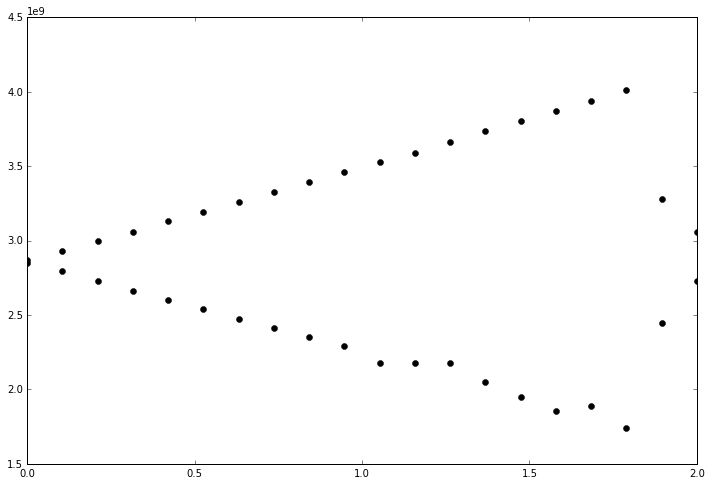

In [6]:
freq = bsweep[:,2]
fits = np.zeros((diffs.shape[1],6))
for i in range(0,diffs.shape[1]):
    O = diffs[:,i]
    opt, cov = curve_fit(ODMRfit,freq,O,p0=(-4E8,freq[np.argmin(O)],1E7,-4E8,2.87E9*2-freq[np.argmin(O)],1E7),maxfev=2500)
    fits[i,:] = opt
    
mask = (fits[:,1]<fits[:,4])
mins = fits[:,1]*mask + fits[:,4]*~mask
maxs = fits[:,1]*~mask + fits[:,4]*mask
plt.plot(Bs*0.5/11,mins,'ko')
plt.plot(Bs*0.5/11,maxs,'ko')

In [ ]:
p = figure(x_range=[Bs[0],Bs[-1]], y_range=[bsweep[4,0],bsweep[-2,0]],tools=TOOLS)
p.image(image=[diffs],x=Bs[0], y=bsweep[4,0], dw=[Bs[-1]], dh=[bsweep[-2,0]-bsweep[4,0]], palette='RdPu9')
p.line(Bs,2.864E9+28E6*Bs,line_dash=(6,6),line_color='black')
p.line(Bs,2.864E9-28E6*Bs,line_dash=(6,6),line_color='black')
p.circle(Bs,mins,color='black')
p.circle(Bs,maxs,color='black')
show(p)

In [7]:
np.savetxt(r'C:\Users\Ouyang Group\Documents\Data\6-8-16\Dot 3 20mW local ODMR lower freq.txt'
           ,np.vstack((Bs*0.5/11,mins)).T,fmt='%f',delimiter='\t')

[  1.15628740e+01   1.08951190e-02   1.61868542e+00   1.99673133e+02
   1.00316600e+02]


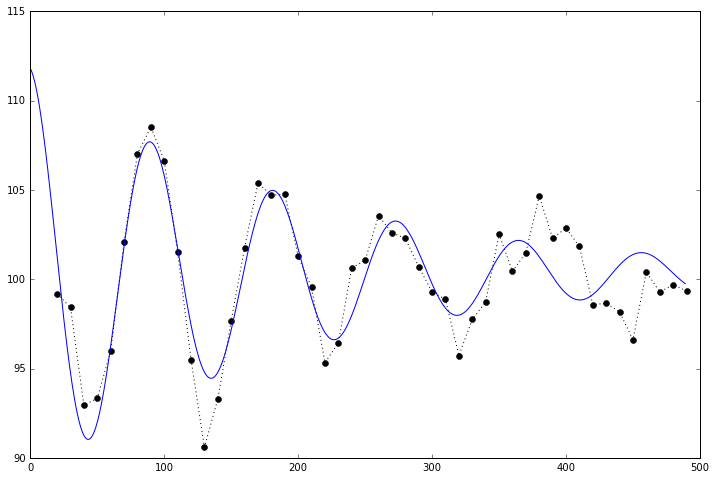

In [77]:
time,rabi0 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-16-16\Dot 3 0.4V Rabi 2 *[0-9]',
              r'C:\Users\Ouyang Group\Documents\Data\6-16-16\Dot 3 0.4V Rabi Pulse Seq')
rabi0 = 100*rabi0/np.mean(rabi0)
opt0,cov0 = curve_fit(RabiFit,time[1:],rabi0[1:],maxfev=2500,p0=(15,11E-3,0,2000,1))
t = np.arange(0,np.max(time),1)
plt.plot(time,rabi0,'ko:')
plt.plot(t,RabiFit(t,*opt0),'b-')
print opt0

In [25]:
def EPR_NoRef(EPRfiles,pseq):
    files = glob.glob(EPRfiles)
    d_sum = np.zeros((pseq.shape[0],))
    l = pseq.shape[0]
    for f in files:
        epr = np.loadtxt(f)
        diff = epr[:,0]
        diff = np.nan_to_num(diff)
        diff.resize(((diff.shape[0] - (diff.shape[0] % l)),1))
        diff = np.reshape(diff,(pseq.shape[0],-1),order='F')
        d_sum += np.mean(diff,axis=1)
        
    return pseq,d_sum/len(files)

In [ ]:
time = np.arange(20,4000,10)
t,o = EPR_NoRef(r'C:\Users\Ouyang Group\Documents\Data\6-9-16\Dot 4 20mW test 5',time)
o = o
plt.plot(t,o)

time = np.arange(20,4000,10)
t,o = EPR_NoRef(r'C:\Users\Ouyang Group\Documents\Data\6-9-16\Dot 4 20mW test 6',time)
o = o
plt.plot(t,o)



In [21]:
import re
def BatchEpr(base):
    files = glob.glob(base+'*')
    regex = re.compile(re.escape(base)+'(x\d+ y\d+ \d+) sec (\d+\.\d+) V   \d+')
    batches = sorted(list(set([(m.group(1),m.group(2)) for f in files for m in [regex.search(f)] if m])), key=lambda x: x[1])
    fits = np.zeros((len(batches),11))
    p_0=(15,11E-3,0,2000,100)
    bound = ([0,1E-4,-200,100,80],[20,1E-1,200,5E4,150])
    #pdb.set_trace()
    for i,e in enumerate(batches):
        time,rabi = EPR(base+e[0]+' sec '+e[1]+' V *[0-9]',base+e[0]+' sec '+e[1]+' V   Pulse Seq')
        rabi = 100*rabi/np.mean(rabi)
        try:
            opt,cov = curve_fit(RabiFit,time[1:],rabi[1:],p0=p_0,bounds=bound,max_nfev=5000)
            err = np.sqrt(np.diag(cov))
        except Exception as exc:
            print "could not fit "+e[1]
            print exc
            opt = [0]*5
            err = [0]*5

        fits[i,0] = e[1]
        fits[i,1:6] = opt
        fits[i,6:12] = err

        plt.plot(time[1:],rabi[1:],'ko:')
        t = np.arange(0,np.max(time),1)
        plt.plot(t,RabiFit(t,*opt),'b-')
        plt.savefig(base+e[0]+' 1500 sec '+e[1]+' V.png')
        plt.clf()
        
    return fits

In [22]:
fits = BatchEpr(r'C:\Users\Ouyang Group\Documents\Data\6-10-16\Dot 3 10mW upper Rabi ')

In [39]:
fits2 = BatchEpr(r'C:\Users\Ouyang Group\Documents\Data\6-10-16\Dot 3 10mW lower Rabi ')

<Container object of 3 artists>

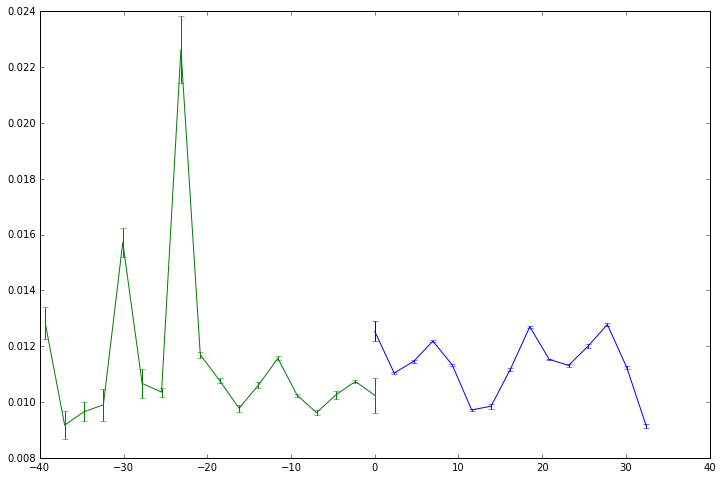

In [40]:
plt.errorbar(fits[:,0]*11/0.5,fits[:,2],yerr=fits[:,7])
plt.errorbar(fits2[:,0]*-11/0.5,fits2[:,2],yerr=fits2[:,7])

In [ ]:
test = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\6-9-16\Dot 3 20mW upper Rabi 3  x142 y80 750 sec 0.000000 V   2')
l = 98
diff = np.copy(test[l:,1])
diff.resize(((diff.shape[0]- (diff.shape[0] % l)),1))
diff = np.reshape(diff,(l,-1),order='F')
s = np.sum(diff,axis=0)
plt.plot(s,'ko')
print np.mean(s)
print np.std(s)

In [ ]:
files = glob.glob(r'C:\Users\Ouyang Group\Documents\Data\6-9-16\Dot 3 20mW upper Rabi 3  x142 y80 750 sec 0.000000 V   *[0-9]')
l=98
d_sum_0 = np.zeros((l,))
d_sum_1 = np.zeros((l,))
d_sum_2 = np.zeros((l,))


for i,f in enumerate(files):
    epr = np.loadtxt(f)
    diff = (epr[l:,0])
    diff[np.isinf(diff)] = 0
    diff = np.nan_to_num(diff)
    diff.resize(((diff.shape[0]- (diff.shape[0] % l)),1))
    diff = np.reshape(diff,(l,-1),order='F')
    s = np.sum(diff,axis=1)
    d_sum_0 += s
    
    diff = (epr[l:,1])
    diff[np.isinf(diff)] = 0
    diff = np.nan_to_num(diff)
    diff.resize(((diff.shape[0]- (diff.shape[0] % l)),1))
    diff = np.reshape(diff,(l,-1),order='F')
    s = np.sum(diff,axis=1)
    d_sum_1 += s
    
    diff = (epr[l:,0]-epr[l:,1])/epr[l:,1]
    diff[np.isinf(diff)] = 0
    diff = np.nan_to_num(diff)
    diff.resize(((diff.shape[0]- (diff.shape[0] % l)),1))
    diff = np.reshape(diff,(l,-1),order='F')
    s = np.sum(diff,axis=1)
    d_sum_2 += s
    
print (np.mean(d_sum_0),"  " ,np.mean(d_sum_1))
print (np.std(d_sum_0),"  ",np.std(d_sum_1))
#plt.plot(d_sum_0/np.mean(d_sum_0),'ko')
#plt.plot(d_sum_1/np.mean(d_sum_1),'bd')

d = (d_sum_0-d_sum_1)/d_sum_1
print (np.mean(d),np.mean(d_sum_2))
print (np.std(d),np.std(d_sum_2))
plt.plot(d,'ro')
plt.plot(d_sum_2,'bo')

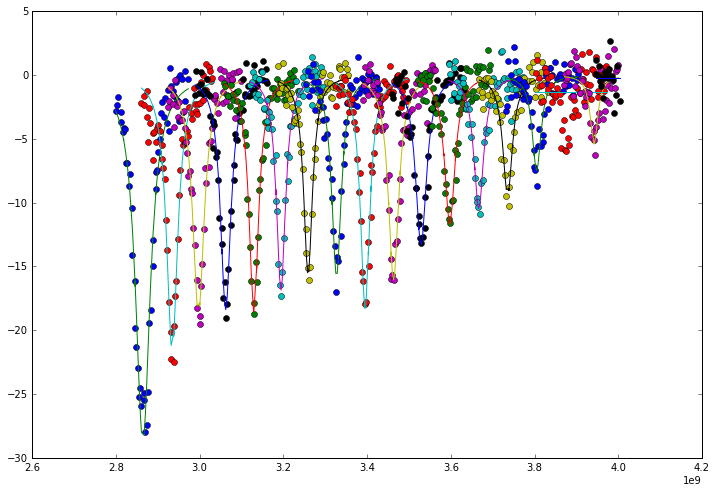

In [31]:
def lorentzian_2(X,a,x0,c):
    return a*c**2/(np.pi*c*(c**2+(X-x0)**2))

files = glob.glob(r'C:\Users\Ouyang Group\Documents\Data\6-10-16\Dot 3 local ODMR[0-9].*V ODMR')
res = np.zeros((len(files),2))
reg = re.compile(r'(\d\.\d+) V')
for i,f in enumerate(files):
    o = np.loadtxt(f)
    m = re.search(reg,f)
    opt,cov = curve_fit(lorentzian_2,o[1:,0],o[1:,1],p0=(-4E8,3.6E9,1E7),maxfev=5500)
    res[i,0]=m.group(1)
    res[i,1]=opt[1]
    plt.plot(o[1:,0],o[1:,1],'o')
    plt.plot(o[1:,0],lorentzian_2(o[1:,0],*opt))
    
np.savetxt(r'C:\Users\Ouyang Group\Documents\Data\6-10-16\Dot 3 local ODMR upper freq fit.txt',res,fmt='%f',delimiter='\t')
    

In [36]:
l=fits.shape[0]
np.savetxt(r'C:\Users\Ouyang Group\Documents\Data\6-10-16\Dot 3 local ODMR upper freq fit & rabi.txt'
           ,np.vstack((fits[:,0],res[:l,1],fits[:,2]*10**9)).T,fmt='%f',delimiter='\t')

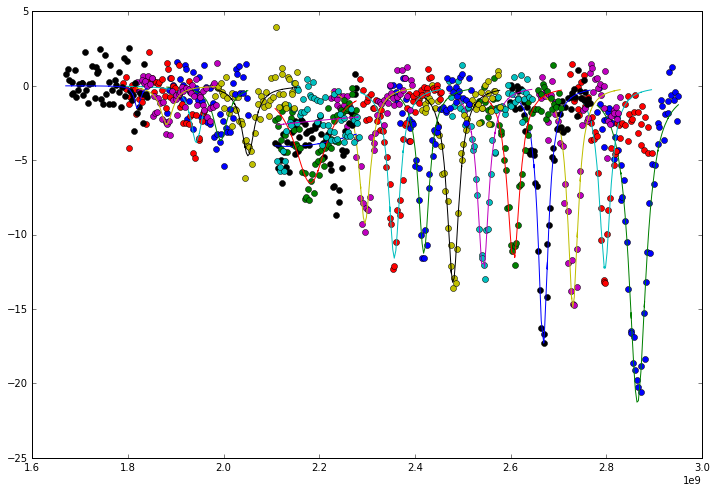

In [11]:

def lorentzian_2(X,a,x0,c):
    return a*c**2/(np.pi*c*(c**2+(X-x0)**2))

files = glob.glob(r'C:\Users\Ouyang Group\Documents\Data\6-10-16\Dot 3 local ODMR lower*V ODMR')
res = np.zeros((len(files),2))
reg = re.compile(r'(\d\.\d+) V')
for i,f in enumerate(files):
    o = np.loadtxt(f)
    m = re.search(reg,f)
    opt,cov = curve_fit(lorentzian_2,o[1:,0],o[1:,1],p0=(-4E8,3.6E9,1E7),maxfev=5500)
    res[i,0]=m.group(1)
    res[i,1]=opt[1]
    plt.plot(o[1:,0],o[1:,1],'o')
    plt.plot(o[1:,0],lorentzian_2(o[1:,0],*opt))
    
np.savetxt(r'C:\Users\Ouyang Group\Documents\Data\6-10-16\Dot 3 local ODMR lower freq fit.txt',res,fmt='%f',delimiter='\t')

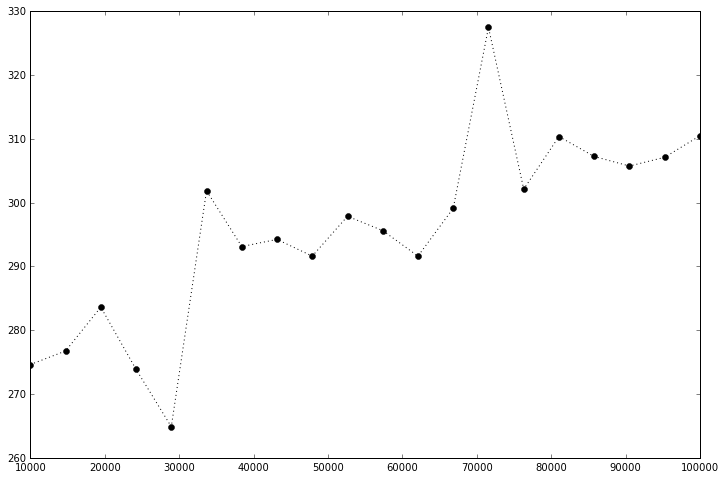

In [61]:
time,t1 = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-10-16\Dot 3 10mW upper T1 x137 y69 2400 sec 0.105263 V   *[0-9]',
              r'C:\Users\Ouyang Group\Documents\Data\6-10-16\Dot 3 10mW upper T1 x137 y69 2400 sec 0.105263 V   Pulse Seq')
plt.plot(time,t1,'ko:')

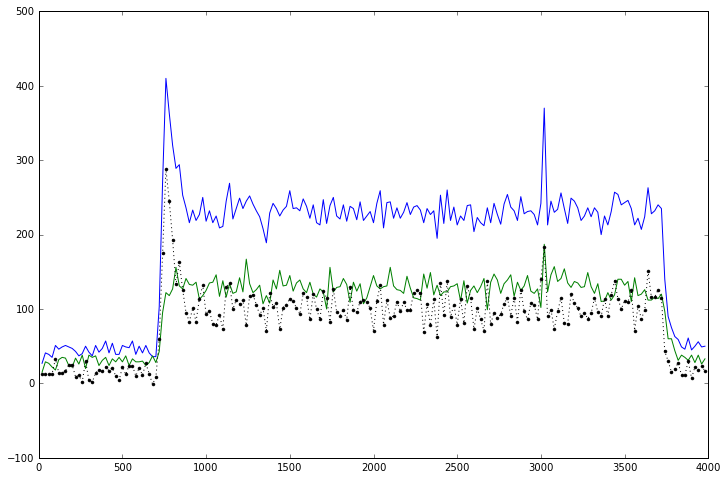

In [16]:
time = np.arange(20,4000,20)
t,o = EPR_NoRef(r'C:\Users\Ouyang Group\Documents\Data\6-15-16\Dot 3 0.4V T1 3',time)
o = o
plt.plot(t,o)

time = np.arange(20,4000,20)
t,o2 = EPR_NoRef(r'C:\Users\Ouyang Group\Documents\Data\6-15-16\Dot 3 0.4V Test Pulse Pi',time)
o2 = o2
plt.plot(t,o2)

plt.plot(t,o-o2,'k.:')

2.9702970297


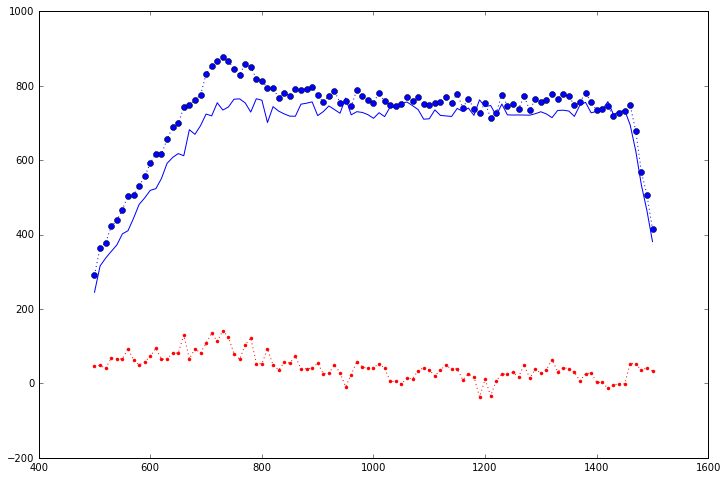

In [76]:
time = np.arange(500,1501,10)
t,o = EPR_NoRef(r'C:\Users\Ouyang Group\Documents\Data\6-16-16\Dot 3 test 300ns',time)
o = o
plt.plot(t,o,'bo:')


t,o2 = EPR_NoRef(r'C:\Users\Ouyang Group\Documents\Data\6-16-16\Dot 3 test 300ns pi',time)
o2 = o2
plt.plot(t,o2)

plt.plot(t,o-o2,'r.:')
t[np.argmax(o-o2)]
print 300./len(time)

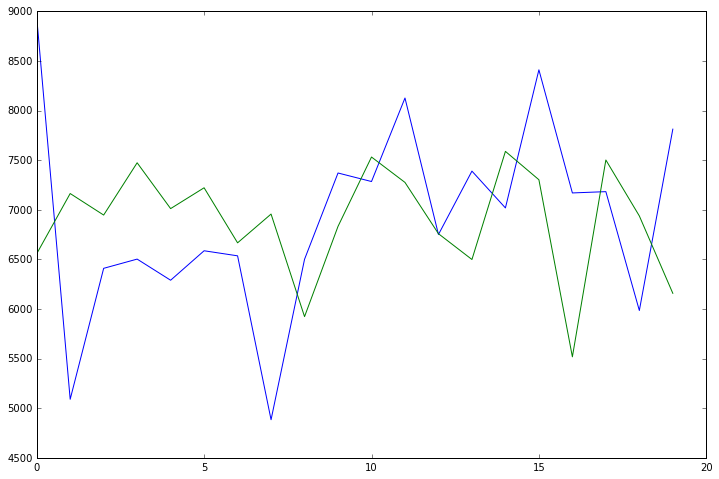

In [91]:
x = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\6-16-16\Dot 3 0.4V T1 new 2 pi')
plt.plot(x[:,0])

x = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\6-16-16\Dot 3 0.4V T1 new 2')
plt.plot(x[:,0])

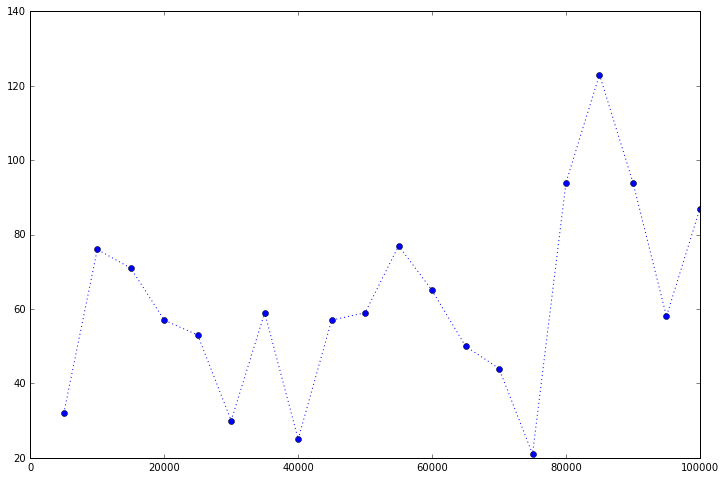

In [105]:
t,o = EPR(r'C:\Users\Ouyang Group\Documents\Data\6-16-16\Dot 3 0.4V T1 4 *[0-9]',
          r'C:\Users\Ouyang Group\Documents\Data\6-16-16\Dot 3 0.4V T1 Pulse Seq')
o = o
plt.plot(t,o,'bo:')
